In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/MyDrive/Term 8/Term 8 Artificial Intelligence/folder
%cd /content/drive/MyDrive/AI/CellCount

/content/drive/MyDrive/AI/CellCount


In [ ]:
!git clone https://github.com/Bjarten/early-stopping-pytorch.git ./earlystopping

fatal: destination path './earlystopping' already exists and is not an empty directory.


In [ ]:
import os
import torch
import datetime
from model import *
from utils import *
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage import io
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from scipy.io import loadmat, savemat
from torch.utils.data import Dataset, DataLoader
from earlystopping.pytorchtools import EarlyStopping
from torch.utils.data.sampler import SubsetRandomSampler

# Dataset and Dataloader

In [ ]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

class CellDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fileNames)
    
    """
    returns: tuple of
    - image
    - mask of size n x n with unique values/classes ranging from 0 to 4 
        0: background
        1: others (1)
        2: inflammatory(2)
        3: healthy epithelial(3) , dysplastic/malignant epithelial(4)
        4: fibroblast(5) , muscle(6) , endothelial(7)
    """
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,"Images",self.fileNames[idx])+".png"
        image = img = Image.open(img_name).convert('RGB')
        mask_name = os.path.join(self.root_dir,"Labels",self.fileNames[idx])+".mat"
        x = loadmat(mask_name)['type_map']
        x[(x==3)|(x==4)]=3
        x[(x==5)|(x==6)|(x==7)]=4
        
        # 250x250 images
        # x=np.pad(x.astype(int),3)

        # 500x500 images
        x=np.pad(x.astype(int),6)

        # 1000x1000 images
        # x=np.pad(x.astype(int),12)

        if self.transform:
            image = self.transform(image)
        return image, to_categorical(x,5).transpose(2, 0, 1) #(num_classes=5, n, n)

In [ ]:
transform = transforms.Compose([
    # 250x250 images
    # transforms.Pad(3),

    # 500x500 images
    transforms.Pad(6),

    # 1000x1000 images
    # transforms.Pad(12),
    
    transforms.ToTensor()    
])

valid_size = 0.2
batch_size =1

# DataLoader
train_data = CellDataset(root_dir="../Train/train_500", transform = transform)
test_data = CellDataset(root_dir="../Test/test_500", transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# load training data in batches
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=train_sampler,
                          num_workers=0)

# load validation data in batches
valid_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=valid_sampler,
                          num_workers=0)

# load test data in batches
test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        num_workers=0)

## Training

In [ ]:
def weighted_loss(pred,targ,bce_weight=0.7, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss

def train(model, device, train_loader, valid_loader, optimizer, epochs, patience, model_chkpt_name):
    train_losses = []
    valid_losses = []
    avg_train_losses = [] # average training loss per epoch
    avg_valid_losses = [] # average validation loss per epoch
    valid_acc = 0
    
    os.makedirs("best_model_checkpoints", exist_ok=True)
    os.makedirs("model_checkpoints", exist_ok=True)
    save_path = f"best_model_checkpoints/{model.__class__.__name__}.pth"
    early_stopping = EarlyStopping(patience=patience, path=save_path, verbose=True)
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
        valid_loss = 0
        score = 0
        """
        Trains the model on training data
        """
        for batch_idx, (data, target) in enumerate(train_loader):
            model.train()
            data, target = data.to(device), target.to(device).float()

            optimizer.zero_grad()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.5) 
            loss.backward()
            optimizer.step()

            train_loss+=(loss/len(data)).item()
            train_losses.append(loss.item())
        
        """
        Validate the model on validation data
        """
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device).float()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.3)
            valid_loss+=(loss/len(data)).item()
            valid_losses.append(loss.item())
            pred = output[0].to('cpu').detach()
            pred=F.softmax(pred, dim=0)# along the channel
            pred=pred.numpy()
            pred[pred.max(axis=0,keepdims=1) == pred] = 1
            pred[pred.max(axis=0,keepdims=1) != pred] = 0
            score+=get_dice_1(target, pred)

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        score /= len(valid_loader)
        if score > valid_acc:
            valid_acc = score

        # average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        torch.save(model.state_dict(), f"model_checkpoints/{model.__class__.__name__}_{model_chkpt_name}_{epoch}.pth")
        print('Train Epoch: {} @ {} - Train Loss: {:.4f} - Valid Loss: {:.4f}'.format(epoch, datetime.datetime.now().time(), train_loss, valid_loss))

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(save_path)) 

    return  model, avg_train_losses, avg_valid_losses, valid_acc

In [ ]:
# Set cpu / gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = build_model(device, "resnet")
model.to(device)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
# Training the model
print("Training")

epochs = 100
patience = 10  # how long to wait after last time validation loss improved
model_chkpt_name = "ResNet-500x500"

model, train_loss, valid_loss, valid_acc = train(model, device, train_loader, valid_loader, optimizer, epochs, patience, model_chkpt_name)

  0%|          | 0/100 [00:00<?, ?it/s]

Training
Validation loss decreased (inf --> 0.118768).  Saving model ...


  1%|          | 1/100 [00:22<36:19, 22.02s/it]

Train Epoch: 1 @ 09:41:33.840128 - Train Loss: 0.2196 - Valid Loss: 0.1188
EarlyStopping counter: 1 out of 10


  2%|▏         | 2/100 [00:43<35:41, 21.85s/it]

Train Epoch: 2 @ 09:41:55.303631 - Train Loss: 0.1615 - Valid Loss: 0.2089
Validation loss decreased (0.118768 --> 0.106937).  Saving model ...


  3%|▎         | 3/100 [01:05<35:12, 21.78s/it]

Train Epoch: 3 @ 09:42:16.921137 - Train Loss: 0.1464 - Valid Loss: 0.1069
Validation loss decreased (0.106937 --> 0.093654).  Saving model ...


  4%|▍         | 4/100 [01:26<34:52, 21.80s/it]

Train Epoch: 4 @ 09:42:38.769319 - Train Loss: 0.1387 - Valid Loss: 0.0937
Validation loss decreased (0.093654 --> 0.090398).  Saving model ...


  5%|▌         | 5/100 [01:48<34:35, 21.85s/it]

Train Epoch: 5 @ 09:43:00.730824 - Train Loss: 0.1231 - Valid Loss: 0.0904
EarlyStopping counter: 1 out of 10


  6%|▌         | 6/100 [02:10<33:59, 21.69s/it]

Train Epoch: 6 @ 09:43:22.057064 - Train Loss: 0.1196 - Valid Loss: 0.1680
Validation loss decreased (0.090398 --> 0.082560).  Saving model ...


  7%|▋         | 7/100 [02:31<33:28, 21.60s/it]

Train Epoch: 7 @ 09:43:43.439997 - Train Loss: 0.1245 - Valid Loss: 0.0826
Validation loss decreased (0.082560 --> 0.080655).  Saving model ...


  8%|▊         | 8/100 [02:53<33:11, 21.64s/it]

Train Epoch: 8 @ 09:44:05.190902 - Train Loss: 0.1094 - Valid Loss: 0.0807
EarlyStopping counter: 1 out of 10


  9%|▉         | 9/100 [03:14<32:38, 21.52s/it]

Train Epoch: 9 @ 09:44:26.429101 - Train Loss: 0.1017 - Valid Loss: 0.0854
EarlyStopping counter: 2 out of 10


 10%|█         | 10/100 [03:35<32:06, 21.41s/it]

Train Epoch: 10 @ 09:44:47.561785 - Train Loss: 0.1311 - Valid Loss: 0.0912
EarlyStopping counter: 3 out of 10


 11%|█         | 11/100 [03:56<31:41, 21.36s/it]

Train Epoch: 11 @ 09:45:08.819825 - Train Loss: 0.1066 - Valid Loss: 0.0864
EarlyStopping counter: 4 out of 10


 12%|█▏        | 12/100 [04:18<31:18, 21.34s/it]

Train Epoch: 12 @ 09:45:30.116021 - Train Loss: 0.0948 - Valid Loss: 0.0899
EarlyStopping counter: 5 out of 10


 13%|█▎        | 13/100 [04:39<31:00, 21.38s/it]

Train Epoch: 13 @ 09:45:51.599131 - Train Loss: 0.0939 - Valid Loss: 0.0893
Validation loss decreased (0.080655 --> 0.077225).  Saving model ...


 14%|█▍        | 14/100 [05:01<30:43, 21.43s/it]

Train Epoch: 14 @ 09:46:13.151649 - Train Loss: 0.0881 - Valid Loss: 0.0772
EarlyStopping counter: 1 out of 10


 15%|█▌        | 15/100 [05:22<30:20, 21.42s/it]

Train Epoch: 15 @ 09:46:34.521498 - Train Loss: 0.0896 - Valid Loss: 0.1002
EarlyStopping counter: 2 out of 10


 16%|█▌        | 16/100 [05:43<29:54, 21.36s/it]

Train Epoch: 16 @ 09:46:55.750758 - Train Loss: 0.0837 - Valid Loss: 0.0795
Validation loss decreased (0.077225 --> 0.075603).  Saving model ...


 17%|█▋        | 17/100 [06:05<29:33, 21.37s/it]

Train Epoch: 17 @ 09:47:17.156479 - Train Loss: 0.0829 - Valid Loss: 0.0756
Validation loss decreased (0.075603 --> 0.073766).  Saving model ...


 18%|█▊        | 18/100 [06:26<29:12, 21.37s/it]

Train Epoch: 18 @ 09:47:38.526401 - Train Loss: 0.0822 - Valid Loss: 0.0738
EarlyStopping counter: 1 out of 10


 19%|█▉        | 19/100 [06:48<28:52, 21.39s/it]

Train Epoch: 19 @ 09:47:59.960669 - Train Loss: 0.0832 - Valid Loss: 0.0843
EarlyStopping counter: 2 out of 10


 20%|██        | 20/100 [07:09<28:28, 21.35s/it]

Train Epoch: 20 @ 09:48:21.215520 - Train Loss: 0.0783 - Valid Loss: 0.0755
EarlyStopping counter: 3 out of 10


 21%|██        | 21/100 [07:30<28:03, 21.31s/it]

Train Epoch: 21 @ 09:48:42.417200 - Train Loss: 0.0738 - Valid Loss: 0.0819
EarlyStopping counter: 4 out of 10


 22%|██▏       | 22/100 [07:51<27:42, 21.31s/it]

Train Epoch: 22 @ 09:49:03.739320 - Train Loss: 0.0735 - Valid Loss: 0.0824
EarlyStopping counter: 5 out of 10


 23%|██▎       | 23/100 [08:12<27:14, 21.23s/it]

Train Epoch: 23 @ 09:49:24.769280 - Train Loss: 0.0852 - Valid Loss: 0.0842
EarlyStopping counter: 6 out of 10


 24%|██▍       | 24/100 [08:34<26:53, 21.23s/it]

Train Epoch: 24 @ 09:49:46.008466 - Train Loss: 0.0805 - Valid Loss: 0.0841
EarlyStopping counter: 7 out of 10


 25%|██▌       | 25/100 [08:55<26:34, 21.26s/it]

Train Epoch: 25 @ 09:50:07.324353 - Train Loss: 0.0725 - Valid Loss: 0.0755
EarlyStopping counter: 8 out of 10


 26%|██▌       | 26/100 [09:16<26:13, 21.26s/it]

Train Epoch: 26 @ 09:50:28.607389 - Train Loss: 0.0708 - Valid Loss: 0.0755
EarlyStopping counter: 9 out of 10


 27%|██▋       | 27/100 [09:37<25:50, 21.24s/it]

Train Epoch: 27 @ 09:50:49.787331 - Train Loss: 0.0691 - Valid Loss: 0.0742


 27%|██▋       | 27/100 [09:58<26:59, 22.18s/it]

EarlyStopping counter: 10 out of 10
Early stopping


In [ ]:
print("DICE score:", valid_acc)

DICE score: 0.9381444012677228


# Graph

In [ ]:
def plot_graph(train_loss, valid_loss):
  fig = plt.figure(figsize=(10,8))
  plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
  plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

  # find position of lowest validation loss
  minposs = valid_loss.index(min(valid_loss))+1 
  plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.ylim(0, 0.5) # consistent scale
  plt.xlim(0, len(train_loss)+1) # consistent scale
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
plot_graph(train_loss, valid_loss)

# Load model


In [ ]:
# load saved model
def load_model(model):
  path = f"best_model_checkpoints/{model.__class__.__name__}.pth"
  model.load_state_dict(torch.load(path)) 
  model.eval()
  return model
model = load_model(model)

# Test

In [ ]:
"""
0: black: background
1: red: others (1)
2: green: inflammatory(2)
3: dark blue: healthy epithelial(3) , dysplastic/malignant epithelial(4)
4: light blue: fibroblast(5) , muscle(6) , endothelial(7)
"""
# params: 5 x n x n numpy or n x n x 5
def printColoredMask(npMask,numchannel=5):
    if npMask.shape[-1]!=5:
        npMask=npMask.transpose(1, 2, 0)
    finalnpMask=np.where(npMask[:,:,1]==1,255,0) # one color
    finalnpMask=finalnpMask[:,:,None]
    temp=np.where((npMask[:,:,2]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
    temp=np.where((npMask[:,:,3]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
    plt.imshow(finalnpMask)
    plt.show()

In [ ]:
def test(model, device, data, target):
    print("Input Image")
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    plt.show()
    outputs = model(data.to(device))[0]
    pred = outputs.to('cpu').detach()
    pred=F.softmax(pred, dim=0)# along the channel
    pred=pred.numpy()

    print("Predicted Mask Sigmoid")
    pred[pred.max(axis=0,keepdims=1) == pred] = 1
    pred[pred.max(axis=0,keepdims=1) != pred] = 0
    printColoredMask(pred)
    print("Actual Mask")
    printColoredMask(target[0].numpy())

    # PQ
    pq_score = get_fast_pq(target, pred)[0]
    print("Detection Quality (DQ):", pq_score[0])
    print("Segmentation Quality (SQ):", pq_score[1])
    print("Panoptic Quality (PQ):", pq_score[2])
    
    dice_score = get_dice_1(target, pred)
    print("Dice score:", dice_score, "\n")

Input Image


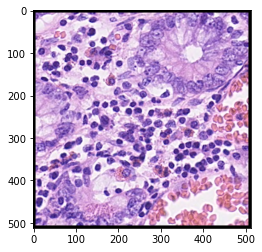

Predicted Mask Sigmoid


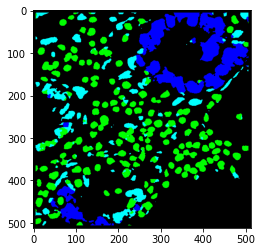

Actual Mask


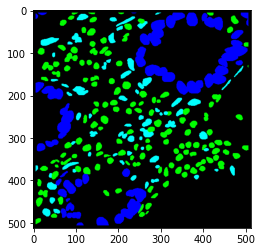

Detection Quality (DQ): 1.0
Segmentation Quality (SQ): 0.7608853784101839
Panoptic Quality (PQ): 0.7608853784101839
Dice score: 0.8642082214355469 



In [ ]:
# Testing the model
for data, target in test_loader:
    test(model, device, data, target)
    break

# Hyperparameter Tuning

In [ ]:
def hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name):
    print("Batch size: {}, Learning rate: {} , Epochs: {}\n".format(bs, lr, epochs))
    
    valid_size = 0.2

    # DataLoader
    train_data = CellDataset(root_dir=train_dir, transform = transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # load training data in batches
    train_loader = DataLoader(train_data,
                              batch_size=bs,
                              sampler=train_sampler,
                              num_workers=0)

    # load validation data in batches
    valid_loader = DataLoader(train_data,
                              batch_size=bs,
                              sampler=valid_sampler,
                              num_workers=0)
    
    # Set cpu / gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model and optimizer
    model = build_model(device, "resnet")
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    
    # Train model
    model, train_loss, valid_loss, valid_acc = train(model, device, train_loader, valid_loader, optimizer, epochs, patience, model_chkpt_name)
    plot_graph(train_loss, valid_loss)
    
    print("Dice2 score:", valid_acc)

#### model(2layer) - 500x500 images

Batch size: 1, Learning rate: 0.001 , Epochs: 60



  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validation loss decreased (inf --> 0.167197).  Saving model ...


  2%|▏         | 1/60 [00:23<23:09, 23.55s/it]

Train Epoch: 1 @ 15:56:37.496044 - Train Loss: 0.2172 - Valid Loss: 0.1672
Validation loss decreased (0.167197 --> 0.142752).  Saving model ...


  3%|▎         | 2/60 [00:47<22:59, 23.78s/it]

Train Epoch: 2 @ 15:57:01.801490 - Train Loss: 0.1507 - Valid Loss: 0.1428
Validation loss decreased (0.142752 --> 0.124919).  Saving model ...


  5%|▌         | 3/60 [01:12<22:43, 23.91s/it]

Train Epoch: 3 @ 15:57:26.039513 - Train Loss: 0.1422 - Valid Loss: 0.1249
EarlyStopping counter: 1 out of 10


  7%|▋         | 4/60 [01:35<22:11, 23.78s/it]

Train Epoch: 4 @ 15:57:49.502074 - Train Loss: 0.1278 - Valid Loss: 0.1262
EarlyStopping counter: 2 out of 10


  8%|▊         | 5/60 [01:59<21:46, 23.76s/it]

Train Epoch: 5 @ 15:58:13.229057 - Train Loss: 0.1193 - Valid Loss: 0.1457
Validation loss decreased (0.124919 --> 0.116768).  Saving model ...


 10%|█         | 6/60 [02:23<21:31, 23.91s/it]

Train Epoch: 6 @ 15:58:37.495327 - Train Loss: 0.1183 - Valid Loss: 0.1168
Validation loss decreased (0.116768 --> 0.108702).  Saving model ...


 12%|█▏        | 7/60 [02:47<21:12, 24.02s/it]

Train Epoch: 7 @ 15:59:01.751075 - Train Loss: 0.1072 - Valid Loss: 0.1087
EarlyStopping counter: 1 out of 10


 13%|█▎        | 8/60 [03:12<20:54, 24.12s/it]

Train Epoch: 8 @ 15:59:26.111617 - Train Loss: 0.1028 - Valid Loss: 0.1160
EarlyStopping counter: 2 out of 10


 15%|█▌        | 9/60 [03:36<20:28, 24.09s/it]

Train Epoch: 9 @ 15:59:50.146961 - Train Loss: 0.0992 - Valid Loss: 0.1156
EarlyStopping counter: 3 out of 10


 17%|█▋        | 10/60 [04:00<20:02, 24.06s/it]

Train Epoch: 10 @ 16:00:14.117002 - Train Loss: 0.0930 - Valid Loss: 0.1301
Validation loss decreased (0.108702 --> 0.094306).  Saving model ...


 18%|█▊        | 11/60 [04:24<19:41, 24.10s/it]

Train Epoch: 11 @ 16:00:38.326883 - Train Loss: 0.0948 - Valid Loss: 0.0943
Validation loss decreased (0.094306 --> 0.086897).  Saving model ...


 20%|██        | 12/60 [04:49<19:27, 24.33s/it]

Train Epoch: 12 @ 16:01:03.170667 - Train Loss: 0.0895 - Valid Loss: 0.0869
EarlyStopping counter: 1 out of 10


 22%|██▏       | 13/60 [05:13<19:02, 24.30s/it]

Train Epoch: 13 @ 16:01:27.407991 - Train Loss: 0.0820 - Valid Loss: 0.1169
EarlyStopping counter: 2 out of 10


 23%|██▎       | 14/60 [05:37<18:30, 24.14s/it]

Train Epoch: 14 @ 16:01:51.175930 - Train Loss: 0.0753 - Valid Loss: 0.0911
EarlyStopping counter: 3 out of 10


 25%|██▌       | 15/60 [06:01<18:10, 24.24s/it]

Train Epoch: 15 @ 16:02:15.633984 - Train Loss: 0.0757 - Valid Loss: 0.0954
EarlyStopping counter: 4 out of 10


 27%|██▋       | 16/60 [06:25<17:40, 24.10s/it]

Train Epoch: 16 @ 16:02:39.405919 - Train Loss: 0.0729 - Valid Loss: 0.1269
EarlyStopping counter: 5 out of 10


 28%|██▊       | 17/60 [06:49<17:14, 24.06s/it]

Train Epoch: 17 @ 16:03:03.372198 - Train Loss: 0.0845 - Valid Loss: 0.1102
EarlyStopping counter: 6 out of 10


 30%|███       | 18/60 [07:13<16:52, 24.10s/it]

Train Epoch: 18 @ 16:03:27.571982 - Train Loss: 0.0681 - Valid Loss: 0.1006
EarlyStopping counter: 7 out of 10


 32%|███▏      | 19/60 [07:37<16:24, 24.01s/it]

Train Epoch: 19 @ 16:03:51.378855 - Train Loss: 0.0609 - Valid Loss: 0.1245
EarlyStopping counter: 8 out of 10


 33%|███▎      | 20/60 [08:01<16:02, 24.05s/it]

Train Epoch: 20 @ 16:04:15.532923 - Train Loss: 0.0560 - Valid Loss: 0.1002
EarlyStopping counter: 9 out of 10


 35%|███▌      | 21/60 [08:25<15:38, 24.07s/it]

Train Epoch: 21 @ 16:04:39.651331 - Train Loss: 0.0533 - Valid Loss: 0.0947
EarlyStopping counter: 10 out of 10
Early stopping


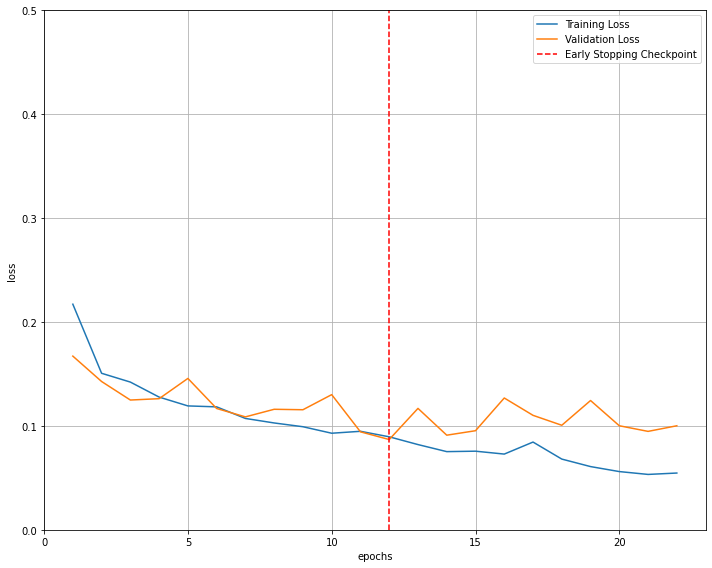

Dice2 score: 0.9274987114800347
Batch size: 1, Learning rate: 0.0001 , Epochs: 60




  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.125300).  Saving model ...



  2%|▏         | 1/60 [00:24<24:01, 24.44s/it]

Train Epoch: 1 @ 16:05:29.654560 - Train Loss: 0.2730 - Valid Loss: 0.1253
Validation loss decreased (0.125300 --> 0.110183).  Saving model ...



  3%|▎         | 2/60 [00:49<23:45, 24.58s/it]

Train Epoch: 2 @ 16:05:54.549459 - Train Loss: 0.1818 - Valid Loss: 0.1102
Validation loss decreased (0.110183 --> 0.108151).  Saving model ...



  5%|▌         | 3/60 [01:14<23:30, 24.74s/it]

Train Epoch: 3 @ 16:06:19.683048 - Train Loss: 0.1606 - Valid Loss: 0.1082
Validation loss decreased (0.108151 --> 0.093997).  Saving model ...



  7%|▋         | 4/60 [01:39<23:06, 24.76s/it]

Train Epoch: 4 @ 16:06:44.486431 - Train Loss: 0.1422 - Valid Loss: 0.0940
Validation loss decreased (0.093997 --> 0.090609).  Saving model ...



  8%|▊         | 5/60 [02:04<22:51, 24.94s/it]

Train Epoch: 5 @ 16:07:09.848421 - Train Loss: 0.1263 - Valid Loss: 0.0906
EarlyStopping counter: 1 out of 10



 10%|█         | 6/60 [02:29<22:19, 24.80s/it]

Train Epoch: 6 @ 16:07:34.309293 - Train Loss: 0.1165 - Valid Loss: 0.0907
Validation loss decreased (0.090609 --> 0.086745).  Saving model ...



 12%|█▏        | 7/60 [02:53<21:52, 24.76s/it]

Train Epoch: 7 @ 16:07:58.976447 - Train Loss: 0.1067 - Valid Loss: 0.0867
Validation loss decreased (0.086745 --> 0.083327).  Saving model ...



 13%|█▎        | 8/60 [03:18<21:34, 24.89s/it]

Train Epoch: 8 @ 16:08:24.184684 - Train Loss: 0.0962 - Valid Loss: 0.0833
Validation loss decreased (0.083327 --> 0.081376).  Saving model ...



 15%|█▌        | 9/60 [03:43<21:08, 24.87s/it]

Train Epoch: 9 @ 16:08:49.002897 - Train Loss: 0.0882 - Valid Loss: 0.0814
EarlyStopping counter: 1 out of 10



 17%|█▋        | 10/60 [04:08<20:41, 24.82s/it]

Train Epoch: 10 @ 16:09:13.715970 - Train Loss: 0.0837 - Valid Loss: 0.0843
EarlyStopping counter: 2 out of 10



 18%|█▊        | 11/60 [04:32<20:09, 24.69s/it]

Train Epoch: 11 @ 16:09:38.081409 - Train Loss: 0.0747 - Valid Loss: 0.0851
EarlyStopping counter: 3 out of 10



 20%|██        | 12/60 [04:56<19:35, 24.48s/it]

Train Epoch: 12 @ 16:10:02.088820 - Train Loss: 0.0695 - Valid Loss: 0.0829
EarlyStopping counter: 4 out of 10



 22%|██▏       | 13/60 [05:21<19:10, 24.49s/it]

Train Epoch: 13 @ 16:10:26.585567 - Train Loss: 0.0727 - Valid Loss: 0.0826
EarlyStopping counter: 5 out of 10



 23%|██▎       | 14/60 [05:45<18:46, 24.50s/it]

Train Epoch: 14 @ 16:10:51.106198 - Train Loss: 0.0654 - Valid Loss: 0.0845
EarlyStopping counter: 6 out of 10



 25%|██▌       | 15/60 [06:10<18:20, 24.45s/it]

Train Epoch: 15 @ 16:11:15.458575 - Train Loss: 0.0590 - Valid Loss: 0.0850
EarlyStopping counter: 7 out of 10



 27%|██▋       | 16/60 [06:34<17:50, 24.33s/it]

Train Epoch: 16 @ 16:11:39.508294 - Train Loss: 0.0561 - Valid Loss: 0.0862
EarlyStopping counter: 8 out of 10



 28%|██▊       | 17/60 [06:58<17:29, 24.40s/it]

Train Epoch: 17 @ 16:12:04.062061 - Train Loss: 0.0546 - Valid Loss: 0.0878
EarlyStopping counter: 9 out of 10



 30%|███       | 18/60 [07:23<17:02, 24.35s/it]

Train Epoch: 18 @ 16:12:28.298125 - Train Loss: 0.0514 - Valid Loss: 0.0836
EarlyStopping counter: 10 out of 10
Early stopping


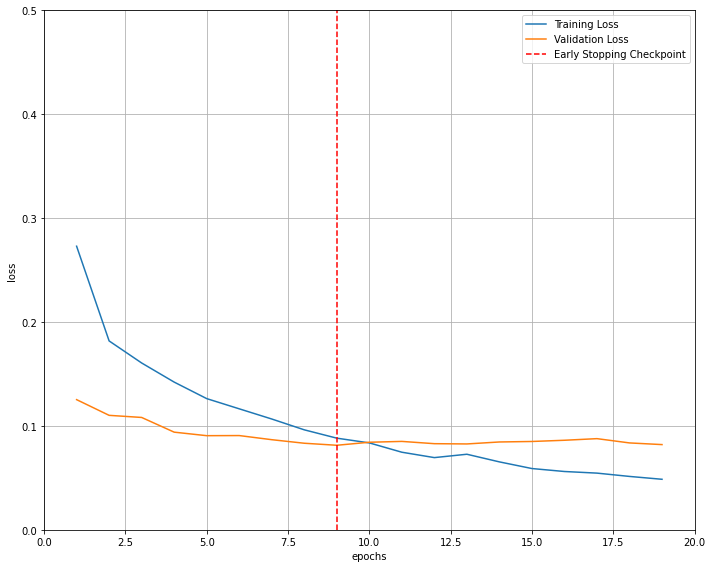

Dice2 score: 0.9314716480396412
Batch size: 1, Learning rate: 1e-05 , Epochs: 60





  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.196757).  Saving model ...




  2%|▏         | 1/60 [00:25<24:41, 25.10s/it]

Train Epoch: 1 @ 16:13:18.313668 - Train Loss: 0.5026 - Valid Loss: 0.1968
Validation loss decreased (0.196757 --> 0.183943).  Saving model ...




  3%|▎         | 2/60 [00:50<24:12, 25.04s/it]

Train Epoch: 2 @ 16:13:43.208574 - Train Loss: 0.2661 - Valid Loss: 0.1839
Validation loss decreased (0.183943 --> 0.183649).  Saving model ...




  5%|▌         | 3/60 [01:15<23:51, 25.12s/it]

Train Epoch: 3 @ 16:14:08.504086 - Train Loss: 0.2397 - Valid Loss: 0.1836
Validation loss decreased (0.183649 --> 0.170049).  Saving model ...




  7%|▋         | 4/60 [01:40<23:30, 25.19s/it]

Train Epoch: 4 @ 16:14:33.872044 - Train Loss: 0.2229 - Valid Loss: 0.1700
Validation loss decreased (0.170049 --> 0.164911).  Saving model ...




  8%|▊         | 5/60 [02:05<23:00, 25.09s/it]

Train Epoch: 5 @ 16:14:58.732104 - Train Loss: 0.2095 - Valid Loss: 0.1649
Validation loss decreased (0.164911 --> 0.158069).  Saving model ...




 10%|█         | 6/60 [02:33<23:17, 25.88s/it]

Train Epoch: 6 @ 16:15:26.447440 - Train Loss: 0.1963 - Valid Loss: 0.1581
Validation loss decreased (0.158069 --> 0.152333).  Saving model ...




 12%|█▏        | 7/60 [02:58<22:44, 25.74s/it]

Train Epoch: 7 @ 16:15:51.875476 - Train Loss: 0.1874 - Valid Loss: 0.1523
Validation loss decreased (0.152333 --> 0.145569).  Saving model ...




 13%|█▎        | 8/60 [03:23<22:09, 25.58s/it]

Train Epoch: 8 @ 16:16:17.062094 - Train Loss: 0.1810 - Valid Loss: 0.1456
Validation loss decreased (0.145569 --> 0.140094).  Saving model ...




 15%|█▌        | 9/60 [03:48<21:32, 25.35s/it]

Train Epoch: 9 @ 16:16:41.892123 - Train Loss: 0.1760 - Valid Loss: 0.1401
Validation loss decreased (0.140094 --> 0.137214).  Saving model ...




 17%|█▋        | 10/60 [04:14<21:09, 25.39s/it]

Train Epoch: 10 @ 16:17:07.369515 - Train Loss: 0.1711 - Valid Loss: 0.1372
EarlyStopping counter: 1 out of 10




 18%|█▊        | 11/60 [04:38<20:30, 25.10s/it]

Train Epoch: 11 @ 16:17:31.802559 - Train Loss: 0.1669 - Valid Loss: 0.1383
Validation loss decreased (0.137214 --> 0.130413).  Saving model ...




 20%|██        | 12/60 [05:03<20:03, 25.08s/it]

Train Epoch: 12 @ 16:17:56.816669 - Train Loss: 0.1629 - Valid Loss: 0.1304
Validation loss decreased (0.130413 --> 0.126159).  Saving model ...




 22%|██▏       | 13/60 [05:29<19:45, 25.21s/it]

Train Epoch: 13 @ 16:18:22.353558 - Train Loss: 0.1592 - Valid Loss: 0.1262
EarlyStopping counter: 1 out of 10




 23%|██▎       | 14/60 [05:53<19:08, 24.98s/it]

Train Epoch: 14 @ 16:18:46.779046 - Train Loss: 0.1553 - Valid Loss: 0.1311
Validation loss decreased (0.126159 --> 0.122615).  Saving model ...




 25%|██▌       | 15/60 [06:18<18:49, 25.10s/it]

Train Epoch: 15 @ 16:19:12.165184 - Train Loss: 0.1510 - Valid Loss: 0.1226
Validation loss decreased (0.122615 --> 0.119061).  Saving model ...




 27%|██▋       | 16/60 [06:44<18:28, 25.18s/it]

Train Epoch: 16 @ 16:19:37.537920 - Train Loss: 0.1475 - Valid Loss: 0.1191
EarlyStopping counter: 1 out of 10




 28%|██▊       | 17/60 [07:08<17:51, 24.93s/it]

Train Epoch: 17 @ 16:20:01.874325 - Train Loss: 0.1443 - Valid Loss: 0.1195
EarlyStopping counter: 2 out of 10




 30%|███       | 18/60 [07:33<17:27, 24.94s/it]

Train Epoch: 18 @ 16:20:26.857653 - Train Loss: 0.1413 - Valid Loss: 0.1237
Validation loss decreased (0.119061 --> 0.117487).  Saving model ...




 32%|███▏      | 19/60 [07:58<17:06, 25.04s/it]

Train Epoch: 19 @ 16:20:52.126568 - Train Loss: 0.1390 - Valid Loss: 0.1175
EarlyStopping counter: 1 out of 10




 33%|███▎      | 20/60 [08:23<16:37, 24.93s/it]

Train Epoch: 20 @ 16:21:16.810464 - Train Loss: 0.1361 - Valid Loss: 0.1191
Validation loss decreased (0.117487 --> 0.115265).  Saving model ...




 35%|███▌      | 21/60 [08:48<16:09, 24.87s/it]

Train Epoch: 21 @ 16:21:41.516591 - Train Loss: 0.1341 - Valid Loss: 0.1153
Validation loss decreased (0.115265 --> 0.111787).  Saving model ...




 37%|███▋      | 22/60 [09:13<15:52, 25.08s/it]

Train Epoch: 22 @ 16:22:07.081258 - Train Loss: 0.1317 - Valid Loss: 0.1118
EarlyStopping counter: 1 out of 10




 38%|███▊      | 23/60 [09:38<15:23, 24.96s/it]

Train Epoch: 23 @ 16:22:31.765561 - Train Loss: 0.1296 - Valid Loss: 0.1136
EarlyStopping counter: 2 out of 10




 40%|████      | 24/60 [10:03<14:55, 24.88s/it]

Train Epoch: 24 @ 16:22:56.470298 - Train Loss: 0.1279 - Valid Loss: 0.1133
EarlyStopping counter: 3 out of 10




 42%|████▏     | 25/60 [10:27<14:27, 24.80s/it]

Train Epoch: 25 @ 16:23:21.077216 - Train Loss: 0.1255 - Valid Loss: 0.1127
EarlyStopping counter: 4 out of 10




 43%|████▎     | 26/60 [10:52<13:57, 24.64s/it]

Train Epoch: 26 @ 16:23:45.356624 - Train Loss: 0.1237 - Valid Loss: 0.1139
Validation loss decreased (0.111787 --> 0.110244).  Saving model ...




 45%|████▌     | 27/60 [11:17<13:39, 24.83s/it]

Train Epoch: 27 @ 16:24:10.609064 - Train Loss: 0.1221 - Valid Loss: 0.1102
EarlyStopping counter: 1 out of 10




 47%|████▋     | 28/60 [11:42<13:13, 24.80s/it]

Train Epoch: 28 @ 16:24:35.333755 - Train Loss: 0.1200 - Valid Loss: 0.1118
EarlyStopping counter: 2 out of 10




 48%|████▊     | 29/60 [12:06<12:44, 24.65s/it]

Train Epoch: 29 @ 16:24:59.641605 - Train Loss: 0.1184 - Valid Loss: 0.1102
EarlyStopping counter: 3 out of 10




 50%|█████     | 30/60 [12:31<12:21, 24.73s/it]

Train Epoch: 30 @ 16:25:24.564844 - Train Loss: 0.1165 - Valid Loss: 0.1129
EarlyStopping counter: 4 out of 10




 52%|█████▏    | 31/60 [12:55<11:52, 24.58s/it]

Train Epoch: 31 @ 16:25:48.786839 - Train Loss: 0.1151 - Valid Loss: 0.1135
EarlyStopping counter: 5 out of 10




 53%|█████▎    | 32/60 [13:20<11:27, 24.57s/it]

Train Epoch: 32 @ 16:26:13.324655 - Train Loss: 0.1131 - Valid Loss: 0.1138
EarlyStopping counter: 6 out of 10




 55%|█████▌    | 33/60 [13:45<11:05, 24.66s/it]

Train Epoch: 33 @ 16:26:38.213273 - Train Loss: 0.1117 - Valid Loss: 0.1118
EarlyStopping counter: 7 out of 10




 57%|█████▋    | 34/60 [14:09<10:42, 24.72s/it]

Train Epoch: 34 @ 16:27:03.057904 - Train Loss: 0.1099 - Valid Loss: 0.1118
Validation loss decreased (0.110244 --> 0.109837).  Saving model ...




 58%|█████▊    | 35/60 [14:34<10:18, 24.73s/it]

Train Epoch: 35 @ 16:27:27.820391 - Train Loss: 0.1080 - Valid Loss: 0.1098
Validation loss decreased (0.109837 --> 0.107548).  Saving model ...




 60%|██████    | 36/60 [14:59<09:57, 24.90s/it]

Train Epoch: 36 @ 16:27:53.127492 - Train Loss: 0.1063 - Valid Loss: 0.1075
EarlyStopping counter: 1 out of 10




 62%|██████▏   | 37/60 [15:24<09:33, 24.93s/it]

Train Epoch: 37 @ 16:28:18.105938 - Train Loss: 0.1049 - Valid Loss: 0.1101
EarlyStopping counter: 2 out of 10




 63%|██████▎   | 38/60 [15:49<09:04, 24.75s/it]

Train Epoch: 38 @ 16:28:42.431531 - Train Loss: 0.1036 - Valid Loss: 0.1090
EarlyStopping counter: 3 out of 10




 65%|██████▌   | 39/60 [16:14<08:39, 24.75s/it]

Train Epoch: 39 @ 16:29:07.192746 - Train Loss: 0.1018 - Valid Loss: 0.1089
EarlyStopping counter: 4 out of 10




 67%|██████▋   | 40/60 [16:38<08:14, 24.71s/it]

Train Epoch: 40 @ 16:29:31.802736 - Train Loss: 0.1002 - Valid Loss: 0.1110
EarlyStopping counter: 5 out of 10




 68%|██████▊   | 41/60 [17:02<07:46, 24.57s/it]

Train Epoch: 41 @ 16:29:56.065820 - Train Loss: 0.0988 - Valid Loss: 0.1100
EarlyStopping counter: 6 out of 10




 70%|███████   | 42/60 [17:27<07:24, 24.70s/it]

Train Epoch: 42 @ 16:30:21.062715 - Train Loss: 0.0976 - Valid Loss: 0.1100
EarlyStopping counter: 7 out of 10




 72%|███████▏  | 43/60 [17:52<06:59, 24.67s/it]

Train Epoch: 43 @ 16:30:45.644102 - Train Loss: 0.0960 - Valid Loss: 0.1088
EarlyStopping counter: 8 out of 10




 73%|███████▎  | 44/60 [18:17<06:34, 24.66s/it]

Train Epoch: 44 @ 16:31:10.277139 - Train Loss: 0.0949 - Valid Loss: 0.1086
EarlyStopping counter: 9 out of 10




 75%|███████▌  | 45/60 [18:41<06:10, 24.67s/it]

Train Epoch: 45 @ 16:31:34.993435 - Train Loss: 0.0932 - Valid Loss: 0.1108
EarlyStopping counter: 10 out of 10
Early stopping


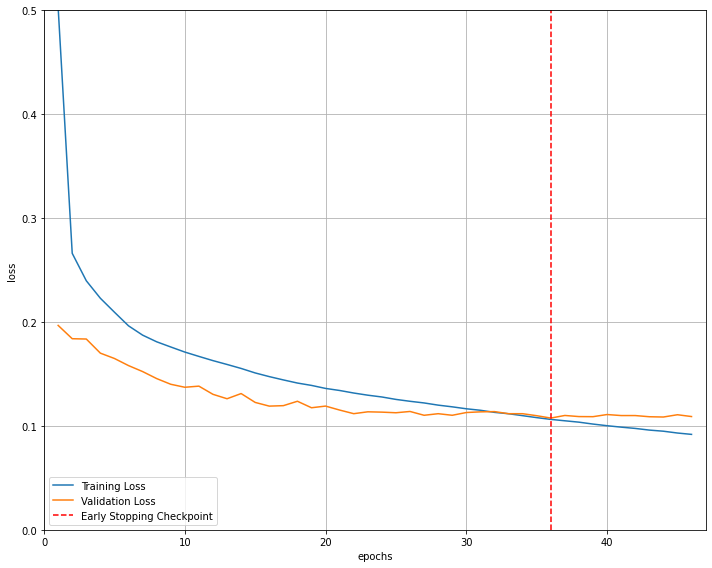

Dice2 score: 0.9062559339735243


In [ ]:
n_bs = [1]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "../Train/train_500"
model_chkpt_name = "ResNet-500x500_2layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

Batch size: 4, Learning rate: 0.001 , Epochs: 60



  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validation loss decreased (inf --> 0.136450).  Saving model ...


  2%|▏         | 1/60 [02:08<2:06:26, 128.58s/it]

Train Epoch: 1 @ 10:23:58.398528 - Train Loss: 0.2720 - Valid Loss: 0.1364
Validation loss decreased (0.136450 --> 0.113173).  Saving model ...


  3%|▎         | 2/60 [02:28<1:32:50, 96.04s/it] 

Train Epoch: 2 @ 10:24:18.506622 - Train Loss: 0.1814 - Valid Loss: 0.1132
Validation loss decreased (0.113173 --> 0.105600).  Saving model ...


  5%|▌         | 3/60 [02:48<1:09:38, 73.30s/it]

Train Epoch: 3 @ 10:24:38.747276 - Train Loss: 0.1663 - Valid Loss: 0.1056
EarlyStopping counter: 1 out of 10


  7%|▋         | 4/60 [03:08<53:30, 57.32s/it]  

Train Epoch: 4 @ 10:24:58.787866 - Train Loss: 0.1511 - Valid Loss: 0.1131
Validation loss decreased (0.105600 --> 0.102327).  Saving model ...


  8%|▊         | 5/60 [03:29<42:28, 46.33s/it]

Train Epoch: 5 @ 10:25:19.477997 - Train Loss: 0.1432 - Valid Loss: 0.1023
EarlyStopping counter: 1 out of 10


 10%|█         | 6/60 [03:49<34:36, 38.45s/it]

Train Epoch: 6 @ 10:25:39.523746 - Train Loss: 0.1415 - Valid Loss: 0.1023
Validation loss decreased (0.102327 --> 0.088110).  Saving model ...


 12%|█▏        | 7/60 [04:09<29:08, 33.00s/it]

Train Epoch: 7 @ 10:25:59.811813 - Train Loss: 0.1367 - Valid Loss: 0.0881
Validation loss decreased (0.088110 --> 0.083950).  Saving model ...


 13%|█▎        | 8/60 [04:30<25:22, 29.29s/it]

Train Epoch: 8 @ 10:26:20.439501 - Train Loss: 0.1235 - Valid Loss: 0.0840
Validation loss decreased (0.083950 --> 0.077301).  Saving model ...


 15%|█▌        | 9/60 [04:53<23:18, 27.43s/it]

Train Epoch: 9 @ 10:26:43.535942 - Train Loss: 0.1197 - Valid Loss: 0.0773
EarlyStopping counter: 1 out of 10


 17%|█▋        | 10/60 [05:13<21:00, 25.21s/it]

Train Epoch: 10 @ 10:27:03.573766 - Train Loss: 0.1125 - Valid Loss: 0.0918
Validation loss decreased (0.077301 --> 0.075032).  Saving model ...


 18%|█▊        | 11/60 [05:34<19:26, 23.81s/it]

Train Epoch: 11 @ 10:27:24.124635 - Train Loss: 0.1145 - Valid Loss: 0.0750
Validation loss decreased (0.075032 --> 0.070226).  Saving model ...


 20%|██        | 12/60 [05:54<18:17, 22.86s/it]

Train Epoch: 12 @ 10:27:44.761060 - Train Loss: 0.1064 - Valid Loss: 0.0702
EarlyStopping counter: 1 out of 10


 22%|██▏       | 13/60 [06:15<17:18, 22.09s/it]

Train Epoch: 13 @ 10:28:05.042145 - Train Loss: 0.1034 - Valid Loss: 0.0890
Validation loss decreased (0.070226 --> 0.067758).  Saving model ...


 23%|██▎       | 14/60 [06:35<16:33, 21.59s/it]

Train Epoch: 14 @ 10:28:25.471880 - Train Loss: 0.1052 - Valid Loss: 0.0678
EarlyStopping counter: 1 out of 10


 25%|██▌       | 15/60 [06:55<15:50, 21.13s/it]

Train Epoch: 15 @ 10:28:45.540300 - Train Loss: 0.0991 - Valid Loss: 0.0744
EarlyStopping counter: 2 out of 10


 27%|██▋       | 16/60 [07:15<15:17, 20.86s/it]

Train Epoch: 16 @ 10:29:05.754758 - Train Loss: 0.0963 - Valid Loss: 0.0765
EarlyStopping counter: 3 out of 10


 28%|██▊       | 17/60 [07:35<14:45, 20.58s/it]

Train Epoch: 17 @ 10:29:25.692481 - Train Loss: 0.0926 - Valid Loss: 0.0714
Validation loss decreased (0.067758 --> 0.066002).  Saving model ...


 30%|███       | 18/60 [07:56<14:20, 20.50s/it]

Train Epoch: 18 @ 10:29:45.989024 - Train Loss: 0.0916 - Valid Loss: 0.0660
EarlyStopping counter: 1 out of 10


 32%|███▏      | 19/60 [08:16<13:56, 20.41s/it]

Train Epoch: 19 @ 10:30:06.186078 - Train Loss: 0.0870 - Valid Loss: 0.0695
Validation loss decreased (0.066002 --> 0.064544).  Saving model ...


 33%|███▎      | 20/60 [08:36<13:36, 20.41s/it]

Train Epoch: 20 @ 10:30:26.589201 - Train Loss: 0.0901 - Valid Loss: 0.0645
EarlyStopping counter: 1 out of 10


 35%|███▌      | 21/60 [08:56<13:10, 20.26s/it]

Train Epoch: 21 @ 10:30:46.500217 - Train Loss: 0.0857 - Valid Loss: 0.0662
Validation loss decreased (0.064544 --> 0.063560).  Saving model ...


 37%|███▋      | 22/60 [09:17<12:51, 20.31s/it]

Train Epoch: 22 @ 10:31:06.917346 - Train Loss: 0.0829 - Valid Loss: 0.0636
EarlyStopping counter: 1 out of 10


 38%|███▊      | 23/60 [09:37<12:29, 20.27s/it]

Train Epoch: 23 @ 10:31:27.089594 - Train Loss: 0.0775 - Valid Loss: 0.0691
EarlyStopping counter: 2 out of 10


 40%|████      | 24/60 [09:57<12:05, 20.14s/it]

Train Epoch: 24 @ 10:31:46.934124 - Train Loss: 0.0758 - Valid Loss: 0.0665
EarlyStopping counter: 3 out of 10


 42%|████▏     | 25/60 [10:17<11:44, 20.12s/it]

Train Epoch: 25 @ 10:32:06.997425 - Train Loss: 0.0704 - Valid Loss: 0.0721
EarlyStopping counter: 4 out of 10


 43%|████▎     | 26/60 [10:37<11:23, 20.09s/it]

Train Epoch: 26 @ 10:32:27.026413 - Train Loss: 0.0718 - Valid Loss: 0.0661
Validation loss decreased (0.063560 --> 0.063318).  Saving model ...


 45%|████▌     | 27/60 [10:57<11:07, 20.22s/it]

Train Epoch: 27 @ 10:32:47.546373 - Train Loss: 0.0751 - Valid Loss: 0.0633
EarlyStopping counter: 1 out of 10


 47%|████▋     | 28/60 [11:17<10:45, 20.17s/it]

Train Epoch: 28 @ 10:33:07.588141 - Train Loss: 0.0714 - Valid Loss: 0.0691
EarlyStopping counter: 2 out of 10


 48%|████▊     | 29/60 [11:37<10:21, 20.06s/it]

Train Epoch: 29 @ 10:33:27.400281 - Train Loss: 0.0663 - Valid Loss: 0.0698
EarlyStopping counter: 3 out of 10


 50%|█████     | 30/60 [11:57<10:00, 20.02s/it]

Train Epoch: 30 @ 10:33:47.339161 - Train Loss: 0.0641 - Valid Loss: 0.0636
EarlyStopping counter: 4 out of 10


 52%|█████▏    | 31/60 [12:17<09:40, 20.03s/it]

Train Epoch: 31 @ 10:34:07.369383 - Train Loss: 0.0588 - Valid Loss: 0.0649
EarlyStopping counter: 5 out of 10


 53%|█████▎    | 32/60 [12:37<09:19, 19.97s/it]

Train Epoch: 32 @ 10:34:27.219806 - Train Loss: 0.0607 - Valid Loss: 0.0777
EarlyStopping counter: 6 out of 10


 55%|█████▌    | 33/60 [12:57<08:58, 19.95s/it]

Train Epoch: 33 @ 10:34:47.105768 - Train Loss: 0.0569 - Valid Loss: 0.0637
EarlyStopping counter: 7 out of 10


 57%|█████▋    | 34/60 [13:17<08:39, 19.99s/it]

Train Epoch: 34 @ 10:35:07.205997 - Train Loss: 0.0576 - Valid Loss: 0.0653
EarlyStopping counter: 8 out of 10


 58%|█████▊    | 35/60 [13:37<08:19, 19.98s/it]

Train Epoch: 35 @ 10:35:27.166983 - Train Loss: 0.0558 - Valid Loss: 0.0642
Validation loss decreased (0.063318 --> 0.062708).  Saving model ...


 60%|██████    | 36/60 [13:57<08:01, 20.08s/it]

Train Epoch: 36 @ 10:35:47.466802 - Train Loss: 0.0541 - Valid Loss: 0.0627
EarlyStopping counter: 1 out of 10


 62%|██████▏   | 37/60 [14:18<07:44, 20.20s/it]

Train Epoch: 37 @ 10:36:07.956838 - Train Loss: 0.0511 - Valid Loss: 0.0643
EarlyStopping counter: 2 out of 10


 63%|██████▎   | 38/60 [14:38<07:23, 20.15s/it]

Train Epoch: 38 @ 10:36:27.968911 - Train Loss: 0.0491 - Valid Loss: 0.0719
EarlyStopping counter: 3 out of 10


 65%|██████▌   | 39/60 [14:58<07:01, 20.08s/it]

Train Epoch: 39 @ 10:36:47.891761 - Train Loss: 0.0467 - Valid Loss: 0.0686
EarlyStopping counter: 4 out of 10


 67%|██████▋   | 40/60 [15:18<06:42, 20.10s/it]

Train Epoch: 40 @ 10:37:08.044260 - Train Loss: 0.0435 - Valid Loss: 0.0649
EarlyStopping counter: 5 out of 10


 68%|██████▊   | 41/60 [15:38<06:22, 20.13s/it]

Train Epoch: 41 @ 10:37:28.242386 - Train Loss: 0.0416 - Valid Loss: 0.0685
EarlyStopping counter: 6 out of 10


 70%|███████   | 42/60 [15:58<06:01, 20.06s/it]

Train Epoch: 42 @ 10:37:48.125692 - Train Loss: 0.0439 - Valid Loss: 0.0666
EarlyStopping counter: 7 out of 10


 72%|███████▏  | 43/60 [16:18<05:40, 20.02s/it]

Train Epoch: 43 @ 10:38:08.065266 - Train Loss: 0.0493 - Valid Loss: 0.0692
EarlyStopping counter: 8 out of 10


 73%|███████▎  | 44/60 [16:38<05:20, 20.03s/it]

Train Epoch: 44 @ 10:38:28.129425 - Train Loss: 0.0458 - Valid Loss: 0.0687
EarlyStopping counter: 9 out of 10


 75%|███████▌  | 45/60 [16:58<05:00, 20.05s/it]

Train Epoch: 45 @ 10:38:48.218983 - Train Loss: 0.0430 - Valid Loss: 0.0710
EarlyStopping counter: 10 out of 10
Early stopping


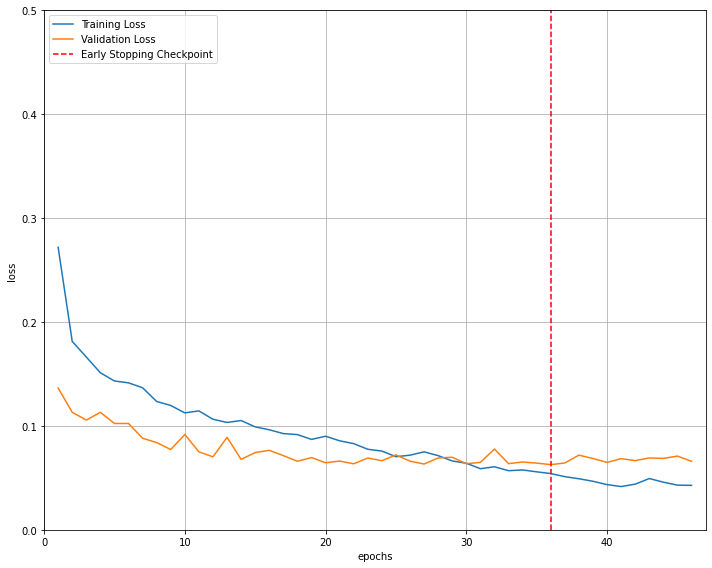

Dice2 score: 0.9798943655831474
Batch size: 4, Learning rate: 0.0001 , Epochs: 60




  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.217497).  Saving model ...



  2%|▏         | 1/60 [00:20<20:10, 20.52s/it]

Train Epoch: 1 @ 10:39:29.845520 - Train Loss: 0.4844 - Valid Loss: 0.2175
Validation loss decreased (0.217497 --> 0.191413).  Saving model ...



  3%|▎         | 2/60 [00:42<20:19, 21.02s/it]

Train Epoch: 2 @ 10:39:52.035608 - Train Loss: 0.2933 - Valid Loss: 0.1914
Validation loss decreased (0.191413 --> 0.168187).  Saving model ...



  5%|▌         | 3/60 [01:03<19:59, 21.05s/it]

Train Epoch: 3 @ 10:40:13.161234 - Train Loss: 0.2502 - Valid Loss: 0.1682
Validation loss decreased (0.168187 --> 0.157359).  Saving model ...



  7%|▋         | 4/60 [01:24<19:35, 20.99s/it]

Train Epoch: 4 @ 10:40:34.017473 - Train Loss: 0.2185 - Valid Loss: 0.1574
Validation loss decreased (0.157359 --> 0.152048).  Saving model ...



  8%|▊         | 5/60 [01:45<19:12, 20.95s/it]

Train Epoch: 5 @ 10:40:54.856665 - Train Loss: 0.1957 - Valid Loss: 0.1520
Validation loss decreased (0.152048 --> 0.141043).  Saving model ...



 10%|█         | 6/60 [02:06<18:50, 20.94s/it]

Train Epoch: 6 @ 10:41:15.763306 - Train Loss: 0.1802 - Valid Loss: 0.1410
Validation loss decreased (0.141043 --> 0.140050).  Saving model ...



 12%|█▏        | 7/60 [02:27<18:28, 20.92s/it]

Train Epoch: 7 @ 10:41:36.649169 - Train Loss: 0.1709 - Valid Loss: 0.1401
Validation loss decreased (0.140050 --> 0.132573).  Saving model ...



 13%|█▎        | 8/60 [02:48<18:10, 20.97s/it]

Train Epoch: 8 @ 10:41:57.726563 - Train Loss: 0.1566 - Valid Loss: 0.1326
Validation loss decreased (0.132573 --> 0.127425).  Saving model ...



 15%|█▌        | 9/60 [03:10<18:12, 21.43s/it]

Train Epoch: 9 @ 10:42:20.231014 - Train Loss: 0.1465 - Valid Loss: 0.1274
Validation loss decreased (0.127425 --> 0.124533).  Saving model ...



 17%|█▋        | 10/60 [03:31<17:45, 21.32s/it]

Train Epoch: 10 @ 10:42:41.292481 - Train Loss: 0.1424 - Valid Loss: 0.1245
EarlyStopping counter: 1 out of 10



 18%|█▊        | 11/60 [03:52<17:12, 21.07s/it]

Train Epoch: 11 @ 10:43:01.787203 - Train Loss: 0.1330 - Valid Loss: 0.1248
Validation loss decreased (0.124533 --> 0.116662).  Saving model ...



 20%|██        | 12/60 [04:13<16:50, 21.04s/it]

Train Epoch: 12 @ 10:43:22.769745 - Train Loss: 0.1315 - Valid Loss: 0.1167
EarlyStopping counter: 1 out of 10



 22%|██▏       | 13/60 [04:33<16:21, 20.88s/it]

Train Epoch: 13 @ 10:43:43.259192 - Train Loss: 0.1288 - Valid Loss: 0.1174
Validation loss decreased (0.116662 --> 0.113001).  Saving model ...



 23%|██▎       | 14/60 [04:54<16:00, 20.89s/it]

Train Epoch: 14 @ 10:44:04.170216 - Train Loss: 0.1225 - Valid Loss: 0.1130
Validation loss decreased (0.113001 --> 0.108382).  Saving model ...



 25%|██▌       | 15/60 [05:15<15:40, 20.91s/it]

Train Epoch: 15 @ 10:44:25.115419 - Train Loss: 0.1163 - Valid Loss: 0.1084
EarlyStopping counter: 1 out of 10



 27%|██▋       | 16/60 [05:36<15:14, 20.79s/it]

Train Epoch: 16 @ 10:44:45.643180 - Train Loss: 0.1101 - Valid Loss: 0.1088
EarlyStopping counter: 2 out of 10



 28%|██▊       | 17/60 [05:56<14:49, 20.68s/it]

Train Epoch: 17 @ 10:45:06.067996 - Train Loss: 0.1094 - Valid Loss: 0.1099
Validation loss decreased (0.108382 --> 0.106673).  Saving model ...



 30%|███       | 18/60 [06:18<14:37, 20.89s/it]

Train Epoch: 18 @ 10:45:27.452908 - Train Loss: 0.1040 - Valid Loss: 0.1067
Validation loss decreased (0.106673 --> 0.105279).  Saving model ...



 32%|███▏      | 19/60 [06:39<14:18, 20.93s/it]

Train Epoch: 19 @ 10:45:48.477926 - Train Loss: 0.1028 - Valid Loss: 0.1053
Validation loss decreased (0.105279 --> 0.098829).  Saving model ...



 33%|███▎      | 20/60 [07:00<14:00, 21.02s/it]

Train Epoch: 20 @ 10:46:09.692935 - Train Loss: 0.1005 - Valid Loss: 0.0988
EarlyStopping counter: 1 out of 10



 35%|███▌      | 21/60 [07:20<13:33, 20.86s/it]

Train Epoch: 21 @ 10:46:30.179593 - Train Loss: 0.0921 - Valid Loss: 0.0993
EarlyStopping counter: 2 out of 10



 37%|███▋      | 22/60 [07:41<13:06, 20.71s/it]

Train Epoch: 22 @ 10:46:50.541880 - Train Loss: 0.0884 - Valid Loss: 0.1020
EarlyStopping counter: 3 out of 10



 38%|███▊      | 23/60 [08:01<12:43, 20.63s/it]

Train Epoch: 23 @ 10:47:10.978876 - Train Loss: 0.0898 - Valid Loss: 0.1012
EarlyStopping counter: 4 out of 10



 40%|████      | 24/60 [08:21<12:18, 20.52s/it]

Train Epoch: 24 @ 10:47:31.261282 - Train Loss: 0.0857 - Valid Loss: 0.1006
EarlyStopping counter: 5 out of 10



 42%|████▏     | 25/60 [08:42<11:54, 20.42s/it]

Train Epoch: 25 @ 10:47:51.426275 - Train Loss: 0.0814 - Valid Loss: 0.0991
Validation loss decreased (0.098829 --> 0.096322).  Saving model ...



 43%|████▎     | 26/60 [09:03<11:39, 20.57s/it]

Train Epoch: 26 @ 10:48:12.342093 - Train Loss: 0.0804 - Valid Loss: 0.0963
Validation loss decreased (0.096322 --> 0.096056).  Saving model ...



 45%|████▌     | 27/60 [09:24<11:22, 20.69s/it]

Train Epoch: 27 @ 10:48:33.336910 - Train Loss: 0.0763 - Valid Loss: 0.0961
EarlyStopping counter: 1 out of 10



 47%|████▋     | 28/60 [09:45<11:05, 20.80s/it]

Train Epoch: 28 @ 10:48:54.396792 - Train Loss: 0.0742 - Valid Loss: 0.0999
EarlyStopping counter: 2 out of 10



 48%|████▊     | 29/60 [10:05<10:41, 20.68s/it]

Train Epoch: 29 @ 10:49:14.770096 - Train Loss: 0.0759 - Valid Loss: 0.0972
EarlyStopping counter: 3 out of 10



 50%|█████     | 30/60 [10:25<10:18, 20.61s/it]

Train Epoch: 30 @ 10:49:35.235916 - Train Loss: 0.0716 - Valid Loss: 0.0982
EarlyStopping counter: 4 out of 10



 52%|█████▏    | 31/60 [10:46<09:57, 20.60s/it]

Train Epoch: 31 @ 10:49:55.817238 - Train Loss: 0.0699 - Valid Loss: 0.0969
EarlyStopping counter: 5 out of 10



 53%|█████▎    | 32/60 [11:06<09:35, 20.55s/it]

Train Epoch: 32 @ 10:50:16.233880 - Train Loss: 0.0722 - Valid Loss: 0.0993
Validation loss decreased (0.096056 --> 0.095467).  Saving model ...



 55%|█████▌    | 33/60 [11:27<09:17, 20.64s/it]

Train Epoch: 33 @ 10:50:37.091283 - Train Loss: 0.0673 - Valid Loss: 0.0955
EarlyStopping counter: 1 out of 10



 57%|█████▋    | 34/60 [11:48<08:56, 20.63s/it]

Train Epoch: 34 @ 10:50:57.703765 - Train Loss: 0.0663 - Valid Loss: 0.0970
EarlyStopping counter: 2 out of 10



 58%|█████▊    | 35/60 [12:08<08:33, 20.55s/it]

Train Epoch: 35 @ 10:51:18.048265 - Train Loss: 0.0660 - Valid Loss: 0.0965
EarlyStopping counter: 3 out of 10



 60%|██████    | 36/60 [12:28<08:11, 20.46s/it]

Train Epoch: 36 @ 10:51:38.319739 - Train Loss: 0.0623 - Valid Loss: 0.0964
EarlyStopping counter: 4 out of 10



 62%|██████▏   | 37/60 [12:49<07:51, 20.49s/it]

Train Epoch: 37 @ 10:51:58.866871 - Train Loss: 0.0644 - Valid Loss: 0.0983
EarlyStopping counter: 5 out of 10



 63%|██████▎   | 38/60 [13:10<07:32, 20.57s/it]

Train Epoch: 38 @ 10:52:19.637147 - Train Loss: 0.0611 - Valid Loss: 0.0972
EarlyStopping counter: 6 out of 10



 65%|██████▌   | 39/60 [13:30<07:12, 20.60s/it]

Train Epoch: 39 @ 10:52:40.296357 - Train Loss: 0.0616 - Valid Loss: 0.0968
EarlyStopping counter: 7 out of 10



 67%|██████▋   | 40/60 [13:51<06:50, 20.52s/it]

Train Epoch: 40 @ 10:53:00.620799 - Train Loss: 0.0652 - Valid Loss: 0.0984
EarlyStopping counter: 8 out of 10



 68%|██████▊   | 41/60 [14:11<06:29, 20.51s/it]

Train Epoch: 41 @ 10:53:21.107333 - Train Loss: 0.0618 - Valid Loss: 0.0976
Validation loss decreased (0.095467 --> 0.095331).  Saving model ...



 70%|███████   | 42/60 [14:32<06:09, 20.55s/it]

Train Epoch: 42 @ 10:53:41.753056 - Train Loss: 0.0592 - Valid Loss: 0.0953
EarlyStopping counter: 1 out of 10



 72%|███████▏  | 43/60 [14:52<05:48, 20.48s/it]

Train Epoch: 43 @ 10:54:02.084223 - Train Loss: 0.0576 - Valid Loss: 0.0963
EarlyStopping counter: 2 out of 10



 73%|███████▎  | 44/60 [15:13<05:27, 20.50s/it]

Train Epoch: 44 @ 10:54:22.609114 - Train Loss: 0.0554 - Valid Loss: 0.0963
EarlyStopping counter: 3 out of 10



 75%|███████▌  | 45/60 [15:33<05:07, 20.47s/it]

Train Epoch: 45 @ 10:54:43.010996 - Train Loss: 0.0554 - Valid Loss: 0.1001
EarlyStopping counter: 4 out of 10



 77%|███████▋  | 46/60 [15:54<04:46, 20.49s/it]

Train Epoch: 46 @ 10:55:03.567183 - Train Loss: 0.0539 - Valid Loss: 0.0969
EarlyStopping counter: 5 out of 10



 78%|███████▊  | 47/60 [16:14<04:25, 20.44s/it]

Train Epoch: 47 @ 10:55:23.870807 - Train Loss: 0.0525 - Valid Loss: 0.0956
EarlyStopping counter: 6 out of 10



 80%|████████  | 48/60 [16:34<04:04, 20.40s/it]

Train Epoch: 48 @ 10:55:44.195662 - Train Loss: 0.0517 - Valid Loss: 0.0976
EarlyStopping counter: 7 out of 10



 82%|████████▏ | 49/60 [16:55<03:44, 20.44s/it]

Train Epoch: 49 @ 10:56:04.723029 - Train Loss: 0.0511 - Valid Loss: 0.0989
EarlyStopping counter: 8 out of 10



 83%|████████▎ | 50/60 [17:15<03:23, 20.40s/it]

Train Epoch: 50 @ 10:56:25.024297 - Train Loss: 0.0505 - Valid Loss: 0.0998
EarlyStopping counter: 9 out of 10



 85%|████████▌ | 51/60 [17:35<03:03, 20.34s/it]

Train Epoch: 51 @ 10:56:45.233818 - Train Loss: 0.0504 - Valid Loss: 0.0993
EarlyStopping counter: 10 out of 10
Early stopping


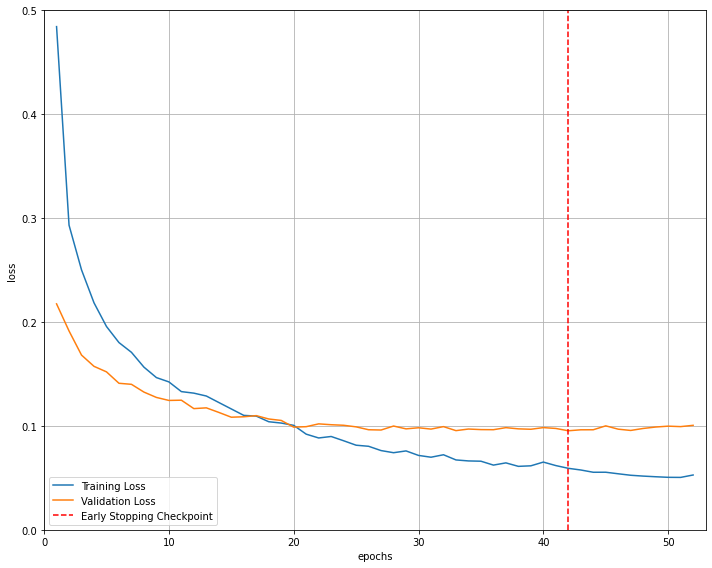

Dice2 score: 0.9633440290178571
Batch size: 4, Learning rate: 1e-05 , Epochs: 60





  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.647296).  Saving model ...




  2%|▏         | 1/60 [00:20<20:17, 20.64s/it]

Train Epoch: 1 @ 10:57:27.280327 - Train Loss: 0.6615 - Valid Loss: 0.6473
Validation loss decreased (0.647296 --> 0.454903).  Saving model ...




  3%|▎         | 2/60 [00:41<20:00, 20.70s/it]

Train Epoch: 2 @ 10:57:48.097102 - Train Loss: 0.5480 - Valid Loss: 0.4549
Validation loss decreased (0.454903 --> 0.228892).  Saving model ...




  5%|▌         | 3/60 [01:02<19:46, 20.81s/it]

Train Epoch: 3 @ 10:58:09.164827 - Train Loss: 0.3730 - Valid Loss: 0.2289
Validation loss decreased (0.228892 --> 0.180079).  Saving model ...




  7%|▋         | 4/60 [01:23<19:26, 20.82s/it]

Train Epoch: 4 @ 10:58:30.020235 - Train Loss: 0.2894 - Valid Loss: 0.1801
Validation loss decreased (0.180079 --> 0.167398).  Saving model ...




  8%|▊         | 5/60 [01:44<19:04, 20.82s/it]

Train Epoch: 5 @ 10:58:50.828329 - Train Loss: 0.2642 - Valid Loss: 0.1674
Validation loss decreased (0.167398 --> 0.160735).  Saving model ...




 10%|█         | 6/60 [02:06<19:14, 21.38s/it]

Train Epoch: 6 @ 10:59:13.511235 - Train Loss: 0.2457 - Valid Loss: 0.1607
Validation loss decreased (0.160735 --> 0.153111).  Saving model ...




 12%|█▏        | 7/60 [02:27<18:46, 21.26s/it]

Train Epoch: 7 @ 10:59:34.490052 - Train Loss: 0.2342 - Valid Loss: 0.1531
Validation loss decreased (0.153111 --> 0.153101).  Saving model ...




 13%|█▎        | 8/60 [02:48<18:18, 21.12s/it]

Train Epoch: 8 @ 10:59:55.301152 - Train Loss: 0.2232 - Valid Loss: 0.1531
Validation loss decreased (0.153101 --> 0.151770).  Saving model ...




 15%|█▌        | 9/60 [03:09<17:55, 21.09s/it]

Train Epoch: 9 @ 11:00:16.304943 - Train Loss: 0.2176 - Valid Loss: 0.1518
Validation loss decreased (0.151770 --> 0.151332).  Saving model ...




 17%|█▋        | 10/60 [03:30<17:31, 21.03s/it]

Train Epoch: 10 @ 11:00:37.185090 - Train Loss: 0.2103 - Valid Loss: 0.1513
Validation loss decreased (0.151332 --> 0.140420).  Saving model ...




 18%|█▊        | 11/60 [03:51<17:10, 21.04s/it]

Train Epoch: 11 @ 11:00:58.254339 - Train Loss: 0.2049 - Valid Loss: 0.1404
Validation loss decreased (0.140420 --> 0.135208).  Saving model ...




 20%|██        | 12/60 [04:12<16:48, 21.01s/it]

Train Epoch: 12 @ 11:01:19.196618 - Train Loss: 0.1957 - Valid Loss: 0.1352
Validation loss decreased (0.135208 --> 0.131749).  Saving model ...




 22%|██▏       | 13/60 [04:33<16:24, 20.95s/it]

Train Epoch: 13 @ 11:01:40.021712 - Train Loss: 0.1954 - Valid Loss: 0.1317
Validation loss decreased (0.131749 --> 0.127945).  Saving model ...




 23%|██▎       | 14/60 [04:54<16:05, 20.99s/it]

Train Epoch: 14 @ 11:02:01.084939 - Train Loss: 0.1898 - Valid Loss: 0.1279
Validation loss decreased (0.127945 --> 0.120540).  Saving model ...




 25%|██▌       | 15/60 [05:15<15:48, 21.07s/it]

Train Epoch: 15 @ 11:02:22.351493 - Train Loss: 0.1836 - Valid Loss: 0.1205
Validation loss decreased (0.120540 --> 0.118109).  Saving model ...




 27%|██▋       | 16/60 [05:36<15:22, 20.97s/it]

Train Epoch: 16 @ 11:02:43.075072 - Train Loss: 0.1798 - Valid Loss: 0.1181
Validation loss decreased (0.118109 --> 0.112617).  Saving model ...




 28%|██▊       | 17/60 [05:57<15:03, 21.02s/it]

Train Epoch: 17 @ 11:03:04.223869 - Train Loss: 0.1786 - Valid Loss: 0.1126
EarlyStopping counter: 1 out of 10




 30%|███       | 18/60 [06:18<14:36, 20.86s/it]

Train Epoch: 18 @ 11:03:24.701555 - Train Loss: 0.1762 - Valid Loss: 0.1132
EarlyStopping counter: 2 out of 10




 32%|███▏      | 19/60 [06:38<14:07, 20.66s/it]

Train Epoch: 19 @ 11:03:44.905109 - Train Loss: 0.1784 - Valid Loss: 0.1144
EarlyStopping counter: 3 out of 10




 33%|███▎      | 20/60 [06:58<13:43, 20.58s/it]

Train Epoch: 20 @ 11:04:05.288243 - Train Loss: 0.1733 - Valid Loss: 0.1127
Validation loss decreased (0.112617 --> 0.107687).  Saving model ...




 35%|███▌      | 21/60 [07:19<13:27, 20.70s/it]

Train Epoch: 21 @ 11:04:26.283257 - Train Loss: 0.1714 - Valid Loss: 0.1077
EarlyStopping counter: 1 out of 10




 37%|███▋      | 22/60 [07:40<13:03, 20.61s/it]

Train Epoch: 22 @ 11:04:46.680586 - Train Loss: 0.1664 - Valid Loss: 0.1099
EarlyStopping counter: 2 out of 10




 38%|███▊      | 23/60 [08:00<12:39, 20.52s/it]

Train Epoch: 23 @ 11:05:07.001376 - Train Loss: 0.1662 - Valid Loss: 0.1079
EarlyStopping counter: 3 out of 10




 40%|████      | 24/60 [08:20<12:18, 20.52s/it]

Train Epoch: 24 @ 11:05:27.514647 - Train Loss: 0.1628 - Valid Loss: 0.1079
EarlyStopping counter: 4 out of 10




 42%|████▏     | 25/60 [08:41<11:56, 20.48s/it]

Train Epoch: 25 @ 11:05:47.910330 - Train Loss: 0.1621 - Valid Loss: 0.1080
Validation loss decreased (0.107687 --> 0.105960).  Saving model ...




 43%|████▎     | 26/60 [09:02<11:41, 20.62s/it]

Train Epoch: 26 @ 11:06:08.846528 - Train Loss: 0.1613 - Valid Loss: 0.1060
Validation loss decreased (0.105960 --> 0.104831).  Saving model ...




 45%|████▌     | 27/60 [09:23<11:22, 20.69s/it]

Train Epoch: 27 @ 11:06:29.691238 - Train Loss: 0.1577 - Valid Loss: 0.1048
Validation loss decreased (0.104831 --> 0.101032).  Saving model ...




 47%|████▋     | 28/60 [09:44<11:05, 20.80s/it]

Train Epoch: 28 @ 11:06:50.756843 - Train Loss: 0.1581 - Valid Loss: 0.1010
Validation loss decreased (0.101032 --> 0.100638).  Saving model ...




 48%|████▊     | 29/60 [10:05<10:47, 20.89s/it]

Train Epoch: 29 @ 11:07:11.862345 - Train Loss: 0.1578 - Valid Loss: 0.1006
EarlyStopping counter: 1 out of 10




 50%|█████     | 30/60 [10:25<10:22, 20.75s/it]

Train Epoch: 30 @ 11:07:32.271319 - Train Loss: 0.1573 - Valid Loss: 0.1018
Validation loss decreased (0.100638 --> 0.099163).  Saving model ...




 52%|█████▏    | 31/60 [10:46<10:04, 20.85s/it]

Train Epoch: 31 @ 11:07:53.367082 - Train Loss: 0.1526 - Valid Loss: 0.0992
EarlyStopping counter: 1 out of 10




 53%|█████▎    | 32/60 [11:07<09:43, 20.83s/it]

Train Epoch: 32 @ 11:08:14.130862 - Train Loss: 0.1505 - Valid Loss: 0.1004
Validation loss decreased (0.099163 --> 0.098879).  Saving model ...




 55%|█████▌    | 33/60 [11:28<09:23, 20.86s/it]

Train Epoch: 33 @ 11:08:35.075931 - Train Loss: 0.1523 - Valid Loss: 0.0989
Validation loss decreased (0.098879 --> 0.098326).  Saving model ...




 57%|█████▋    | 34/60 [11:49<09:02, 20.88s/it]

Train Epoch: 34 @ 11:08:55.996522 - Train Loss: 0.1492 - Valid Loss: 0.0983
Validation loss decreased (0.098326 --> 0.095680).  Saving model ...




 58%|█████▊    | 35/60 [12:10<08:44, 20.96s/it]

Train Epoch: 35 @ 11:09:17.160734 - Train Loss: 0.1466 - Valid Loss: 0.0957
EarlyStopping counter: 1 out of 10




 60%|██████    | 36/60 [12:30<08:19, 20.79s/it]

Train Epoch: 36 @ 11:09:37.554321 - Train Loss: 0.1498 - Valid Loss: 0.1015
EarlyStopping counter: 2 out of 10




 62%|██████▏   | 37/60 [12:51<07:54, 20.64s/it]

Train Epoch: 37 @ 11:09:57.829982 - Train Loss: 0.1460 - Valid Loss: 0.0961
Validation loss decreased (0.095680 --> 0.094353).  Saving model ...




 63%|██████▎   | 38/60 [13:12<07:36, 20.76s/it]

Train Epoch: 38 @ 11:10:18.879750 - Train Loss: 0.1435 - Valid Loss: 0.0944
EarlyStopping counter: 1 out of 10




 65%|██████▌   | 39/60 [13:32<07:13, 20.65s/it]

Train Epoch: 39 @ 11:10:39.252749 - Train Loss: 0.1439 - Valid Loss: 0.0962
EarlyStopping counter: 2 out of 10




 67%|██████▋   | 40/60 [13:53<06:51, 20.57s/it]

Train Epoch: 40 @ 11:10:59.649565 - Train Loss: 0.1437 - Valid Loss: 0.0954
EarlyStopping counter: 3 out of 10




 68%|██████▊   | 41/60 [14:13<06:29, 20.52s/it]

Train Epoch: 41 @ 11:11:20.038693 - Train Loss: 0.1432 - Valid Loss: 0.0977
EarlyStopping counter: 4 out of 10




 70%|███████   | 42/60 [14:33<06:08, 20.49s/it]

Train Epoch: 42 @ 11:11:40.478794 - Train Loss: 0.1446 - Valid Loss: 0.0978
Validation loss decreased (0.094353 --> 0.094109).  Saving model ...




 72%|███████▏  | 43/60 [14:54<05:51, 20.69s/it]

Train Epoch: 43 @ 11:12:01.615832 - Train Loss: 0.1400 - Valid Loss: 0.0941
Validation loss decreased (0.094109 --> 0.092919).  Saving model ...




 73%|███████▎  | 44/60 [15:15<05:32, 20.76s/it]

Train Epoch: 44 @ 11:12:22.536176 - Train Loss: 0.1379 - Valid Loss: 0.0929
Validation loss decreased (0.092919 --> 0.092203).  Saving model ...




 75%|███████▌  | 45/60 [15:36<05:11, 20.77s/it]

Train Epoch: 45 @ 11:12:43.332737 - Train Loss: 0.1373 - Valid Loss: 0.0922
Validation loss decreased (0.092203 --> 0.090787).  Saving model ...




 77%|███████▋  | 46/60 [15:57<04:52, 20.90s/it]

Train Epoch: 46 @ 11:13:04.518976 - Train Loss: 0.1404 - Valid Loss: 0.0908
EarlyStopping counter: 1 out of 10




 78%|███████▊  | 47/60 [16:18<04:30, 20.79s/it]

Train Epoch: 47 @ 11:13:25.079956 - Train Loss: 0.1399 - Valid Loss: 0.0915
EarlyStopping counter: 2 out of 10




 80%|████████  | 48/60 [16:38<04:07, 20.64s/it]

Train Epoch: 48 @ 11:13:45.354936 - Train Loss: 0.1385 - Valid Loss: 0.0933
EarlyStopping counter: 3 out of 10




 82%|████████▏ | 49/60 [16:59<03:47, 20.65s/it]

Train Epoch: 49 @ 11:14:06.025497 - Train Loss: 0.1354 - Valid Loss: 0.0949
EarlyStopping counter: 4 out of 10




 83%|████████▎ | 50/60 [17:19<03:25, 20.54s/it]

Train Epoch: 50 @ 11:14:26.317313 - Train Loss: 0.1331 - Valid Loss: 0.0931
EarlyStopping counter: 5 out of 10




 85%|████████▌ | 51/60 [17:39<03:03, 20.44s/it]

Train Epoch: 51 @ 11:14:46.534486 - Train Loss: 0.1358 - Valid Loss: 0.0948
EarlyStopping counter: 6 out of 10




 87%|████████▋ | 52/60 [18:00<02:43, 20.42s/it]

Train Epoch: 52 @ 11:15:06.893296 - Train Loss: 0.1358 - Valid Loss: 0.0909
EarlyStopping counter: 7 out of 10




 88%|████████▊ | 53/60 [18:20<02:23, 20.45s/it]

Train Epoch: 53 @ 11:15:27.406158 - Train Loss: 0.1353 - Valid Loss: 0.0916
Validation loss decreased (0.090787 --> 0.087796).  Saving model ...




 90%|█████████ | 54/60 [18:41<02:03, 20.55s/it]

Train Epoch: 54 @ 11:15:48.211611 - Train Loss: 0.1318 - Valid Loss: 0.0878
EarlyStopping counter: 1 out of 10




 92%|█████████▏| 55/60 [19:02<01:42, 20.53s/it]

Train Epoch: 55 @ 11:16:08.684564 - Train Loss: 0.1320 - Valid Loss: 0.0924
EarlyStopping counter: 2 out of 10




 93%|█████████▎| 56/60 [19:22<01:21, 20.48s/it]

Train Epoch: 56 @ 11:16:29.055250 - Train Loss: 0.1310 - Valid Loss: 0.0915
EarlyStopping counter: 3 out of 10




 95%|█████████▌| 57/60 [19:42<01:01, 20.43s/it]

Train Epoch: 57 @ 11:16:49.370077 - Train Loss: 0.1302 - Valid Loss: 0.0907
EarlyStopping counter: 4 out of 10




 97%|█████████▋| 58/60 [20:03<00:40, 20.39s/it]

Train Epoch: 58 @ 11:17:09.657450 - Train Loss: 0.1281 - Valid Loss: 0.0905
EarlyStopping counter: 5 out of 10




 98%|█████████▊| 59/60 [20:23<00:20, 20.29s/it]

Train Epoch: 59 @ 11:17:29.731069 - Train Loss: 0.1290 - Valid Loss: 0.0917
EarlyStopping counter: 6 out of 10




100%|██████████| 60/60 [20:43<00:00, 20.72s/it]

Train Epoch: 60 @ 11:17:49.962346 - Train Loss: 0.1274 - Valid Loss: 0.0879


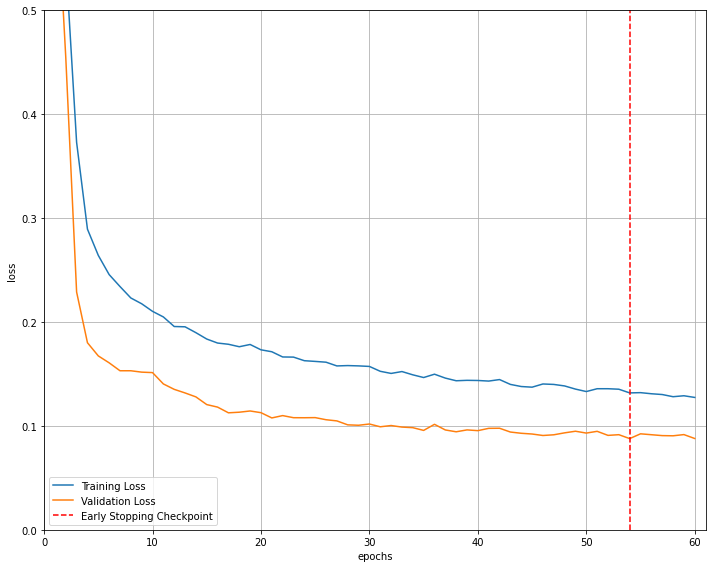

Dice2 score: 0.9596971784319196


In [ ]:
n_bs = [4]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "../Train/train_500"
model_chkpt_name = "ResNet-500x500_2layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

#### model(4layer) - 250x250 images

Batch size: 1, Learning rate: 0.001 , Epochs: 60



  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validation loss decreased (inf --> 0.141679).  Saving model ...


  2%|▏         | 1/60 [08:38<8:30:14, 518.89s/it]

Train Epoch: 1 @ 04:22:35.503259 - Train Loss: 0.1925 - Valid Loss: 0.1417
Validation loss decreased (0.141679 --> 0.102355).  Saving model ...


  3%|▎         | 2/60 [09:22<6:03:47, 376.33s/it]

Train Epoch: 2 @ 04:23:19.188925 - Train Loss: 0.1451 - Valid Loss: 0.1024
EarlyStopping counter: 1 out of 10


  5%|▌         | 3/60 [10:05<4:22:38, 276.46s/it]

Train Epoch: 3 @ 04:24:02.605069 - Train Loss: 0.1277 - Valid Loss: 0.1499
EarlyStopping counter: 2 out of 10


  7%|▋         | 4/60 [10:48<3:12:30, 206.27s/it]

Train Epoch: 4 @ 04:24:45.095135 - Train Loss: 0.1167 - Valid Loss: 0.1818
EarlyStopping counter: 3 out of 10


  8%|▊         | 5/60 [11:31<2:24:12, 157.32s/it]

Train Epoch: 5 @ 04:25:28.208624 - Train Loss: 0.1093 - Valid Loss: 0.1354
EarlyStopping counter: 4 out of 10


 10%|█         | 6/60 [12:14<1:50:44, 123.04s/it]

Train Epoch: 6 @ 04:26:11.252697 - Train Loss: 0.1016 - Valid Loss: 0.1098
Validation loss decreased (0.102355 --> 0.093431).  Saving model ...


 12%|█▏        | 7/60 [12:57<1:27:23, 98.93s/it] 

Train Epoch: 7 @ 04:26:53.927321 - Train Loss: 0.0988 - Valid Loss: 0.0934
Validation loss decreased (0.093431 --> 0.086994).  Saving model ...


 13%|█▎        | 8/60 [13:40<1:11:19, 82.30s/it]

Train Epoch: 8 @ 04:27:37.428232 - Train Loss: 0.0971 - Valid Loss: 0.0870
EarlyStopping counter: 1 out of 10


 15%|█▌        | 9/60 [14:24<1:00:00, 70.59s/it]

Train Epoch: 9 @ 04:28:20.704450 - Train Loss: 0.0906 - Valid Loss: 0.1155
EarlyStopping counter: 2 out of 10


 17%|█▋        | 10/60 [15:06<51:51, 62.22s/it] 

Train Epoch: 10 @ 04:29:03.391443 - Train Loss: 0.0900 - Valid Loss: 0.1036
Validation loss decreased (0.086994 --> 0.085818).  Saving model ...


 18%|█▊        | 11/60 [15:49<46:02, 56.39s/it]

Train Epoch: 11 @ 04:29:46.160538 - Train Loss: 0.0847 - Valid Loss: 0.0858
EarlyStopping counter: 1 out of 10


 20%|██        | 12/60 [16:33<42:00, 52.51s/it]

Train Epoch: 12 @ 04:30:29.629445 - Train Loss: 0.0824 - Valid Loss: 0.0861
EarlyStopping counter: 2 out of 10


 22%|██▏       | 13/60 [17:16<39:00, 49.79s/it]

Train Epoch: 13 @ 04:31:13.082464 - Train Loss: 0.0802 - Valid Loss: 0.1171
Validation loss decreased (0.085818 --> 0.083437).  Saving model ...


 23%|██▎       | 14/60 [17:59<36:35, 47.73s/it]

Train Epoch: 14 @ 04:31:56.002222 - Train Loss: 0.0788 - Valid Loss: 0.0834
EarlyStopping counter: 1 out of 10


 25%|██▌       | 15/60 [18:42<34:46, 46.37s/it]

Train Epoch: 15 @ 04:32:39.195336 - Train Loss: 0.0769 - Valid Loss: 0.0888
Validation loss decreased (0.083437 --> 0.082682).  Saving model ...


 27%|██▋       | 16/60 [19:26<33:24, 45.55s/it]

Train Epoch: 16 @ 04:33:22.848085 - Train Loss: 0.0779 - Valid Loss: 0.0827
Validation loss decreased (0.082682 --> 0.078678).  Saving model ...


 28%|██▊       | 17/60 [20:09<32:10, 44.90s/it]

Train Epoch: 17 @ 04:34:06.231063 - Train Loss: 0.0727 - Valid Loss: 0.0787
EarlyStopping counter: 1 out of 10


 30%|███       | 18/60 [20:53<31:13, 44.60s/it]

Train Epoch: 18 @ 04:34:50.114451 - Train Loss: 0.0750 - Valid Loss: 0.0914
EarlyStopping counter: 2 out of 10


 32%|███▏      | 19/60 [21:35<30:00, 43.92s/it]

Train Epoch: 19 @ 04:35:32.459256 - Train Loss: 0.0703 - Valid Loss: 0.0939
EarlyStopping counter: 3 out of 10


 33%|███▎      | 20/60 [22:18<29:07, 43.68s/it]

Train Epoch: 20 @ 04:36:15.577730 - Train Loss: 0.0701 - Valid Loss: 0.0854
EarlyStopping counter: 4 out of 10


 35%|███▌      | 21/60 [23:01<28:12, 43.38s/it]

Train Epoch: 21 @ 04:36:58.272498 - Train Loss: 0.0660 - Valid Loss: 0.0981
EarlyStopping counter: 5 out of 10


 37%|███▋      | 22/60 [23:44<27:20, 43.16s/it]

Train Epoch: 22 @ 04:37:40.901584 - Train Loss: 0.0662 - Valid Loss: 0.0860
EarlyStopping counter: 6 out of 10


 38%|███▊      | 23/60 [24:27<26:39, 43.23s/it]

Train Epoch: 23 @ 04:38:24.291864 - Train Loss: 0.0637 - Valid Loss: 0.1161
EarlyStopping counter: 7 out of 10


 40%|████      | 24/60 [25:10<25:51, 43.09s/it]

Train Epoch: 24 @ 04:39:07.069089 - Train Loss: 0.0609 - Valid Loss: 0.1209
EarlyStopping counter: 8 out of 10


 42%|████▏     | 25/60 [25:54<25:14, 43.27s/it]

Train Epoch: 25 @ 04:39:50.745550 - Train Loss: 0.0600 - Valid Loss: 0.0959
EarlyStopping counter: 9 out of 10


 43%|████▎     | 26/60 [26:36<24:24, 43.08s/it]

Train Epoch: 26 @ 04:40:33.390266 - Train Loss: 0.0611 - Valid Loss: 0.1118
EarlyStopping counter: 10 out of 10
Early stopping


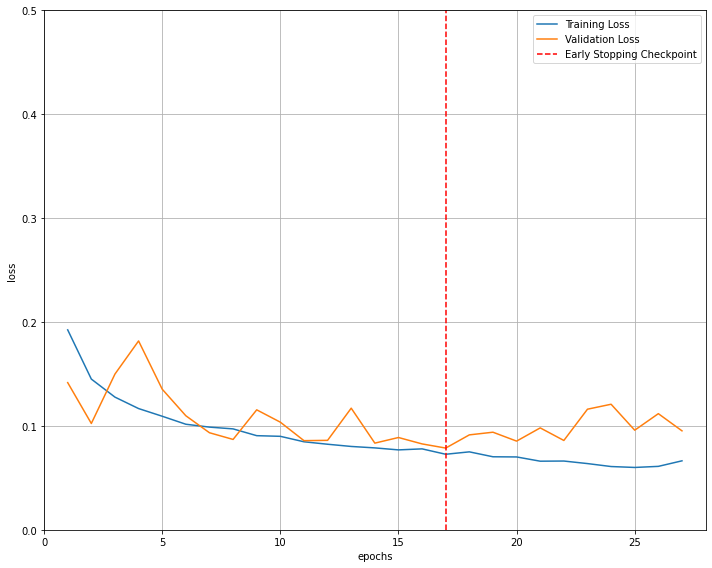

Dice2 score: 0.9325107308321221
Batch size: 1, Learning rate: 0.0001 , Epochs: 60




  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.142137).  Saving model ...



  2%|▏         | 1/60 [00:43<42:43, 43.44s/it]

Train Epoch: 1 @ 04:42:01.459451 - Train Loss: 0.2094 - Valid Loss: 0.1421
Validation loss decreased (0.142137 --> 0.107052).  Saving model ...



  3%|▎         | 2/60 [01:26<42:00, 43.45s/it]

Train Epoch: 2 @ 04:42:44.942083 - Train Loss: 0.1402 - Valid Loss: 0.1071
EarlyStopping counter: 1 out of 10



  5%|▌         | 3/60 [02:10<41:26, 43.63s/it]

Train Epoch: 3 @ 04:43:28.984599 - Train Loss: 0.1194 - Valid Loss: 0.1080
Validation loss decreased (0.107052 --> 0.098716).  Saving model ...



  7%|▋         | 4/60 [02:54<40:42, 43.61s/it]

Train Epoch: 4 @ 04:44:12.561785 - Train Loss: 0.1021 - Valid Loss: 0.0987
Validation loss decreased (0.098716 --> 0.091326).  Saving model ...



  8%|▊         | 5/60 [03:38<39:57, 43.59s/it]

Train Epoch: 5 @ 04:44:56.088029 - Train Loss: 0.0910 - Valid Loss: 0.0913
Validation loss decreased (0.091326 --> 0.087238).  Saving model ...



 10%|█         | 6/60 [04:22<39:29, 43.88s/it]

Train Epoch: 6 @ 04:45:40.665554 - Train Loss: 0.0831 - Valid Loss: 0.0872
EarlyStopping counter: 1 out of 10



 12%|█▏        | 7/60 [05:05<38:36, 43.71s/it]

Train Epoch: 7 @ 04:46:23.983272 - Train Loss: 0.0760 - Valid Loss: 0.0966
EarlyStopping counter: 2 out of 10



 13%|█▎        | 8/60 [05:49<37:45, 43.57s/it]

Train Epoch: 8 @ 04:47:07.225644 - Train Loss: 0.0707 - Valid Loss: 0.0937
EarlyStopping counter: 3 out of 10



 15%|█▌        | 9/60 [06:31<36:47, 43.28s/it]

Train Epoch: 9 @ 04:47:49.811734 - Train Loss: 0.0664 - Valid Loss: 0.1510
EarlyStopping counter: 4 out of 10



 17%|█▋        | 10/60 [07:14<35:59, 43.20s/it]

Train Epoch: 10 @ 04:48:32.821086 - Train Loss: 0.0631 - Valid Loss: 0.0924
EarlyStopping counter: 5 out of 10



 18%|█▊        | 11/60 [07:58<35:17, 43.21s/it]

Train Epoch: 11 @ 04:49:16.069041 - Train Loss: 0.0589 - Valid Loss: 0.0924
Validation loss decreased (0.087238 --> 0.086772).  Saving model ...



 20%|██        | 12/60 [08:40<34:30, 43.13s/it]

Train Epoch: 12 @ 04:49:59.009050 - Train Loss: 0.0552 - Valid Loss: 0.0868
EarlyStopping counter: 1 out of 10



 22%|██▏       | 13/60 [09:25<34:01, 43.43s/it]

Train Epoch: 13 @ 04:50:43.140698 - Train Loss: 0.0522 - Valid Loss: 0.0921
Validation loss decreased (0.086772 --> 0.086365).  Saving model ...



 23%|██▎       | 14/60 [10:08<33:15, 43.39s/it]

Train Epoch: 14 @ 04:51:26.437676 - Train Loss: 0.0497 - Valid Loss: 0.0864
EarlyStopping counter: 1 out of 10



 25%|██▌       | 15/60 [10:52<32:35, 43.45s/it]

Train Epoch: 15 @ 04:52:10.022439 - Train Loss: 0.0467 - Valid Loss: 0.0894
EarlyStopping counter: 2 out of 10



 27%|██▋       | 16/60 [11:34<31:42, 43.24s/it]

Train Epoch: 16 @ 04:52:52.780108 - Train Loss: 0.0456 - Valid Loss: 0.0869
EarlyStopping counter: 3 out of 10



 28%|██▊       | 17/60 [12:17<30:53, 43.11s/it]

Train Epoch: 17 @ 04:53:35.575360 - Train Loss: 0.0439 - Valid Loss: 0.0989
EarlyStopping counter: 4 out of 10



 30%|███       | 18/60 [13:00<30:12, 43.16s/it]

Train Epoch: 18 @ 04:54:18.842356 - Train Loss: 0.0417 - Valid Loss: 0.0920
EarlyStopping counter: 5 out of 10



 32%|███▏      | 19/60 [13:43<29:23, 43.02s/it]

Train Epoch: 19 @ 04:55:01.555339 - Train Loss: 0.0432 - Valid Loss: 0.0964
EarlyStopping counter: 6 out of 10



 33%|███▎      | 20/60 [14:26<28:40, 43.02s/it]

Train Epoch: 20 @ 04:55:44.556417 - Train Loss: 0.0425 - Valid Loss: 0.1026
EarlyStopping counter: 7 out of 10



 35%|███▌      | 21/60 [15:09<28:01, 43.11s/it]

Train Epoch: 21 @ 04:56:27.900072 - Train Loss: 0.0386 - Valid Loss: 0.0904
EarlyStopping counter: 8 out of 10



 37%|███▋      | 22/60 [15:53<27:24, 43.28s/it]

Train Epoch: 22 @ 04:57:11.575360 - Train Loss: 0.0368 - Valid Loss: 0.0933
EarlyStopping counter: 9 out of 10



 38%|███▊      | 23/60 [16:36<26:38, 43.20s/it]

Train Epoch: 23 @ 04:57:54.581099 - Train Loss: 0.0359 - Valid Loss: 0.1023
EarlyStopping counter: 10 out of 10
Early stopping


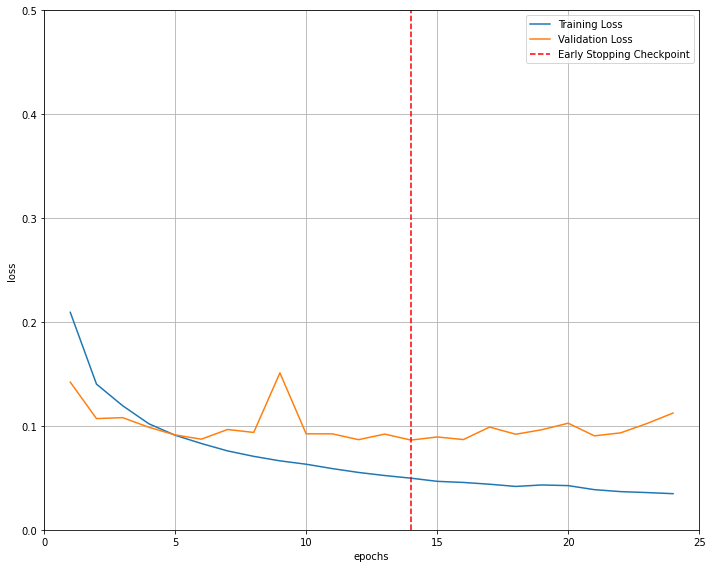

Dice2 score: 0.9281499108602834
Batch size: 1, Learning rate: 1e-05 , Epochs: 60





  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.209248).  Saving model ...




  2%|▏         | 1/60 [00:43<43:01, 43.76s/it]

Train Epoch: 1 @ 04:59:21.632570 - Train Loss: 0.3296 - Valid Loss: 0.2092
Validation loss decreased (0.209248 --> 0.169013).  Saving model ...




  3%|▎         | 2/60 [01:27<42:19, 43.79s/it]

Train Epoch: 2 @ 05:00:05.491816 - Train Loss: 0.2355 - Valid Loss: 0.1690
Validation loss decreased (0.169013 --> 0.159556).  Saving model ...




  5%|▌         | 3/60 [02:11<41:35, 43.78s/it]

Train Epoch: 3 @ 05:00:49.250723 - Train Loss: 0.1899 - Valid Loss: 0.1596
Validation loss decreased (0.159556 --> 0.153569).  Saving model ...




  7%|▋         | 4/60 [02:56<41:13, 44.16s/it]

Train Epoch: 4 @ 05:01:34.313192 - Train Loss: 0.1621 - Valid Loss: 0.1536
Validation loss decreased (0.153569 --> 0.149281).  Saving model ...




  8%|▊         | 5/60 [03:41<40:40, 44.37s/it]

Train Epoch: 5 @ 05:02:19.164593 - Train Loss: 0.1426 - Valid Loss: 0.1493
EarlyStopping counter: 1 out of 10




 10%|█         | 6/60 [04:25<39:45, 44.18s/it]

Train Epoch: 6 @ 05:03:02.889474 - Train Loss: 0.1304 - Valid Loss: 0.1670
EarlyStopping counter: 2 out of 10




 12%|█▏        | 7/60 [05:07<38:38, 43.74s/it]

Train Epoch: 7 @ 05:03:45.604020 - Train Loss: 0.1198 - Valid Loss: 0.1553
Validation loss decreased (0.149281 --> 0.142463).  Saving model ...




 13%|█▎        | 8/60 [05:51<38:00, 43.86s/it]

Train Epoch: 8 @ 05:04:29.737115 - Train Loss: 0.1109 - Valid Loss: 0.1425
EarlyStopping counter: 1 out of 10




 15%|█▌        | 9/60 [06:35<37:14, 43.82s/it]

Train Epoch: 9 @ 05:05:13.467811 - Train Loss: 0.1042 - Valid Loss: 0.1474
EarlyStopping counter: 2 out of 10




 17%|█▋        | 10/60 [07:18<36:13, 43.47s/it]

Train Epoch: 10 @ 05:05:56.122592 - Train Loss: 0.0985 - Valid Loss: 0.1685
EarlyStopping counter: 3 out of 10




 18%|█▊        | 11/60 [08:01<35:28, 43.44s/it]

Train Epoch: 11 @ 05:06:39.496977 - Train Loss: 0.0937 - Valid Loss: 0.1485
EarlyStopping counter: 4 out of 10




 20%|██        | 12/60 [08:45<34:48, 43.51s/it]

Train Epoch: 12 @ 05:07:23.151826 - Train Loss: 0.0893 - Valid Loss: 0.1488
EarlyStopping counter: 5 out of 10




 22%|██▏       | 13/60 [09:28<34:04, 43.50s/it]

Train Epoch: 13 @ 05:08:06.632343 - Train Loss: 0.0856 - Valid Loss: 0.1498
EarlyStopping counter: 6 out of 10




 23%|██▎       | 14/60 [10:12<33:18, 43.44s/it]

Train Epoch: 14 @ 05:08:49.944577 - Train Loss: 0.0810 - Valid Loss: 0.1440
EarlyStopping counter: 7 out of 10




 25%|██▌       | 15/60 [10:55<32:31, 43.37s/it]

Train Epoch: 15 @ 05:09:33.136215 - Train Loss: 0.0774 - Valid Loss: 0.1450
Validation loss decreased (0.142463 --> 0.133107).  Saving model ...




 27%|██▋       | 16/60 [11:39<31:57, 43.58s/it]

Train Epoch: 16 @ 05:10:17.202110 - Train Loss: 0.0739 - Valid Loss: 0.1331
Validation loss decreased (0.133107 --> 0.128101).  Saving model ...




 28%|██▊       | 17/60 [12:23<31:18, 43.70s/it]

Train Epoch: 17 @ 05:11:01.176563 - Train Loss: 0.0701 - Valid Loss: 0.1281
EarlyStopping counter: 1 out of 10




 30%|███       | 18/60 [13:06<30:34, 43.67s/it]

Train Epoch: 18 @ 05:11:44.800235 - Train Loss: 0.0671 - Valid Loss: 0.1397
EarlyStopping counter: 2 out of 10




 32%|███▏      | 19/60 [13:50<29:47, 43.59s/it]

Train Epoch: 19 @ 05:12:28.200510 - Train Loss: 0.0647 - Valid Loss: 0.1396
EarlyStopping counter: 3 out of 10




 33%|███▎      | 20/60 [14:33<29:01, 43.55s/it]

Train Epoch: 20 @ 05:13:11.640163 - Train Loss: 0.0624 - Valid Loss: 0.1343
EarlyStopping counter: 4 out of 10




 35%|███▌      | 21/60 [15:17<28:14, 43.46s/it]

Train Epoch: 21 @ 05:13:54.890405 - Train Loss: 0.0603 - Valid Loss: 0.1436
EarlyStopping counter: 5 out of 10




 37%|███▋      | 22/60 [15:59<27:24, 43.28s/it]

Train Epoch: 22 @ 05:14:37.752761 - Train Loss: 0.0590 - Valid Loss: 0.1525
EarlyStopping counter: 6 out of 10




 38%|███▊      | 23/60 [16:43<26:46, 43.41s/it]

Train Epoch: 23 @ 05:15:21.478489 - Train Loss: 0.0574 - Valid Loss: 0.1391
EarlyStopping counter: 7 out of 10




 40%|████      | 24/60 [17:27<26:04, 43.46s/it]

Train Epoch: 24 @ 05:16:05.049128 - Train Loss: 0.0554 - Valid Loss: 0.1557
EarlyStopping counter: 8 out of 10




 42%|████▏     | 25/60 [18:10<25:16, 43.34s/it]

Train Epoch: 25 @ 05:16:48.111349 - Train Loss: 0.0538 - Valid Loss: 0.1390
EarlyStopping counter: 9 out of 10




 43%|████▎     | 26/60 [18:53<24:36, 43.43s/it]

Train Epoch: 26 @ 05:17:31.762552 - Train Loss: 0.0521 - Valid Loss: 0.1342
EarlyStopping counter: 10 out of 10
Early stopping


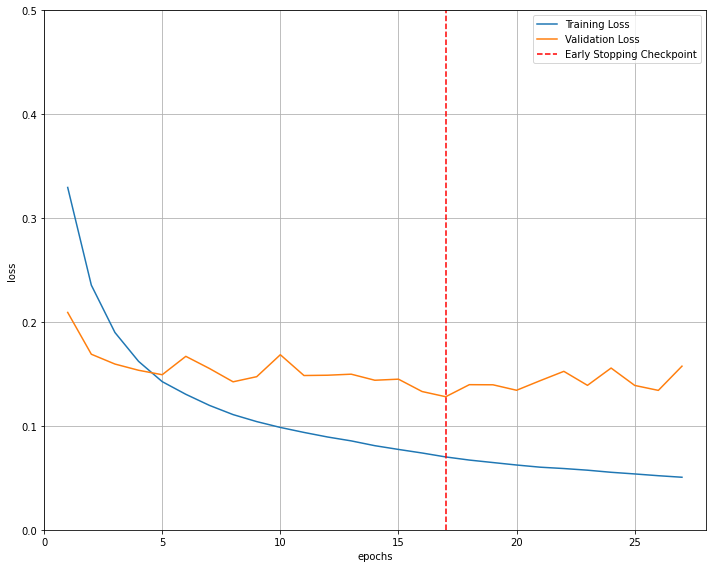

Dice2 score: 0.8919631603152253


In [ ]:
n_bs = [1]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_250"
model_chkpt_name = "ResNet-250x250_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

Batch size: 4, Learning rate: 0.001 , Epochs: 60



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validation loss decreased (inf --> 0.159538).  Saving model ...


  2%|▏         | 1/60 [08:36<8:28:22, 516.99s/it]

Train Epoch: 1 @ 01:27:11.763591 - Train Loss: 0.2409 - Valid Loss: 0.1595
Validation loss decreased (0.159538 --> 0.122862).  Saving model ...


  3%|▎         | 2/60 [09:01<5:56:49, 369.13s/it]

Train Epoch: 2 @ 01:27:35.886905 - Train Loss: 0.1511 - Valid Loss: 0.1229
Validation loss decreased (0.122862 --> 0.107056).  Saving model ...


  5%|▌         | 3/60 [09:25<4:12:27, 265.75s/it]

Train Epoch: 3 @ 01:28:00.433923 - Train Loss: 0.1364 - Valid Loss: 0.1071
EarlyStopping counter: 1 out of 10


  7%|▋         | 4/60 [09:49<3:00:12, 193.08s/it]

Train Epoch: 4 @ 01:28:23.957715 - Train Loss: 0.1223 - Valid Loss: 0.1128
Validation loss decreased (0.107056 --> 0.098493).  Saving model ...


  8%|▊         | 5/60 [10:13<2:10:34, 142.45s/it]

Train Epoch: 5 @ 01:28:48.253891 - Train Loss: 0.1190 - Valid Loss: 0.0985
Validation loss decreased (0.098493 --> 0.094236).  Saving model ...


 10%|█         | 6/60 [10:38<1:36:31, 107.24s/it]

Train Epoch: 6 @ 01:29:13.351868 - Train Loss: 0.1068 - Valid Loss: 0.0942
EarlyStopping counter: 1 out of 10


 12%|█▏        | 7/60 [11:02<1:12:37, 82.22s/it] 

Train Epoch: 7 @ 01:29:37.189753 - Train Loss: 0.1050 - Valid Loss: 0.0982
EarlyStopping counter: 2 out of 10


 13%|█▎        | 8/60 [11:26<56:08, 64.77s/it]  

Train Epoch: 8 @ 01:30:01.243517 - Train Loss: 0.1053 - Valid Loss: 0.0968
Validation loss decreased (0.094236 --> 0.093149).  Saving model ...


 15%|█▌        | 9/60 [11:50<44:38, 52.53s/it]

Train Epoch: 9 @ 01:30:25.209534 - Train Loss: 0.0987 - Valid Loss: 0.0931
EarlyStopping counter: 1 out of 10


 17%|█▋        | 10/60 [12:14<36:42, 44.05s/it]

Train Epoch: 10 @ 01:30:49.484629 - Train Loss: 0.0961 - Valid Loss: 0.0932
EarlyStopping counter: 2 out of 10


 18%|█▊        | 11/60 [12:38<30:58, 37.94s/it]

Train Epoch: 11 @ 01:31:13.145826 - Train Loss: 0.0935 - Valid Loss: 0.0976
Validation loss decreased (0.093149 --> 0.089430).  Saving model ...


 20%|██        | 12/60 [13:02<27:07, 33.90s/it]

Train Epoch: 12 @ 01:31:37.629910 - Train Loss: 0.0894 - Valid Loss: 0.0894
Validation loss decreased (0.089430 --> 0.084472).  Saving model ...


 22%|██▏       | 13/60 [13:27<24:23, 31.14s/it]

Train Epoch: 13 @ 01:32:02.342509 - Train Loss: 0.0879 - Valid Loss: 0.0845
EarlyStopping counter: 1 out of 10


 23%|██▎       | 14/60 [13:50<22:04, 28.79s/it]

Train Epoch: 14 @ 01:32:25.624427 - Train Loss: 0.0906 - Valid Loss: 0.0916
EarlyStopping counter: 2 out of 10


 25%|██▌       | 15/60 [14:14<20:30, 27.35s/it]

Train Epoch: 15 @ 01:32:49.613782 - Train Loss: 0.0897 - Valid Loss: 0.1049
Validation loss decreased (0.084472 --> 0.083555).  Saving model ...


 27%|██▋       | 16/60 [14:38<19:13, 26.23s/it]

Train Epoch: 16 @ 01:33:13.226535 - Train Loss: 0.0878 - Valid Loss: 0.0836
Validation loss decreased (0.083555 --> 0.079384).  Saving model ...


 28%|██▊       | 17/60 [15:03<18:29, 25.80s/it]

Train Epoch: 17 @ 01:33:38.032750 - Train Loss: 0.0832 - Valid Loss: 0.0794
EarlyStopping counter: 1 out of 10


 30%|███       | 18/60 [15:28<17:51, 25.51s/it]

Train Epoch: 18 @ 01:34:02.863069 - Train Loss: 0.0842 - Valid Loss: 0.0870
EarlyStopping counter: 2 out of 10


 32%|███▏      | 19/60 [15:51<17:04, 24.98s/it]

Train Epoch: 19 @ 01:34:26.616922 - Train Loss: 0.0868 - Valid Loss: 0.0827
EarlyStopping counter: 3 out of 10


 33%|███▎      | 20/60 [16:15<16:23, 24.59s/it]

Train Epoch: 20 @ 01:34:50.287770 - Train Loss: 0.0821 - Valid Loss: 0.0847
EarlyStopping counter: 4 out of 10


 35%|███▌      | 21/60 [16:38<15:43, 24.20s/it]

Train Epoch: 21 @ 01:35:13.564971 - Train Loss: 0.0857 - Valid Loss: 0.0800
EarlyStopping counter: 5 out of 10


 37%|███▋      | 22/60 [17:02<15:15, 24.10s/it]

Train Epoch: 22 @ 01:35:37.431942 - Train Loss: 0.0820 - Valid Loss: 0.0810
Validation loss decreased (0.079384 --> 0.076834).  Saving model ...


 38%|███▊      | 23/60 [17:26<14:52, 24.11s/it]

Train Epoch: 23 @ 01:36:01.586092 - Train Loss: 0.0812 - Valid Loss: 0.0768
EarlyStopping counter: 1 out of 10


 40%|████      | 24/60 [17:52<14:44, 24.57s/it]

Train Epoch: 24 @ 01:36:27.219079 - Train Loss: 0.0784 - Valid Loss: 0.0804
Validation loss decreased (0.076834 --> 0.075376).  Saving model ...


 42%|████▏     | 25/60 [18:17<14:21, 24.63s/it]

Train Epoch: 25 @ 01:36:51.982883 - Train Loss: 0.0771 - Valid Loss: 0.0754
EarlyStopping counter: 1 out of 10


 43%|████▎     | 26/60 [18:40<13:47, 24.33s/it]

Train Epoch: 26 @ 01:37:15.617989 - Train Loss: 0.0735 - Valid Loss: 0.0808
EarlyStopping counter: 2 out of 10


 45%|████▌     | 27/60 [19:04<13:17, 24.15s/it]

Train Epoch: 27 @ 01:37:39.352935 - Train Loss: 0.0720 - Valid Loss: 0.0763
EarlyStopping counter: 3 out of 10


 47%|████▋     | 28/60 [19:27<12:43, 23.87s/it]

Train Epoch: 28 @ 01:38:02.566030 - Train Loss: 0.0708 - Valid Loss: 0.0789
EarlyStopping counter: 4 out of 10


 48%|████▊     | 29/60 [19:51<12:16, 23.76s/it]

Train Epoch: 29 @ 01:38:26.074442 - Train Loss: 0.0704 - Valid Loss: 0.0818
EarlyStopping counter: 5 out of 10


 50%|█████     | 30/60 [20:15<11:57, 23.91s/it]

Train Epoch: 30 @ 01:38:50.330049 - Train Loss: 0.0741 - Valid Loss: 0.0880
EarlyStopping counter: 6 out of 10


 52%|█████▏    | 31/60 [20:38<11:27, 23.70s/it]

Train Epoch: 31 @ 01:39:13.540774 - Train Loss: 0.0773 - Valid Loss: 0.0820
EarlyStopping counter: 7 out of 10


 53%|█████▎    | 32/60 [21:02<11:06, 23.80s/it]

Train Epoch: 32 @ 01:39:37.578305 - Train Loss: 0.0769 - Valid Loss: 0.0876
EarlyStopping counter: 8 out of 10


 55%|█████▌    | 33/60 [21:26<10:42, 23.81s/it]

Train Epoch: 33 @ 01:40:01.394072 - Train Loss: 0.0721 - Valid Loss: 0.0804
EarlyStopping counter: 9 out of 10


 57%|█████▋    | 34/60 [21:50<10:20, 23.86s/it]

Train Epoch: 34 @ 01:40:25.383877 - Train Loss: 0.0688 - Valid Loss: 0.0976
EarlyStopping counter: 10 out of 10
Early stopping


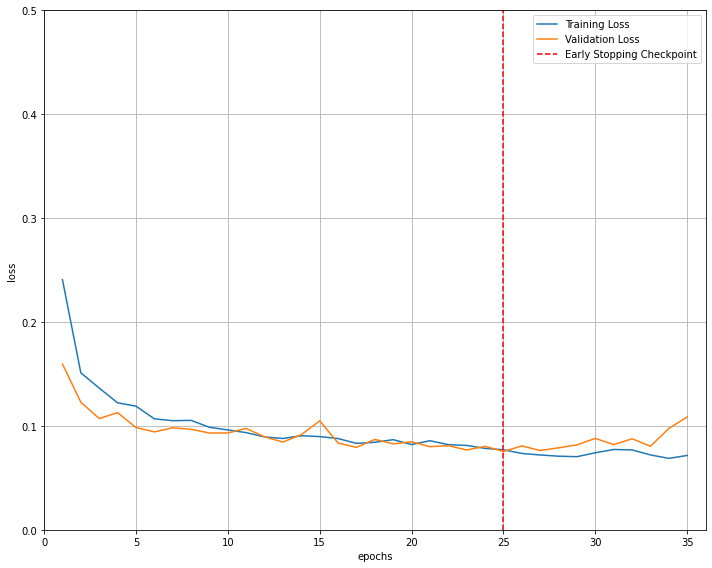

Dice2 score: 0.9453235973011364
Batch size: 4, Learning rate: 0.0001 , Epochs: 60




  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.175257).  Saving model ...



  2%|▏         | 1/60 [00:22<22:04, 22.46s/it]

Train Epoch: 1 @ 01:41:12.096887 - Train Loss: 0.2528 - Valid Loss: 0.1753
Validation loss decreased (0.175257 --> 0.139882).  Saving model ...



  3%|▎         | 2/60 [00:45<21:56, 22.70s/it]

Train Epoch: 2 @ 01:41:35.370485 - Train Loss: 0.1705 - Valid Loss: 0.1399
Validation loss decreased (0.139882 --> 0.125541).  Saving model ...



  5%|▌         | 3/60 [01:08<21:35, 22.74s/it]

Train Epoch: 3 @ 01:41:58.185861 - Train Loss: 0.1488 - Valid Loss: 0.1255
Validation loss decreased (0.125541 --> 0.114266).  Saving model ...



  7%|▋         | 4/60 [01:31<21:14, 22.76s/it]

Train Epoch: 4 @ 01:42:21.006350 - Train Loss: 0.1299 - Valid Loss: 0.1143
Validation loss decreased (0.114266 --> 0.102608).  Saving model ...



  8%|▊         | 5/60 [01:54<20:57, 22.86s/it]

Train Epoch: 5 @ 01:42:44.090950 - Train Loss: 0.1159 - Valid Loss: 0.1026
Validation loss decreased (0.102608 --> 0.101657).  Saving model ...



 10%|█         | 6/60 [02:17<20:33, 22.84s/it]

Train Epoch: 6 @ 01:43:06.873960 - Train Loss: 0.1088 - Valid Loss: 0.1017
Validation loss decreased (0.101657 --> 0.095215).  Saving model ...



 12%|█▏        | 7/60 [02:40<20:13, 22.90s/it]

Train Epoch: 7 @ 01:43:29.931999 - Train Loss: 0.1006 - Valid Loss: 0.0952
Validation loss decreased (0.095215 --> 0.092334).  Saving model ...



 13%|█▎        | 8/60 [03:03<19:53, 22.96s/it]

Train Epoch: 8 @ 01:43:53.016055 - Train Loss: 0.0948 - Valid Loss: 0.0923
Validation loss decreased (0.092334 --> 0.091777).  Saving model ...



 15%|█▌        | 9/60 [03:26<19:28, 22.91s/it]

Train Epoch: 9 @ 01:44:15.814053 - Train Loss: 0.0873 - Valid Loss: 0.0918
Validation loss decreased (0.091777 --> 0.089494).  Saving model ...



 17%|█▋        | 10/60 [03:52<19:53, 23.86s/it]

Train Epoch: 10 @ 01:44:41.893848 - Train Loss: 0.0878 - Valid Loss: 0.0895
Validation loss decreased (0.089494 --> 0.088124).  Saving model ...



 18%|█▊        | 11/60 [04:15<19:21, 23.70s/it]

Train Epoch: 11 @ 01:45:05.212649 - Train Loss: 0.0828 - Valid Loss: 0.0881
Validation loss decreased (0.088124 --> 0.087878).  Saving model ...



 20%|██        | 12/60 [04:39<18:55, 23.65s/it]

Train Epoch: 12 @ 01:45:28.763008 - Train Loss: 0.0798 - Valid Loss: 0.0879
Validation loss decreased (0.087878 --> 0.086095).  Saving model ...



 22%|██▏       | 13/60 [05:01<18:17, 23.36s/it]

Train Epoch: 13 @ 01:45:51.436014 - Train Loss: 0.0750 - Valid Loss: 0.0861
EarlyStopping counter: 1 out of 10



 23%|██▎       | 14/60 [05:24<17:43, 23.12s/it]

Train Epoch: 14 @ 01:46:13.990443 - Train Loss: 0.0736 - Valid Loss: 0.0900
Validation loss decreased (0.086095 --> 0.083504).  Saving model ...



 25%|██▌       | 15/60 [05:47<17:17, 23.06s/it]

Train Epoch: 15 @ 01:46:36.908840 - Train Loss: 0.0689 - Valid Loss: 0.0835
EarlyStopping counter: 1 out of 10



 27%|██▋       | 16/60 [06:09<16:42, 22.79s/it]

Train Epoch: 16 @ 01:46:59.073072 - Train Loss: 0.0659 - Valid Loss: 0.0841
EarlyStopping counter: 2 out of 10



 28%|██▊       | 17/60 [06:31<16:15, 22.70s/it]

Train Epoch: 17 @ 01:47:21.554075 - Train Loss: 0.0653 - Valid Loss: 0.0865
EarlyStopping counter: 3 out of 10



 30%|███       | 18/60 [06:54<15:50, 22.64s/it]

Train Epoch: 18 @ 01:47:44.058465 - Train Loss: 0.0642 - Valid Loss: 0.0870
Validation loss decreased (0.083504 --> 0.083262).  Saving model ...



 32%|███▏      | 19/60 [07:17<15:28, 22.65s/it]

Train Epoch: 19 @ 01:48:06.745288 - Train Loss: 0.0615 - Valid Loss: 0.0833
EarlyStopping counter: 1 out of 10



 33%|███▎      | 20/60 [07:39<15:08, 22.70s/it]

Train Epoch: 20 @ 01:48:29.564718 - Train Loss: 0.0588 - Valid Loss: 0.0847
EarlyStopping counter: 2 out of 10



 35%|███▌      | 21/60 [08:02<14:43, 22.64s/it]

Train Epoch: 21 @ 01:48:52.072008 - Train Loss: 0.0567 - Valid Loss: 0.0873
EarlyStopping counter: 3 out of 10



 37%|███▋      | 22/60 [08:24<14:16, 22.53s/it]

Train Epoch: 22 @ 01:49:14.327617 - Train Loss: 0.0544 - Valid Loss: 0.0862
EarlyStopping counter: 4 out of 10



 38%|███▊      | 23/60 [08:47<13:54, 22.56s/it]

Train Epoch: 23 @ 01:49:36.941889 - Train Loss: 0.0536 - Valid Loss: 0.0845
EarlyStopping counter: 5 out of 10



 40%|████      | 24/60 [09:09<13:30, 22.52s/it]

Train Epoch: 24 @ 01:49:59.370379 - Train Loss: 0.0504 - Valid Loss: 0.0848
EarlyStopping counter: 6 out of 10



 42%|████▏     | 25/60 [09:32<13:06, 22.47s/it]

Train Epoch: 25 @ 01:50:21.719902 - Train Loss: 0.0508 - Valid Loss: 0.0918
EarlyStopping counter: 7 out of 10



 43%|████▎     | 26/60 [09:54<12:46, 22.53s/it]

Train Epoch: 26 @ 01:50:44.406755 - Train Loss: 0.0488 - Valid Loss: 0.0881
EarlyStopping counter: 8 out of 10



 45%|████▌     | 27/60 [10:17<12:24, 22.55s/it]

Train Epoch: 27 @ 01:51:06.996178 - Train Loss: 0.0474 - Valid Loss: 0.0915
EarlyStopping counter: 9 out of 10



 47%|████▋     | 28/60 [10:40<12:03, 22.62s/it]

Train Epoch: 28 @ 01:51:29.786535 - Train Loss: 0.0465 - Valid Loss: 0.0874
EarlyStopping counter: 10 out of 10
Early stopping


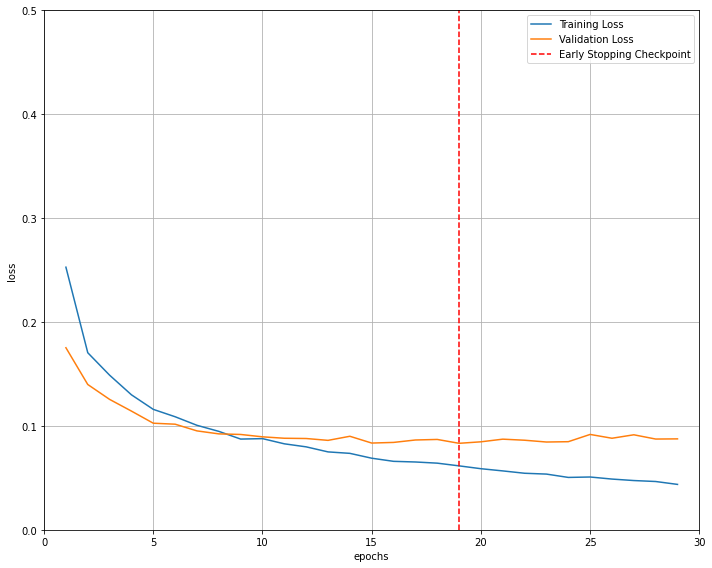

Dice2 score: 0.9434557828036222
Batch size: 4, Learning rate: 1e-05 , Epochs: 60





  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.222451).  Saving model ...




  2%|▏         | 1/60 [00:22<22:19, 22.70s/it]

Train Epoch: 1 @ 01:52:15.549695 - Train Loss: 0.3885 - Valid Loss: 0.2225
Validation loss decreased (0.222451 --> 0.211828).  Saving model ...




  3%|▎         | 2/60 [00:47<22:26, 23.21s/it]

Train Epoch: 2 @ 01:52:39.936946 - Train Loss: 0.2366 - Valid Loss: 0.2118
Validation loss decreased (0.211828 --> 0.211532).  Saving model ...




  5%|▌         | 3/60 [01:10<22:00, 23.17s/it]

Train Epoch: 3 @ 01:53:03.019804 - Train Loss: 0.2206 - Valid Loss: 0.2115
Validation loss decreased (0.211532 --> 0.185072).  Saving model ...




  7%|▋         | 4/60 [01:33<21:41, 23.24s/it]

Train Epoch: 4 @ 01:53:26.428148 - Train Loss: 0.2038 - Valid Loss: 0.1851
Validation loss decreased (0.185072 --> 0.173807).  Saving model ...




  8%|▊         | 5/60 [01:56<21:18, 23.25s/it]

Train Epoch: 5 @ 01:53:49.709665 - Train Loss: 0.1870 - Valid Loss: 0.1738
Validation loss decreased (0.173807 --> 0.158145).  Saving model ...




 10%|█         | 6/60 [02:19<20:53, 23.21s/it]

Train Epoch: 6 @ 01:54:12.830659 - Train Loss: 0.1717 - Valid Loss: 0.1581
Validation loss decreased (0.158145 --> 0.152119).  Saving model ...




 12%|█▏        | 7/60 [02:43<20:33, 23.28s/it]

Train Epoch: 7 @ 01:54:36.253923 - Train Loss: 0.1619 - Valid Loss: 0.1521
Validation loss decreased (0.152119 --> 0.134088).  Saving model ...




 13%|█▎        | 8/60 [03:07<20:18, 23.44s/it]

Train Epoch: 8 @ 01:55:00.065628 - Train Loss: 0.1521 - Valid Loss: 0.1341
Validation loss decreased (0.134088 --> 0.124437).  Saving model ...




 15%|█▌        | 9/60 [03:30<19:49, 23.33s/it]

Train Epoch: 9 @ 01:55:23.156455 - Train Loss: 0.1439 - Valid Loss: 0.1244
EarlyStopping counter: 1 out of 10




 17%|█▋        | 10/60 [03:53<19:25, 23.32s/it]

Train Epoch: 10 @ 01:55:46.445516 - Train Loss: 0.1418 - Valid Loss: 0.1285
Validation loss decreased (0.124437 --> 0.119340).  Saving model ...




 18%|█▊        | 11/60 [04:17<19:04, 23.36s/it]

Train Epoch: 11 @ 01:56:09.896516 - Train Loss: 0.1354 - Valid Loss: 0.1193
Validation loss decreased (0.119340 --> 0.115864).  Saving model ...




 20%|██        | 12/60 [04:40<18:41, 23.37s/it]

Train Epoch: 12 @ 01:56:33.298969 - Train Loss: 0.1303 - Valid Loss: 0.1159
EarlyStopping counter: 1 out of 10




 22%|██▏       | 13/60 [05:03<18:07, 23.15s/it]

Train Epoch: 13 @ 01:56:55.920850 - Train Loss: 0.1262 - Valid Loss: 0.1191
EarlyStopping counter: 2 out of 10




 23%|██▎       | 14/60 [05:25<17:38, 23.01s/it]

Train Epoch: 14 @ 01:57:18.597941 - Train Loss: 0.1232 - Valid Loss: 0.1170
Validation loss decreased (0.115864 --> 0.113116).  Saving model ...




 25%|██▌       | 15/60 [05:48<17:17, 23.05s/it]

Train Epoch: 15 @ 01:57:41.751773 - Train Loss: 0.1181 - Valid Loss: 0.1131
Validation loss decreased (0.113116 --> 0.110005).  Saving model ...




 27%|██▋       | 16/60 [06:11<16:54, 23.06s/it]

Train Epoch: 16 @ 01:58:04.835132 - Train Loss: 0.1150 - Valid Loss: 0.1100
Validation loss decreased (0.110005 --> 0.109953).  Saving model ...




 28%|██▊       | 17/60 [06:35<16:38, 23.23s/it]

Train Epoch: 17 @ 01:58:28.460093 - Train Loss: 0.1131 - Valid Loss: 0.1100
Validation loss decreased (0.109953 --> 0.108467).  Saving model ...




 30%|███       | 18/60 [06:58<16:16, 23.25s/it]

Train Epoch: 18 @ 01:58:51.747265 - Train Loss: 0.1087 - Valid Loss: 0.1085
EarlyStopping counter: 1 out of 10




 32%|███▏      | 19/60 [07:21<15:43, 23.02s/it]

Train Epoch: 19 @ 01:59:14.237087 - Train Loss: 0.1112 - Valid Loss: 0.1094
EarlyStopping counter: 2 out of 10




 33%|███▎      | 20/60 [07:44<15:19, 22.99s/it]

Train Epoch: 20 @ 01:59:37.171710 - Train Loss: 0.1045 - Valid Loss: 0.1117
Validation loss decreased (0.108467 --> 0.106783).  Saving model ...




 35%|███▌      | 21/60 [08:07<14:56, 22.99s/it]

Train Epoch: 21 @ 02:00:00.135593 - Train Loss: 0.1058 - Valid Loss: 0.1068
Validation loss decreased (0.106783 --> 0.106288).  Saving model ...




 37%|███▋      | 22/60 [08:30<14:34, 23.01s/it]

Train Epoch: 22 @ 02:00:23.191137 - Train Loss: 0.1029 - Valid Loss: 0.1063
Validation loss decreased (0.106288 --> 0.104438).  Saving model ...




 38%|███▊      | 23/60 [08:54<14:20, 23.24s/it]

Train Epoch: 23 @ 02:00:46.990380 - Train Loss: 0.0994 - Valid Loss: 0.1044
Validation loss decreased (0.104438 --> 0.103889).  Saving model ...




 40%|████      | 24/60 [09:17<13:57, 23.25s/it]

Train Epoch: 24 @ 02:01:10.261999 - Train Loss: 0.0996 - Valid Loss: 0.1039
EarlyStopping counter: 1 out of 10




 42%|████▏     | 25/60 [09:41<13:39, 23.41s/it]

Train Epoch: 25 @ 02:01:34.025793 - Train Loss: 0.0957 - Valid Loss: 0.1057
EarlyStopping counter: 2 out of 10




 43%|████▎     | 26/60 [10:04<13:10, 23.24s/it]

Train Epoch: 26 @ 02:01:56.859028 - Train Loss: 0.0951 - Valid Loss: 0.1057
Validation loss decreased (0.103889 --> 0.103186).  Saving model ...




 45%|████▌     | 27/60 [10:27<12:48, 23.27s/it]

Train Epoch: 27 @ 02:02:20.230173 - Train Loss: 0.0934 - Valid Loss: 0.1032
Validation loss decreased (0.103186 --> 0.102141).  Saving model ...




 47%|████▋     | 28/60 [10:50<12:25, 23.28s/it]

Train Epoch: 28 @ 02:02:43.534550 - Train Loss: 0.0919 - Valid Loss: 0.1021
Validation loss decreased (0.102141 --> 0.101979).  Saving model ...




 48%|████▊     | 29/60 [11:13<11:59, 23.21s/it]

Train Epoch: 29 @ 02:03:06.559544 - Train Loss: 0.0915 - Valid Loss: 0.1020
Validation loss decreased (0.101979 --> 0.101491).  Saving model ...




 50%|█████     | 30/60 [11:37<11:41, 23.37s/it]

Train Epoch: 30 @ 02:03:30.306204 - Train Loss: 0.0900 - Valid Loss: 0.1015
Validation loss decreased (0.101491 --> 0.101350).  Saving model ...




 52%|█████▏    | 31/60 [12:00<11:17, 23.34s/it]

Train Epoch: 31 @ 02:03:53.596627 - Train Loss: 0.0888 - Valid Loss: 0.1014
EarlyStopping counter: 1 out of 10




 53%|█████▎    | 32/60 [12:23<10:46, 23.10s/it]

Train Epoch: 32 @ 02:04:16.129706 - Train Loss: 0.0884 - Valid Loss: 0.1037
EarlyStopping counter: 2 out of 10




 55%|█████▌    | 33/60 [12:46<10:22, 23.04s/it]

Train Epoch: 33 @ 02:04:39.038032 - Train Loss: 0.0883 - Valid Loss: 0.1044
EarlyStopping counter: 3 out of 10




 57%|█████▋    | 34/60 [13:08<09:52, 22.81s/it]

Train Epoch: 34 @ 02:05:01.288668 - Train Loss: 0.0853 - Valid Loss: 0.1014
EarlyStopping counter: 4 out of 10




 58%|█████▊    | 35/60 [13:33<09:47, 23.48s/it]

Train Epoch: 35 @ 02:05:26.344591 - Train Loss: 0.0849 - Valid Loss: 0.1037
EarlyStopping counter: 5 out of 10




 60%|██████    | 36/60 [13:57<09:29, 23.75s/it]

Train Epoch: 36 @ 02:05:50.716958 - Train Loss: 0.0829 - Valid Loss: 0.1026
EarlyStopping counter: 6 out of 10




 62%|██████▏   | 37/60 [14:21<09:07, 23.82s/it]

Train Epoch: 37 @ 02:06:14.710838 - Train Loss: 0.0831 - Valid Loss: 0.1017
Validation loss decreased (0.101350 --> 0.101251).  Saving model ...




 63%|██████▎   | 38/60 [14:48<09:00, 24.57s/it]

Train Epoch: 38 @ 02:06:41.030131 - Train Loss: 0.0841 - Valid Loss: 0.1013
EarlyStopping counter: 1 out of 10




 65%|██████▌   | 39/60 [15:12<08:34, 24.49s/it]

Train Epoch: 39 @ 02:07:05.322833 - Train Loss: 0.0812 - Valid Loss: 0.1024
Validation loss decreased (0.101251 --> 0.100583).  Saving model ...




 67%|██████▋   | 40/60 [15:36<08:09, 24.47s/it]

Train Epoch: 40 @ 02:07:29.751639 - Train Loss: 0.0830 - Valid Loss: 0.1006
EarlyStopping counter: 1 out of 10




 68%|██████▊   | 41/60 [16:01<07:48, 24.65s/it]

Train Epoch: 41 @ 02:07:54.809428 - Train Loss: 0.0810 - Valid Loss: 0.1025
Validation loss decreased (0.100583 --> 0.099065).  Saving model ...




 70%|███████   | 42/60 [16:26<07:23, 24.62s/it]

Train Epoch: 42 @ 02:08:19.365473 - Train Loss: 0.0776 - Valid Loss: 0.0991
EarlyStopping counter: 1 out of 10




 72%|███████▏  | 43/60 [16:52<07:06, 25.06s/it]

Train Epoch: 43 @ 02:08:45.454146 - Train Loss: 0.0781 - Valid Loss: 0.1018
Validation loss decreased (0.099065 --> 0.098635).  Saving model ...




 73%|███████▎  | 44/60 [17:17<06:38, 24.92s/it]

Train Epoch: 44 @ 02:09:10.036036 - Train Loss: 0.0759 - Valid Loss: 0.0986
EarlyStopping counter: 1 out of 10




 75%|███████▌  | 45/60 [17:42<06:14, 24.95s/it]

Train Epoch: 45 @ 02:09:35.080452 - Train Loss: 0.0757 - Valid Loss: 0.1015
EarlyStopping counter: 2 out of 10




 77%|███████▋  | 46/60 [18:06<05:47, 24.79s/it]

Train Epoch: 46 @ 02:09:59.481514 - Train Loss: 0.0743 - Valid Loss: 0.1006
EarlyStopping counter: 3 out of 10




 78%|███████▊  | 47/60 [18:30<05:18, 24.49s/it]

Train Epoch: 47 @ 02:10:23.268773 - Train Loss: 0.0745 - Valid Loss: 0.1017
EarlyStopping counter: 4 out of 10




 80%|████████  | 48/60 [18:54<04:52, 24.40s/it]

Train Epoch: 48 @ 02:10:47.468925 - Train Loss: 0.0740 - Valid Loss: 0.0986
Validation loss decreased (0.098635 --> 0.097907).  Saving model ...




 82%|████████▏ | 49/60 [19:18<04:27, 24.31s/it]

Train Epoch: 49 @ 02:11:11.573615 - Train Loss: 0.0726 - Valid Loss: 0.0979
EarlyStopping counter: 1 out of 10




 83%|████████▎ | 50/60 [19:43<04:04, 24.43s/it]

Train Epoch: 50 @ 02:11:36.287005 - Train Loss: 0.0762 - Valid Loss: 0.0984
Validation loss decreased (0.097907 --> 0.096388).  Saving model ...




 85%|████████▌ | 51/60 [20:09<03:43, 24.81s/it]

Train Epoch: 51 @ 02:12:01.972238 - Train Loss: 0.0722 - Valid Loss: 0.0964
EarlyStopping counter: 1 out of 10




 87%|████████▋ | 52/60 [20:35<03:21, 25.18s/it]

Train Epoch: 52 @ 02:12:28.009035 - Train Loss: 0.0711 - Valid Loss: 0.0997
EarlyStopping counter: 2 out of 10




 88%|████████▊ | 53/60 [20:59<02:54, 24.94s/it]

Train Epoch: 53 @ 02:12:52.400682 - Train Loss: 0.0699 - Valid Loss: 0.1004
EarlyStopping counter: 3 out of 10




 90%|█████████ | 54/60 [21:23<02:28, 24.68s/it]

Train Epoch: 54 @ 02:13:16.463750 - Train Loss: 0.0687 - Valid Loss: 0.0982
EarlyStopping counter: 4 out of 10




 92%|█████████▏| 55/60 [21:47<02:02, 24.57s/it]

Train Epoch: 55 @ 02:13:40.772706 - Train Loss: 0.0704 - Valid Loss: 0.0967
EarlyStopping counter: 5 out of 10




 93%|█████████▎| 56/60 [22:11<01:37, 24.27s/it]

Train Epoch: 56 @ 02:14:04.334775 - Train Loss: 0.0683 - Valid Loss: 0.0997
EarlyStopping counter: 6 out of 10




 95%|█████████▌| 57/60 [22:36<01:13, 24.36s/it]

Train Epoch: 57 @ 02:14:28.900649 - Train Loss: 0.0666 - Valid Loss: 0.0995
EarlyStopping counter: 7 out of 10




 97%|█████████▋| 58/60 [23:01<00:49, 24.68s/it]

Train Epoch: 58 @ 02:14:54.345338 - Train Loss: 0.0665 - Valid Loss: 0.0975
EarlyStopping counter: 8 out of 10




 98%|█████████▊| 59/60 [23:25<00:24, 24.36s/it]

Train Epoch: 59 @ 02:15:17.954374 - Train Loss: 0.0663 - Valid Loss: 0.0988
EarlyStopping counter: 9 out of 10




100%|██████████| 60/60 [23:49<00:00, 23.83s/it]

Train Epoch: 60 @ 02:15:42.677078 - Train Loss: 0.0651 - Valid Loss: 0.0973


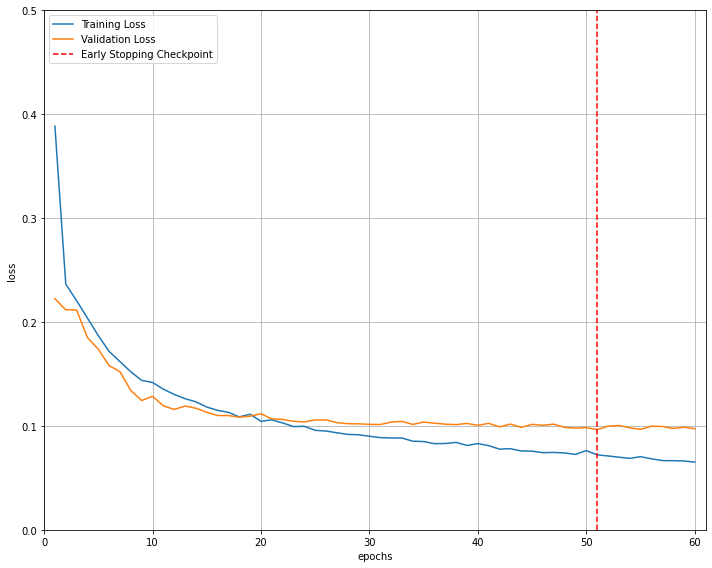

Dice2 score: 0.9342124245383523


In [ ]:
n_bs = [4]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_250"
model_chkpt_name = "ResNet-250x250_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

Batch size: 8, Learning rate: 0.001 , Epochs: 60





  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.160501).  Saving model ...




  2%|▏         | 1/60 [00:20<20:15, 20.60s/it]

Train Epoch: 1 @ 08:37:48.281473 - Train Loss: 0.2510 - Valid Loss: 0.1605
Validation loss decreased (0.160501 --> 0.142209).  Saving model ...




  3%|▎         | 2/60 [00:41<20:01, 20.72s/it]

Train Epoch: 2 @ 08:38:09.279532 - Train Loss: 0.1587 - Valid Loss: 0.1422
Validation loss decreased (0.142209 --> 0.126204).  Saving model ...




  5%|▌         | 3/60 [01:02<19:47, 20.84s/it]

Train Epoch: 3 @ 08:38:30.396225 - Train Loss: 0.1383 - Valid Loss: 0.1262
Validation loss decreased (0.126204 --> 0.113586).  Saving model ...




  7%|▋         | 4/60 [01:23<19:28, 20.87s/it]

Train Epoch: 4 @ 08:38:51.335985 - Train Loss: 0.1357 - Valid Loss: 0.1136
EarlyStopping counter: 1 out of 10




  8%|▊         | 5/60 [01:44<19:00, 20.73s/it]

Train Epoch: 5 @ 08:39:11.737407 - Train Loss: 0.1257 - Valid Loss: 0.1153
Validation loss decreased (0.113586 --> 0.104612).  Saving model ...




 10%|█         | 6/60 [02:05<18:43, 20.80s/it]

Train Epoch: 6 @ 08:39:32.693767 - Train Loss: 0.1238 - Valid Loss: 0.1046
Validation loss decreased (0.104612 --> 0.102693).  Saving model ...




 12%|█▏        | 7/60 [02:28<18:58, 21.48s/it]

Train Epoch: 7 @ 08:39:55.759094 - Train Loss: 0.1115 - Valid Loss: 0.1027
EarlyStopping counter: 1 out of 10




 13%|█▎        | 8/60 [02:48<18:19, 21.15s/it]

Train Epoch: 8 @ 08:40:16.148027 - Train Loss: 0.1086 - Valid Loss: 0.1168
EarlyStopping counter: 2 out of 10




 15%|█▌        | 9/60 [03:08<17:42, 20.84s/it]

Train Epoch: 9 @ 08:40:36.271373 - Train Loss: 0.1103 - Valid Loss: 0.1073
Validation loss decreased (0.102693 --> 0.090891).  Saving model ...




 17%|█▋        | 10/60 [03:29<17:26, 20.93s/it]

Train Epoch: 10 @ 08:40:57.400427 - Train Loss: 0.1093 - Valid Loss: 0.0909
EarlyStopping counter: 1 out of 10




 18%|█▊        | 11/60 [03:50<16:56, 20.74s/it]

Train Epoch: 11 @ 08:41:17.699709 - Train Loss: 0.1046 - Valid Loss: 0.1174
Validation loss decreased (0.090891 --> 0.085112).  Saving model ...




 20%|██        | 12/60 [04:10<16:34, 20.71s/it]

Train Epoch: 12 @ 08:41:38.341236 - Train Loss: 0.0992 - Valid Loss: 0.0851
EarlyStopping counter: 1 out of 10




 22%|██▏       | 13/60 [04:31<16:09, 20.62s/it]

Train Epoch: 13 @ 08:41:58.752229 - Train Loss: 0.0978 - Valid Loss: 0.0871
EarlyStopping counter: 2 out of 10




 23%|██▎       | 14/60 [04:51<15:46, 20.57s/it]

Train Epoch: 14 @ 08:42:19.198202 - Train Loss: 0.0904 - Valid Loss: 0.0978
EarlyStopping counter: 3 out of 10




 25%|██▌       | 15/60 [05:11<15:18, 20.41s/it]

Train Epoch: 15 @ 08:42:39.226613 - Train Loss: 0.0946 - Valid Loss: 0.0868
EarlyStopping counter: 4 out of 10




 27%|██▋       | 16/60 [05:31<14:54, 20.32s/it]

Train Epoch: 16 @ 08:42:59.346155 - Train Loss: 0.0915 - Valid Loss: 0.1061
Validation loss decreased (0.085112 --> 0.082641).  Saving model ...




 28%|██▊       | 17/60 [05:53<14:58, 20.90s/it]

Train Epoch: 17 @ 08:43:21.613660 - Train Loss: 0.0869 - Valid Loss: 0.0826
EarlyStopping counter: 1 out of 10




 30%|███       | 18/60 [06:14<14:27, 20.66s/it]

Train Epoch: 18 @ 08:43:41.705668 - Train Loss: 0.0890 - Valid Loss: 0.0847
EarlyStopping counter: 2 out of 10




 32%|███▏      | 19/60 [06:34<14:00, 20.49s/it]

Train Epoch: 19 @ 08:44:01.806459 - Train Loss: 0.0907 - Valid Loss: 0.1138
EarlyStopping counter: 3 out of 10




 33%|███▎      | 20/60 [06:54<13:36, 20.41s/it]

Train Epoch: 20 @ 08:44:22.024979 - Train Loss: 0.0868 - Valid Loss: 0.0993
Validation loss decreased (0.082641 --> 0.080830).  Saving model ...




 35%|███▌      | 21/60 [07:14<13:18, 20.47s/it]

Train Epoch: 21 @ 08:44:42.642843 - Train Loss: 0.0815 - Valid Loss: 0.0808
EarlyStopping counter: 1 out of 10




 37%|███▋      | 22/60 [07:35<12:55, 20.41s/it]

Train Epoch: 22 @ 08:45:02.916262 - Train Loss: 0.0852 - Valid Loss: 0.1014
EarlyStopping counter: 2 out of 10




 38%|███▊      | 23/60 [07:55<12:28, 20.24s/it]

Train Epoch: 23 @ 08:45:22.737192 - Train Loss: 0.0870 - Valid Loss: 0.0883
EarlyStopping counter: 3 out of 10




 40%|████      | 24/60 [08:15<12:05, 20.16s/it]

Train Epoch: 24 @ 08:45:42.734798 - Train Loss: 0.0862 - Valid Loss: 0.0864
Validation loss decreased (0.080830 --> 0.079045).  Saving model ...




 42%|████▏     | 25/60 [08:35<11:51, 20.33s/it]

Train Epoch: 25 @ 08:46:03.457073 - Train Loss: 0.0812 - Valid Loss: 0.0790
EarlyStopping counter: 1 out of 10




 43%|████▎     | 26/60 [08:55<11:28, 20.24s/it]

Train Epoch: 26 @ 08:46:23.479938 - Train Loss: 0.0813 - Valid Loss: 0.0812
EarlyStopping counter: 2 out of 10




 45%|████▌     | 27/60 [09:15<11:04, 20.15s/it]

Train Epoch: 27 @ 08:46:43.405482 - Train Loss: 0.0807 - Valid Loss: 0.0867
Validation loss decreased (0.079045 --> 0.077410).  Saving model ...




 47%|████▋     | 28/60 [09:37<10:55, 20.49s/it]

Train Epoch: 28 @ 08:47:04.672555 - Train Loss: 0.0764 - Valid Loss: 0.0774
EarlyStopping counter: 1 out of 10




 48%|████▊     | 29/60 [09:57<10:32, 20.41s/it]

Train Epoch: 29 @ 08:47:24.915575 - Train Loss: 0.0764 - Valid Loss: 0.0900
EarlyStopping counter: 2 out of 10




 50%|█████     | 30/60 [10:17<10:09, 20.31s/it]

Train Epoch: 30 @ 08:47:44.999626 - Train Loss: 0.0745 - Valid Loss: 0.0820
Validation loss decreased (0.077410 --> 0.075677).  Saving model ...




 52%|█████▏    | 31/60 [10:38<09:54, 20.49s/it]

Train Epoch: 31 @ 08:48:05.916418 - Train Loss: 0.0728 - Valid Loss: 0.0757
EarlyStopping counter: 1 out of 10




 53%|█████▎    | 32/60 [10:58<09:34, 20.51s/it]

Train Epoch: 32 @ 08:48:26.459564 - Train Loss: 0.0716 - Valid Loss: 0.0935
EarlyStopping counter: 2 out of 10




 55%|█████▌    | 33/60 [11:18<09:10, 20.39s/it]

Train Epoch: 33 @ 08:48:46.561449 - Train Loss: 0.0723 - Valid Loss: 0.0795
EarlyStopping counter: 3 out of 10




 57%|█████▋    | 34/60 [11:39<08:51, 20.43s/it]

Train Epoch: 34 @ 08:49:07.103899 - Train Loss: 0.0731 - Valid Loss: 0.0827
EarlyStopping counter: 4 out of 10




 58%|█████▊    | 35/60 [11:59<08:31, 20.46s/it]

Train Epoch: 35 @ 08:49:27.628379 - Train Loss: 0.0708 - Valid Loss: 0.0861
EarlyStopping counter: 5 out of 10




 60%|██████    | 36/60 [12:20<08:09, 20.40s/it]

Train Epoch: 36 @ 08:49:47.883666 - Train Loss: 0.0664 - Valid Loss: 0.0778
EarlyStopping counter: 6 out of 10




 62%|██████▏   | 37/60 [12:40<07:48, 20.35s/it]

Train Epoch: 37 @ 08:50:08.114390 - Train Loss: 0.0719 - Valid Loss: 0.0878
EarlyStopping counter: 7 out of 10




 63%|██████▎   | 38/60 [13:00<07:28, 20.38s/it]

Train Epoch: 38 @ 08:50:28.574220 - Train Loss: 0.0714 - Valid Loss: 0.0850
EarlyStopping counter: 8 out of 10




 65%|██████▌   | 39/60 [13:21<07:08, 20.40s/it]

Train Epoch: 39 @ 08:50:49.000044 - Train Loss: 0.0658 - Valid Loss: 0.0851
EarlyStopping counter: 9 out of 10




 67%|██████▋   | 40/60 [13:41<06:47, 20.40s/it]

Train Epoch: 40 @ 08:51:09.410553 - Train Loss: 0.0682 - Valid Loss: 0.1020
EarlyStopping counter: 10 out of 10
Early stopping


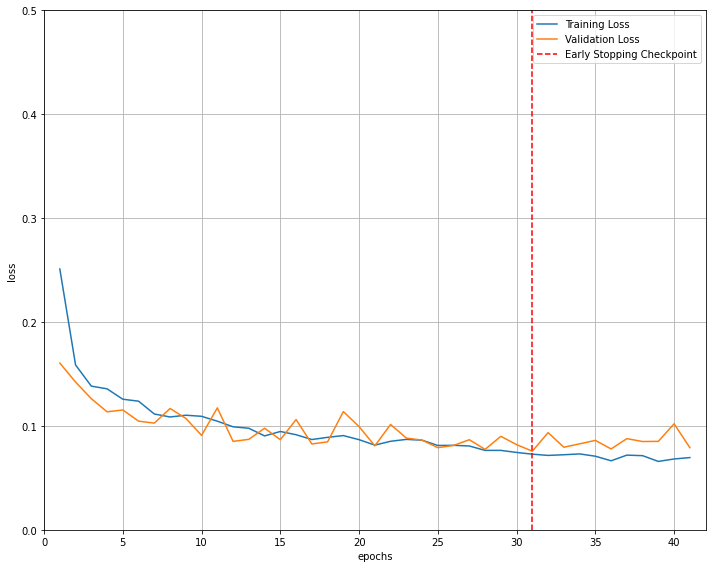

Dice2 score: 0.9547133012251421
Batch size: 8, Learning rate: 0.0001 , Epochs: 60






  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.188914).  Saving model ...





  2%|▏         | 1/60 [00:20<20:35, 20.94s/it]

Train Epoch: 1 @ 08:51:51.221751 - Train Loss: 0.3470 - Valid Loss: 0.1889
Validation loss decreased (0.188914 --> 0.141396).  Saving model ...





  3%|▎         | 2/60 [00:42<20:20, 21.04s/it]

Train Epoch: 2 @ 08:52:12.480508 - Train Loss: 0.2218 - Valid Loss: 0.1414
Validation loss decreased (0.141396 --> 0.115835).  Saving model ...





  5%|▌         | 3/60 [01:03<19:58, 21.03s/it]

Train Epoch: 3 @ 08:52:33.507434 - Train Loss: 0.1788 - Valid Loss: 0.1158
Validation loss decreased (0.115835 --> 0.102870).  Saving model ...





  7%|▋         | 4/60 [01:24<19:43, 21.13s/it]

Train Epoch: 4 @ 08:52:54.877060 - Train Loss: 0.1505 - Valid Loss: 0.1029
Validation loss decreased (0.102870 --> 0.097877).  Saving model ...





  8%|▊         | 5/60 [01:45<19:26, 21.20s/it]

Train Epoch: 5 @ 08:53:16.235055 - Train Loss: 0.1373 - Valid Loss: 0.0979
Validation loss decreased (0.097877 --> 0.096560).  Saving model ...





 10%|█         | 6/60 [02:06<19:02, 21.15s/it]

Train Epoch: 6 @ 08:53:37.277191 - Train Loss: 0.1259 - Valid Loss: 0.0966
Validation loss decreased (0.096560 --> 0.089054).  Saving model ...





 12%|█▏        | 7/60 [02:29<19:07, 21.66s/it]

Train Epoch: 7 @ 08:54:00.111378 - Train Loss: 0.1174 - Valid Loss: 0.0891
Validation loss decreased (0.089054 --> 0.088118).  Saving model ...





 13%|█▎        | 8/60 [02:51<18:41, 21.57s/it]

Train Epoch: 8 @ 08:54:21.465274 - Train Loss: 0.1050 - Valid Loss: 0.0881
Validation loss decreased (0.088118 --> 0.085178).  Saving model ...





 15%|█▌        | 9/60 [03:12<18:08, 21.35s/it]

Train Epoch: 9 @ 08:54:42.295016 - Train Loss: 0.1025 - Valid Loss: 0.0852
Validation loss decreased (0.085178 --> 0.083228).  Saving model ...





 17%|█▋        | 10/60 [03:32<17:40, 21.20s/it]

Train Epoch: 10 @ 08:55:03.154431 - Train Loss: 0.0987 - Valid Loss: 0.0832
Validation loss decreased (0.083228 --> 0.082161).  Saving model ...





 18%|█▊        | 11/60 [03:53<17:17, 21.17s/it]

Train Epoch: 11 @ 08:55:24.242726 - Train Loss: 0.0906 - Valid Loss: 0.0822
EarlyStopping counter: 1 out of 10





 20%|██        | 12/60 [04:14<16:47, 21.00s/it]

Train Epoch: 12 @ 08:55:44.845203 - Train Loss: 0.0882 - Valid Loss: 0.0840
EarlyStopping counter: 2 out of 10





 22%|██▏       | 13/60 [04:34<16:17, 20.80s/it]

Train Epoch: 13 @ 08:56:05.188341 - Train Loss: 0.0889 - Valid Loss: 0.0862
Validation loss decreased (0.082161 --> 0.080566).  Saving model ...





 23%|██▎       | 14/60 [04:55<15:53, 20.73s/it]

Train Epoch: 14 @ 08:56:25.755870 - Train Loss: 0.0858 - Valid Loss: 0.0806
Validation loss decreased (0.080566 --> 0.080210).  Saving model ...





 25%|██▌       | 15/60 [05:16<15:35, 20.79s/it]

Train Epoch: 15 @ 08:56:46.686813 - Train Loss: 0.0815 - Valid Loss: 0.0802
Validation loss decreased (0.080210 --> 0.080024).  Saving model ...





 27%|██▋       | 16/60 [05:37<15:16, 20.83s/it]

Train Epoch: 16 @ 08:57:07.623630 - Train Loss: 0.0763 - Valid Loss: 0.0800
EarlyStopping counter: 1 out of 10





 28%|██▊       | 17/60 [05:57<14:48, 20.66s/it]

Train Epoch: 17 @ 08:57:27.881613 - Train Loss: 0.0737 - Valid Loss: 0.0856
EarlyStopping counter: 2 out of 10





 30%|███       | 18/60 [06:17<14:21, 20.51s/it]

Train Epoch: 18 @ 08:57:48.025273 - Train Loss: 0.0750 - Valid Loss: 0.0856
EarlyStopping counter: 3 out of 10





 32%|███▏      | 19/60 [06:38<13:59, 20.47s/it]

Train Epoch: 19 @ 08:58:08.416368 - Train Loss: 0.0875 - Valid Loss: 0.0807
EarlyStopping counter: 4 out of 10





 33%|███▎      | 20/60 [06:58<13:33, 20.34s/it]

Train Epoch: 20 @ 08:58:28.441750 - Train Loss: 0.0795 - Valid Loss: 0.0801
EarlyStopping counter: 5 out of 10





 35%|███▌      | 21/60 [07:18<13:09, 20.25s/it]

Train Epoch: 21 @ 08:58:48.477349 - Train Loss: 0.0723 - Valid Loss: 0.0820
EarlyStopping counter: 6 out of 10





 37%|███▋      | 22/60 [07:38<12:50, 20.29s/it]

Train Epoch: 22 @ 08:59:08.858472 - Train Loss: 0.0663 - Valid Loss: 0.0801
Validation loss decreased (0.080024 --> 0.079711).  Saving model ...





 38%|███▊      | 23/60 [07:59<12:34, 20.40s/it]

Train Epoch: 23 @ 08:59:29.527946 - Train Loss: 0.0644 - Valid Loss: 0.0797
Validation loss decreased (0.079711 --> 0.078830).  Saving model ...





 40%|████      | 24/60 [08:19<12:17, 20.49s/it]

Train Epoch: 24 @ 08:59:50.235570 - Train Loss: 0.0623 - Valid Loss: 0.0788
EarlyStopping counter: 1 out of 10





 42%|████▏     | 25/60 [08:40<11:57, 20.50s/it]

Train Epoch: 25 @ 09:00:10.760972 - Train Loss: 0.0601 - Valid Loss: 0.0817
EarlyStopping counter: 2 out of 10





 43%|████▎     | 26/60 [09:00<11:33, 20.41s/it]

Train Epoch: 26 @ 09:00:30.951145 - Train Loss: 0.0589 - Valid Loss: 0.0804
EarlyStopping counter: 3 out of 10





 45%|████▌     | 27/60 [09:20<11:08, 20.26s/it]

Train Epoch: 27 @ 09:00:50.873270 - Train Loss: 0.0565 - Valid Loss: 0.0799
EarlyStopping counter: 4 out of 10





 47%|████▋     | 28/60 [09:40<10:49, 20.29s/it]

Train Epoch: 28 @ 09:01:11.222850 - Train Loss: 0.0551 - Valid Loss: 0.0809
EarlyStopping counter: 5 out of 10





 48%|████▊     | 29/60 [10:01<10:29, 20.29s/it]

Train Epoch: 29 @ 09:01:31.522772 - Train Loss: 0.0539 - Valid Loss: 0.0815
EarlyStopping counter: 6 out of 10





 50%|█████     | 30/60 [10:21<10:09, 20.31s/it]

Train Epoch: 30 @ 09:01:51.890003 - Train Loss: 0.0523 - Valid Loss: 0.0823
EarlyStopping counter: 7 out of 10





 52%|█████▏    | 31/60 [10:41<09:48, 20.29s/it]

Train Epoch: 31 @ 09:02:12.132787 - Train Loss: 0.0514 - Valid Loss: 0.0811
EarlyStopping counter: 8 out of 10





 53%|█████▎    | 32/60 [11:01<09:25, 20.20s/it]

Train Epoch: 32 @ 09:02:32.109698 - Train Loss: 0.0506 - Valid Loss: 0.0855
EarlyStopping counter: 9 out of 10





 55%|█████▌    | 33/60 [11:22<09:05, 20.22s/it]

Train Epoch: 33 @ 09:02:52.364671 - Train Loss: 0.0559 - Valid Loss: 0.0859
EarlyStopping counter: 10 out of 10
Early stopping


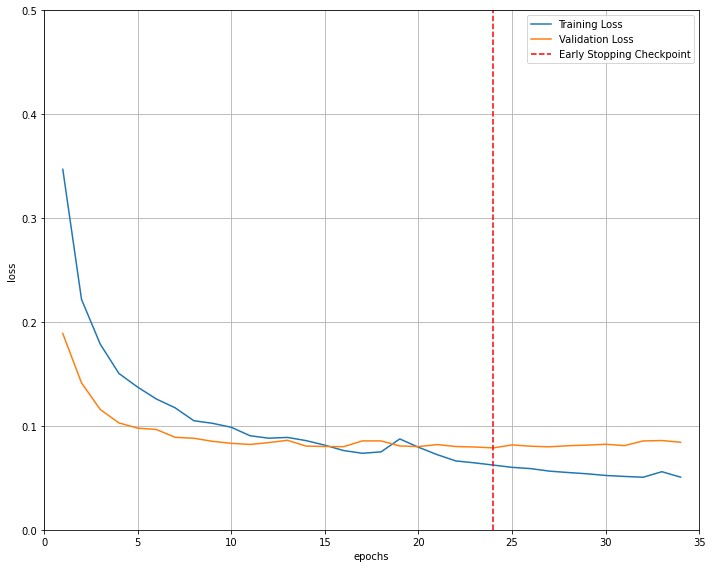

Dice2 score: 0.9549449573863636
Batch size: 8, Learning rate: 1e-05 , Epochs: 60







  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.268325).  Saving model ...






  2%|▏         | 1/60 [00:20<20:03, 20.40s/it]

Train Epoch: 1 @ 09:03:33.945095 - Train Loss: 0.5764 - Valid Loss: 0.2683
Validation loss decreased (0.268325 --> 0.216079).  Saving model ...






  3%|▎         | 2/60 [00:42<20:12, 20.91s/it]

Train Epoch: 2 @ 09:03:56.040577 - Train Loss: 0.2972 - Valid Loss: 0.2161
Validation loss decreased (0.216079 --> 0.210416).  Saving model ...






  5%|▌         | 3/60 [01:03<19:51, 20.90s/it]

Train Epoch: 3 @ 09:04:16.908605 - Train Loss: 0.2628 - Valid Loss: 0.2104
Validation loss decreased (0.210416 --> 0.203716).  Saving model ...






  7%|▋         | 4/60 [01:24<19:28, 20.87s/it]

Train Epoch: 4 @ 09:04:37.701484 - Train Loss: 0.2528 - Valid Loss: 0.2037
EarlyStopping counter: 1 out of 10






  8%|▊         | 5/60 [01:44<19:01, 20.75s/it]

Train Epoch: 5 @ 09:04:58.176482 - Train Loss: 0.2414 - Valid Loss: 0.2042
Validation loss decreased (0.203716 --> 0.196507).  Saving model ...






 10%|█         | 6/60 [02:05<18:46, 20.87s/it]

Train Epoch: 6 @ 09:05:19.326084 - Train Loss: 0.2302 - Valid Loss: 0.1965
Validation loss decreased (0.196507 --> 0.192175).  Saving model ...






 12%|█▏        | 7/60 [02:26<18:22, 20.80s/it]

Train Epoch: 7 @ 09:05:39.965754 - Train Loss: 0.2221 - Valid Loss: 0.1922
Validation loss decreased (0.192175 --> 0.179525).  Saving model ...






 13%|█▎        | 8/60 [02:46<17:57, 20.73s/it]

Train Epoch: 8 @ 09:06:00.527792 - Train Loss: 0.2090 - Valid Loss: 0.1795
Validation loss decreased (0.179525 --> 0.172882).  Saving model ...






 15%|█▌        | 9/60 [03:07<17:41, 20.81s/it]

Train Epoch: 9 @ 09:06:21.521265 - Train Loss: 0.2024 - Valid Loss: 0.1729
Validation loss decreased (0.172882 --> 0.159126).  Saving model ...






 17%|█▋        | 10/60 [03:28<17:21, 20.83s/it]

Train Epoch: 10 @ 09:06:42.418700 - Train Loss: 0.1897 - Valid Loss: 0.1591
Validation loss decreased (0.159126 --> 0.149321).  Saving model ...






 18%|█▊        | 11/60 [03:49<16:59, 20.81s/it]

Train Epoch: 11 @ 09:07:03.177151 - Train Loss: 0.1745 - Valid Loss: 0.1493
Validation loss decreased (0.149321 --> 0.144398).  Saving model ...






 20%|██        | 12/60 [04:10<16:33, 20.69s/it]

Train Epoch: 12 @ 09:07:23.584096 - Train Loss: 0.1691 - Valid Loss: 0.1444
Validation loss decreased (0.144398 --> 0.140894).  Saving model ...






 22%|██▏       | 13/60 [04:30<16:11, 20.68s/it]

Train Epoch: 13 @ 09:07:44.224442 - Train Loss: 0.1626 - Valid Loss: 0.1409
Validation loss decreased (0.140894 --> 0.135686).  Saving model ...






 23%|██▎       | 14/60 [04:51<15:54, 20.74s/it]

Train Epoch: 14 @ 09:08:05.112860 - Train Loss: 0.1602 - Valid Loss: 0.1357
Validation loss decreased (0.135686 --> 0.130739).  Saving model ...






 25%|██▌       | 15/60 [05:12<15:29, 20.67s/it]

Train Epoch: 15 @ 09:08:25.606251 - Train Loss: 0.1522 - Valid Loss: 0.1307
Validation loss decreased (0.130739 --> 0.127816).  Saving model ...






 27%|██▋       | 16/60 [05:33<15:21, 20.95s/it]

Train Epoch: 16 @ 09:08:47.210862 - Train Loss: 0.1471 - Valid Loss: 0.1278
Validation loss decreased (0.127816 --> 0.126181).  Saving model ...






 28%|██▊       | 17/60 [05:54<15:01, 20.96s/it]

Train Epoch: 17 @ 09:09:08.214670 - Train Loss: 0.1438 - Valid Loss: 0.1262
EarlyStopping counter: 1 out of 10






 30%|███       | 18/60 [06:14<14:29, 20.70s/it]

Train Epoch: 18 @ 09:09:28.290626 - Train Loss: 0.1410 - Valid Loss: 0.1264
Validation loss decreased (0.126181 --> 0.123004).  Saving model ...






 32%|███▏      | 19/60 [06:35<14:06, 20.64s/it]

Train Epoch: 19 @ 09:09:48.784957 - Train Loss: 0.1342 - Valid Loss: 0.1230
Validation loss decreased (0.123004 --> 0.120717).  Saving model ...






 33%|███▎      | 20/60 [06:56<13:50, 20.77s/it]

Train Epoch: 20 @ 09:10:09.861270 - Train Loss: 0.1347 - Valid Loss: 0.1207
Validation loss decreased (0.120717 --> 0.119935).  Saving model ...






 35%|███▌      | 21/60 [07:17<13:29, 20.75s/it]

Train Epoch: 21 @ 09:10:30.563468 - Train Loss: 0.1316 - Valid Loss: 0.1199
Validation loss decreased (0.119935 --> 0.117388).  Saving model ...






 37%|███▋      | 22/60 [07:37<13:05, 20.68s/it]

Train Epoch: 22 @ 09:10:51.080986 - Train Loss: 0.1279 - Valid Loss: 0.1174
Validation loss decreased (0.117388 --> 0.114920).  Saving model ...






 38%|███▊      | 23/60 [07:58<12:48, 20.76s/it]

Train Epoch: 23 @ 09:11:12.022200 - Train Loss: 0.1271 - Valid Loss: 0.1149
Validation loss decreased (0.114920 --> 0.112191).  Saving model ...






 40%|████      | 24/60 [08:20<12:40, 21.13s/it]

Train Epoch: 24 @ 09:11:34.008319 - Train Loss: 0.1296 - Valid Loss: 0.1122
EarlyStopping counter: 1 out of 10






 42%|████▏     | 25/60 [08:40<12:08, 20.81s/it]

Train Epoch: 25 @ 09:11:54.080537 - Train Loss: 0.1228 - Valid Loss: 0.1123
Validation loss decreased (0.112191 --> 0.111309).  Saving model ...






 43%|████▎     | 26/60 [09:01<11:46, 20.77s/it]

Train Epoch: 26 @ 09:12:14.750881 - Train Loss: 0.1195 - Valid Loss: 0.1113
Validation loss decreased (0.111309 --> 0.109166).  Saving model ...






 45%|████▌     | 27/60 [09:22<11:25, 20.78s/it]

Train Epoch: 27 @ 09:12:35.562338 - Train Loss: 0.1161 - Valid Loss: 0.1092
EarlyStopping counter: 1 out of 10






 47%|████▋     | 28/60 [09:42<11:01, 20.67s/it]

Train Epoch: 28 @ 09:12:55.965454 - Train Loss: 0.1182 - Valid Loss: 0.1094
EarlyStopping counter: 2 out of 10






 48%|████▊     | 29/60 [10:02<10:34, 20.47s/it]

Train Epoch: 29 @ 09:13:15.956838 - Train Loss: 0.1138 - Valid Loss: 0.1092
Validation loss decreased (0.109166 --> 0.108284).  Saving model ...






 50%|█████     | 30/60 [10:22<10:13, 20.46s/it]

Train Epoch: 30 @ 09:13:36.405761 - Train Loss: 0.1108 - Valid Loss: 0.1083
Validation loss decreased (0.108284 --> 0.107368).  Saving model ...






 52%|█████▏    | 31/60 [10:43<09:56, 20.55s/it]

Train Epoch: 31 @ 09:13:57.177271 - Train Loss: 0.1092 - Valid Loss: 0.1074
Validation loss decreased (0.107368 --> 0.106863).  Saving model ...






 53%|█████▎    | 32/60 [11:04<09:37, 20.61s/it]

Train Epoch: 32 @ 09:14:17.922252 - Train Loss: 0.1096 - Valid Loss: 0.1069
Validation loss decreased (0.106863 --> 0.106073).  Saving model ...






 55%|█████▌    | 33/60 [11:25<09:23, 20.86s/it]

Train Epoch: 33 @ 09:14:39.351588 - Train Loss: 0.1063 - Valid Loss: 0.1061
Validation loss decreased (0.106073 --> 0.105650).  Saving model ...






 57%|█████▋    | 34/60 [11:46<09:02, 20.87s/it]

Train Epoch: 34 @ 09:15:00.253126 - Train Loss: 0.1048 - Valid Loss: 0.1056
Validation loss decreased (0.105650 --> 0.104319).  Saving model ...






 58%|█████▊    | 35/60 [12:07<08:41, 20.85s/it]

Train Epoch: 35 @ 09:15:21.041660 - Train Loss: 0.1053 - Valid Loss: 0.1043
Validation loss decreased (0.104319 --> 0.102888).  Saving model ...






 60%|██████    | 36/60 [12:28<08:17, 20.75s/it]

Train Epoch: 36 @ 09:15:41.563013 - Train Loss: 0.1074 - Valid Loss: 0.1029
EarlyStopping counter: 1 out of 10






 62%|██████▏   | 37/60 [12:48<07:52, 20.56s/it]

Train Epoch: 37 @ 09:16:01.697321 - Train Loss: 0.1033 - Valid Loss: 0.1033
EarlyStopping counter: 2 out of 10






 63%|██████▎   | 38/60 [13:08<07:29, 20.44s/it]

Train Epoch: 38 @ 09:16:21.860420 - Train Loss: 0.0997 - Valid Loss: 0.1040
Validation loss decreased (0.102888 --> 0.102780).  Saving model ...






 65%|██████▌   | 39/60 [13:28<07:09, 20.43s/it]

Train Epoch: 39 @ 09:16:42.254771 - Train Loss: 0.1004 - Valid Loss: 0.1028
EarlyStopping counter: 1 out of 10






 67%|██████▋   | 40/60 [13:48<06:46, 20.32s/it]

Train Epoch: 40 @ 09:17:02.336712 - Train Loss: 0.1100 - Valid Loss: 0.1038
EarlyStopping counter: 2 out of 10






 68%|██████▊   | 41/60 [14:09<06:29, 20.53s/it]

Train Epoch: 41 @ 09:17:23.329738 - Train Loss: 0.1012 - Valid Loss: 0.1031
Validation loss decreased (0.102780 --> 0.101814).  Saving model ...






 70%|███████   | 42/60 [14:30<06:10, 20.60s/it]

Train Epoch: 42 @ 09:17:44.111083 - Train Loss: 0.0973 - Valid Loss: 0.1018
Validation loss decreased (0.101814 --> 0.100706).  Saving model ...






 72%|███████▏  | 43/60 [14:51<05:52, 20.73s/it]

Train Epoch: 43 @ 09:18:05.128287 - Train Loss: 0.0955 - Valid Loss: 0.1007
EarlyStopping counter: 1 out of 10






 73%|███████▎  | 44/60 [15:11<05:28, 20.53s/it]

Train Epoch: 44 @ 09:18:25.196551 - Train Loss: 0.0935 - Valid Loss: 0.1010
Validation loss decreased (0.100706 --> 0.100513).  Saving model ...






 75%|███████▌  | 45/60 [15:32<05:08, 20.55s/it]

Train Epoch: 45 @ 09:18:45.805677 - Train Loss: 0.0920 - Valid Loss: 0.1005
EarlyStopping counter: 1 out of 10






 77%|███████▋  | 46/60 [15:52<04:46, 20.48s/it]

Train Epoch: 46 @ 09:19:06.101044 - Train Loss: 0.0933 - Valid Loss: 0.1021
EarlyStopping counter: 2 out of 10






 78%|███████▊  | 47/60 [16:12<04:24, 20.32s/it]

Train Epoch: 47 @ 09:19:26.065195 - Train Loss: 0.1017 - Valid Loss: 0.1020
Validation loss decreased (0.100513 --> 0.099000).  Saving model ...






 80%|████████  | 48/60 [16:33<04:04, 20.40s/it]

Train Epoch: 48 @ 09:19:46.656382 - Train Loss: 0.0941 - Valid Loss: 0.0990
EarlyStopping counter: 1 out of 10






 82%|████████▏ | 49/60 [16:53<03:45, 20.47s/it]

Train Epoch: 49 @ 09:20:07.285080 - Train Loss: 0.0894 - Valid Loss: 0.1013
EarlyStopping counter: 2 out of 10






 83%|████████▎ | 50/60 [17:13<03:24, 20.40s/it]

Train Epoch: 50 @ 09:20:27.527089 - Train Loss: 0.0891 - Valid Loss: 0.1002
EarlyStopping counter: 3 out of 10






 85%|████████▌ | 51/60 [17:33<03:02, 20.25s/it]

Train Epoch: 51 @ 09:20:47.417003 - Train Loss: 0.0902 - Valid Loss: 0.1010
EarlyStopping counter: 4 out of 10






 87%|████████▋ | 52/60 [17:54<02:41, 20.24s/it]

Train Epoch: 52 @ 09:21:07.644650 - Train Loss: 0.0880 - Valid Loss: 0.1006
EarlyStopping counter: 5 out of 10






 88%|████████▊ | 53/60 [18:14<02:21, 20.19s/it]

Train Epoch: 53 @ 09:21:27.718656 - Train Loss: 0.0877 - Valid Loss: 0.0997
EarlyStopping counter: 6 out of 10






 90%|█████████ | 54/60 [18:34<02:00, 20.13s/it]

Train Epoch: 54 @ 09:21:47.689138 - Train Loss: 0.0875 - Valid Loss: 0.1003
Validation loss decreased (0.099000 --> 0.098364).  Saving model ...






 92%|█████████▏| 55/60 [18:54<01:41, 20.30s/it]

Train Epoch: 55 @ 09:22:08.409999 - Train Loss: 0.0868 - Valid Loss: 0.0984
EarlyStopping counter: 1 out of 10






 93%|█████████▎| 56/60 [19:15<01:21, 20.33s/it]

Train Epoch: 56 @ 09:22:28.804005 - Train Loss: 0.0878 - Valid Loss: 0.1006
Validation loss decreased (0.098364 --> 0.098159).  Saving model ...






 95%|█████████▌| 57/60 [19:35<01:01, 20.35s/it]

Train Epoch: 57 @ 09:22:49.210151 - Train Loss: 0.0846 - Valid Loss: 0.0982
EarlyStopping counter: 1 out of 10






 97%|█████████▋| 58/60 [19:55<00:40, 20.32s/it]

Train Epoch: 58 @ 09:23:09.444795 - Train Loss: 0.0827 - Valid Loss: 0.0994
EarlyStopping counter: 2 out of 10






 98%|█████████▊| 59/60 [20:16<00:20, 20.28s/it]

Train Epoch: 59 @ 09:23:29.622807 - Train Loss: 0.0836 - Valid Loss: 0.0997
EarlyStopping counter: 3 out of 10






100%|██████████| 60/60 [20:36<00:00, 20.60s/it]

Train Epoch: 60 @ 09:23:49.728069 - Train Loss: 0.0845 - Valid Loss: 0.0989


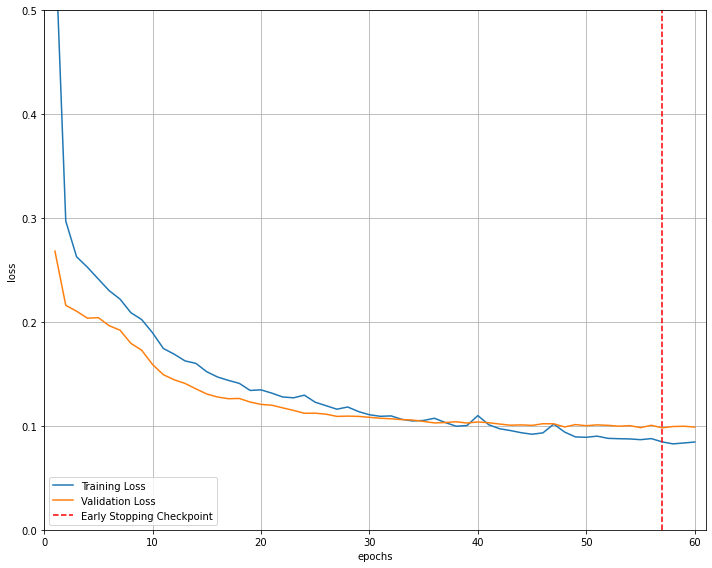

Dice2 score: 0.9548991810191761


In [ ]:
n_bs = [8]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_250"
model_chkpt_name = "ResNet-250x250_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

Batch size: 16, Learning rate: 0.001 , Epochs: 60







  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.162941).  Saving model ...






  2%|▏         | 1/60 [00:17<17:08, 17.43s/it]

Train Epoch: 1 @ 09:26:40.948224 - Train Loss: 0.3623 - Valid Loss: 0.1629
Validation loss decreased (0.162941 --> 0.147980).  Saving model ...






  3%|▎         | 2/60 [00:35<16:58, 17.55s/it]

Train Epoch: 2 @ 09:26:58.795513 - Train Loss: 0.1949 - Valid Loss: 0.1480
Validation loss decreased (0.147980 --> 0.130188).  Saving model ...






  5%|▌         | 3/60 [00:53<16:50, 17.72s/it]

Train Epoch: 3 @ 09:27:16.916565 - Train Loss: 0.1764 - Valid Loss: 0.1302
Validation loss decreased (0.130188 --> 0.117371).  Saving model ...






  7%|▋         | 4/60 [01:11<16:38, 17.83s/it]

Train Epoch: 4 @ 09:27:34.984823 - Train Loss: 0.1651 - Valid Loss: 0.1174
EarlyStopping counter: 1 out of 10






  8%|▊         | 5/60 [01:29<16:16, 17.76s/it]

Train Epoch: 5 @ 09:27:52.588729 - Train Loss: 0.1596 - Valid Loss: 0.1239
Validation loss decreased (0.117371 --> 0.100924).  Saving model ...






 10%|█         | 6/60 [01:47<16:06, 17.90s/it]

Train Epoch: 6 @ 09:28:10.816895 - Train Loss: 0.1503 - Valid Loss: 0.1009
Validation loss decreased (0.100924 --> 0.094717).  Saving model ...






 12%|█▏        | 7/60 [02:05<15:54, 18.00s/it]

Train Epoch: 7 @ 09:28:29.061156 - Train Loss: 0.1376 - Valid Loss: 0.0947
Validation loss decreased (0.094717 --> 0.092841).  Saving model ...






 13%|█▎        | 8/60 [02:24<15:52, 18.31s/it]

Train Epoch: 8 @ 09:28:48.085951 - Train Loss: 0.1283 - Valid Loss: 0.0928
EarlyStopping counter: 1 out of 10






 15%|█▌        | 9/60 [02:42<15:24, 18.13s/it]

Train Epoch: 9 @ 09:29:05.803831 - Train Loss: 0.1194 - Valid Loss: 0.1053
Validation loss decreased (0.092841 --> 0.089274).  Saving model ...






 17%|█▋        | 10/60 [03:00<15:03, 18.08s/it]

Train Epoch: 10 @ 09:29:23.749163 - Train Loss: 0.1154 - Valid Loss: 0.0893
Validation loss decreased (0.089274 --> 0.088455).  Saving model ...






 18%|█▊        | 11/60 [03:18<14:47, 18.12s/it]

Train Epoch: 11 @ 09:29:41.975427 - Train Loss: 0.1148 - Valid Loss: 0.0885
EarlyStopping counter: 1 out of 10






 20%|██        | 12/60 [03:36<14:27, 18.07s/it]

Train Epoch: 12 @ 09:29:59.930882 - Train Loss: 0.1083 - Valid Loss: 0.0955
Validation loss decreased (0.088455 --> 0.073314).  Saving model ...






 22%|██▏       | 13/60 [03:54<14:09, 18.08s/it]

Train Epoch: 13 @ 09:30:18.019381 - Train Loss: 0.1042 - Valid Loss: 0.0733
EarlyStopping counter: 1 out of 10






 23%|██▎       | 14/60 [04:12<13:44, 17.93s/it]

Train Epoch: 14 @ 09:30:35.601582 - Train Loss: 0.1000 - Valid Loss: 0.0853
EarlyStopping counter: 2 out of 10






 25%|██▌       | 15/60 [04:29<13:24, 17.87s/it]

Train Epoch: 15 @ 09:30:53.337224 - Train Loss: 0.1007 - Valid Loss: 0.0738
Validation loss decreased (0.073314 --> 0.068664).  Saving model ...






 27%|██▋       | 16/60 [04:48<13:11, 17.99s/it]

Train Epoch: 16 @ 09:31:11.624103 - Train Loss: 0.0978 - Valid Loss: 0.0687
EarlyStopping counter: 1 out of 10






 28%|██▊       | 17/60 [05:05<12:49, 17.89s/it]

Train Epoch: 17 @ 09:31:29.282004 - Train Loss: 0.0902 - Valid Loss: 0.0741
EarlyStopping counter: 2 out of 10






 30%|███       | 18/60 [05:23<12:27, 17.80s/it]

Train Epoch: 18 @ 09:31:46.856757 - Train Loss: 0.0934 - Valid Loss: 0.0772
EarlyStopping counter: 3 out of 10






 32%|███▏      | 19/60 [05:41<12:09, 17.80s/it]

Train Epoch: 19 @ 09:32:04.673883 - Train Loss: 0.0904 - Valid Loss: 0.0695
EarlyStopping counter: 4 out of 10






 33%|███▎      | 20/60 [05:58<11:50, 17.77s/it]

Train Epoch: 20 @ 09:32:22.348798 - Train Loss: 0.0930 - Valid Loss: 0.0779
EarlyStopping counter: 5 out of 10






 35%|███▌      | 21/60 [06:16<11:30, 17.71s/it]

Train Epoch: 21 @ 09:32:39.938216 - Train Loss: 0.0963 - Valid Loss: 0.0805
EarlyStopping counter: 6 out of 10






 37%|███▋      | 22/60 [06:33<11:11, 17.66s/it]

Train Epoch: 22 @ 09:32:57.492615 - Train Loss: 0.0886 - Valid Loss: 0.0690
EarlyStopping counter: 7 out of 10






 38%|███▊      | 23/60 [06:51<10:55, 17.71s/it]

Train Epoch: 23 @ 09:33:15.310112 - Train Loss: 0.0857 - Valid Loss: 0.0688
EarlyStopping counter: 8 out of 10






 40%|████      | 24/60 [07:09<10:36, 17.69s/it]

Train Epoch: 24 @ 09:33:32.956851 - Train Loss: 0.0864 - Valid Loss: 0.0763
EarlyStopping counter: 9 out of 10






 42%|████▏     | 25/60 [07:27<10:18, 17.68s/it]

Train Epoch: 25 @ 09:33:50.608210 - Train Loss: 0.0841 - Valid Loss: 0.0760
EarlyStopping counter: 10 out of 10
Early stopping


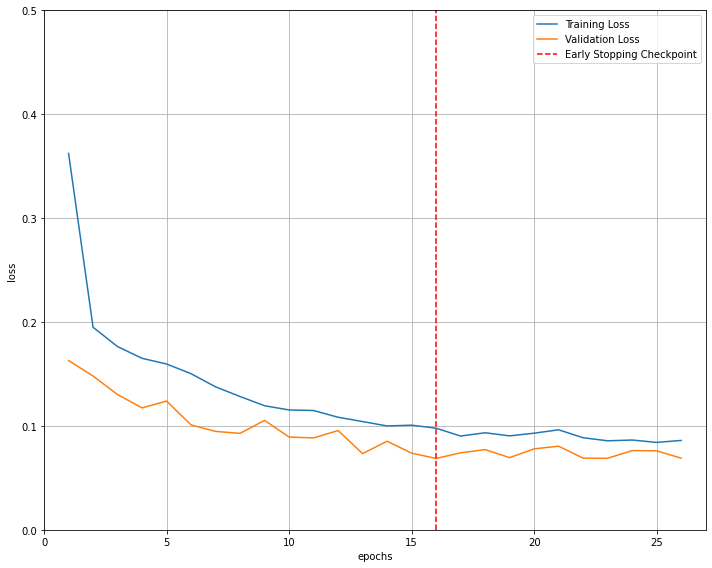

Dice2 score: 0.9646402994791666
Batch size: 16, Learning rate: 0.0001 , Epochs: 60








  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.208653).  Saving model ...







  2%|▏         | 1/60 [00:18<18:10, 18.48s/it]

Train Epoch: 1 @ 09:34:27.817795 - Train Loss: 0.4220 - Valid Loss: 0.2087
Validation loss decreased (0.208653 --> 0.186110).  Saving model ...







  3%|▎         | 2/60 [00:36<17:51, 18.48s/it]

Train Epoch: 2 @ 09:34:46.296991 - Train Loss: 0.2839 - Valid Loss: 0.1861
Validation loss decreased (0.186110 --> 0.158393).  Saving model ...







  5%|▌         | 3/60 [00:55<17:34, 18.50s/it]

Train Epoch: 3 @ 09:35:04.853976 - Train Loss: 0.2378 - Valid Loss: 0.1584
Validation loss decreased (0.158393 --> 0.138719).  Saving model ...







  7%|▋         | 4/60 [01:13<17:14, 18.47s/it]

Train Epoch: 4 @ 09:35:23.249956 - Train Loss: 0.2076 - Valid Loss: 0.1387
Validation loss decreased (0.138719 --> 0.134014).  Saving model ...







  8%|▊         | 5/60 [01:32<16:54, 18.45s/it]

Train Epoch: 5 @ 09:35:41.652991 - Train Loss: 0.1859 - Valid Loss: 0.1340
Validation loss decreased (0.134014 --> 0.130107).  Saving model ...







 10%|█         | 6/60 [01:51<16:40, 18.53s/it]

Train Epoch: 6 @ 09:36:00.377425 - Train Loss: 0.1664 - Valid Loss: 0.1301
Validation loss decreased (0.130107 --> 0.111599).  Saving model ...







 12%|█▏        | 7/60 [02:09<16:22, 18.53s/it]

Train Epoch: 7 @ 09:36:18.903447 - Train Loss: 0.1538 - Valid Loss: 0.1116
Validation loss decreased (0.111599 --> 0.099716).  Saving model ...







 13%|█▎        | 8/60 [02:27<16:00, 18.48s/it]

Train Epoch: 8 @ 09:36:37.265515 - Train Loss: 0.1397 - Valid Loss: 0.0997
Validation loss decreased (0.099716 --> 0.093183).  Saving model ...







 15%|█▌        | 9/60 [02:48<16:08, 19.00s/it]

Train Epoch: 9 @ 09:36:57.476741 - Train Loss: 0.1287 - Valid Loss: 0.0932
EarlyStopping counter: 1 out of 10







 17%|█▋        | 10/60 [03:06<15:38, 18.76s/it]

Train Epoch: 10 @ 09:37:15.678788 - Train Loss: 0.1186 - Valid Loss: 0.0953
Validation loss decreased (0.093183 --> 0.089448).  Saving model ...







 18%|█▊        | 11/60 [03:24<15:10, 18.59s/it]

Train Epoch: 11 @ 09:37:33.867574 - Train Loss: 0.1107 - Valid Loss: 0.0894
Validation loss decreased (0.089448 --> 0.087826).  Saving model ...







 20%|██        | 12/60 [03:42<14:48, 18.50s/it]

Train Epoch: 12 @ 09:37:52.166042 - Train Loss: 0.1053 - Valid Loss: 0.0878
EarlyStopping counter: 1 out of 10







 22%|██▏       | 13/60 [04:00<14:23, 18.38s/it]

Train Epoch: 13 @ 09:38:10.264606 - Train Loss: 0.1006 - Valid Loss: 0.0940
EarlyStopping counter: 2 out of 10







 23%|██▎       | 14/60 [04:18<13:58, 18.22s/it]

Train Epoch: 14 @ 09:38:28.125254 - Train Loss: 0.0965 - Valid Loss: 0.0928
Validation loss decreased (0.087826 --> 0.087804).  Saving model ...







 25%|██▌       | 15/60 [04:36<13:39, 18.21s/it]

Train Epoch: 15 @ 09:38:46.300726 - Train Loss: 0.0901 - Valid Loss: 0.0878
EarlyStopping counter: 1 out of 10







 27%|██▋       | 16/60 [04:54<13:17, 18.11s/it]

Train Epoch: 16 @ 09:39:04.193366 - Train Loss: 0.0871 - Valid Loss: 0.0954
Validation loss decreased (0.087804 --> 0.085926).  Saving model ...







 28%|██▊       | 17/60 [05:13<13:07, 18.32s/it]

Train Epoch: 17 @ 09:39:23.003472 - Train Loss: 0.0853 - Valid Loss: 0.0859
EarlyStopping counter: 1 out of 10







 30%|███       | 18/60 [05:31<12:46, 18.25s/it]

Train Epoch: 18 @ 09:39:41.085464 - Train Loss: 0.0807 - Valid Loss: 0.0906
EarlyStopping counter: 2 out of 10







 32%|███▏      | 19/60 [05:49<12:25, 18.19s/it]

Train Epoch: 19 @ 09:39:59.122878 - Train Loss: 0.0767 - Valid Loss: 0.0888
EarlyStopping counter: 3 out of 10







 33%|███▎      | 20/60 [06:07<12:02, 18.06s/it]

Train Epoch: 20 @ 09:40:16.898352 - Train Loss: 0.0812 - Valid Loss: 0.0953
EarlyStopping counter: 4 out of 10







 35%|███▌      | 21/60 [06:25<11:40, 17.96s/it]

Train Epoch: 21 @ 09:40:34.607649 - Train Loss: 0.0789 - Valid Loss: 0.0917
EarlyStopping counter: 5 out of 10







 37%|███▋      | 22/60 [06:43<11:23, 17.98s/it]

Train Epoch: 22 @ 09:40:52.636943 - Train Loss: 0.0738 - Valid Loss: 0.0920
EarlyStopping counter: 6 out of 10







 38%|███▊      | 23/60 [07:01<11:05, 18.00s/it]

Train Epoch: 23 @ 09:41:10.676427 - Train Loss: 0.0724 - Valid Loss: 0.0939
EarlyStopping counter: 7 out of 10







 40%|████      | 24/60 [07:19<10:44, 17.91s/it]

Train Epoch: 24 @ 09:41:28.382915 - Train Loss: 0.0693 - Valid Loss: 0.0887
EarlyStopping counter: 8 out of 10







 42%|████▏     | 25/60 [07:36<10:25, 17.87s/it]

Train Epoch: 25 @ 09:41:46.146299 - Train Loss: 0.0656 - Valid Loss: 0.0865
EarlyStopping counter: 9 out of 10







 43%|████▎     | 26/60 [07:55<10:11, 17.99s/it]

Train Epoch: 26 @ 09:42:04.416029 - Train Loss: 0.0640 - Valid Loss: 0.0873
EarlyStopping counter: 10 out of 10
Early stopping


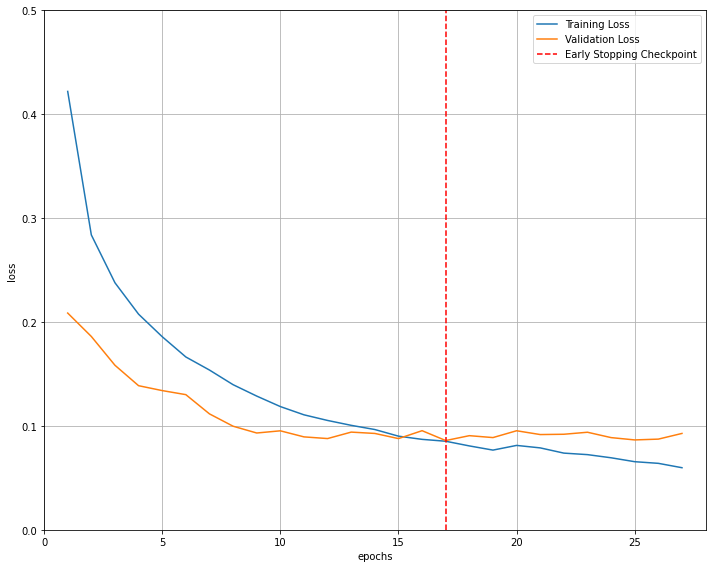

Dice2 score: 0.9689992268880209
Batch size: 16, Learning rate: 1e-05 , Epochs: 60









  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.619731).  Saving model ...








  2%|▏         | 1/60 [00:18<17:56, 18.24s/it]

Train Epoch: 1 @ 09:42:41.260381 - Train Loss: 0.6597 - Valid Loss: 0.6197
Validation loss decreased (0.619731 --> 0.248494).  Saving model ...








  3%|▎         | 2/60 [00:36<17:43, 18.34s/it]

Train Epoch: 2 @ 09:42:59.820173 - Train Loss: 0.4585 - Valid Loss: 0.2485
Validation loss decreased (0.248494 --> 0.208067).  Saving model ...








  5%|▌         | 3/60 [00:55<17:32, 18.46s/it]

Train Epoch: 3 @ 09:43:18.566356 - Train Loss: 0.3034 - Valid Loss: 0.2081
Validation loss decreased (0.208067 --> 0.202533).  Saving model ...








  7%|▋         | 4/60 [01:13<17:12, 18.43s/it]

Train Epoch: 4 @ 09:43:36.933149 - Train Loss: 0.2695 - Valid Loss: 0.2025
EarlyStopping counter: 1 out of 10








  8%|▊         | 5/60 [01:31<16:43, 18.25s/it]

Train Epoch: 5 @ 09:43:54.753580 - Train Loss: 0.2528 - Valid Loss: 0.2142
EarlyStopping counter: 2 out of 10








 10%|█         | 6/60 [01:49<16:23, 18.21s/it]

Train Epoch: 6 @ 09:44:12.889578 - Train Loss: 0.2450 - Valid Loss: 0.2083
Validation loss decreased (0.202533 --> 0.194414).  Saving model ...








 12%|█▏        | 7/60 [02:08<16:09, 18.30s/it]

Train Epoch: 7 @ 09:44:31.375756 - Train Loss: 0.2407 - Valid Loss: 0.1944
Validation loss decreased (0.194414 --> 0.182571).  Saving model ...








 13%|█▎        | 8/60 [02:27<15:59, 18.45s/it]

Train Epoch: 8 @ 09:44:50.173268 - Train Loss: 0.2350 - Valid Loss: 0.1826
EarlyStopping counter: 1 out of 10








 15%|█▌        | 9/60 [02:45<15:33, 18.30s/it]

Train Epoch: 9 @ 09:45:08.131613 - Train Loss: 0.2309 - Valid Loss: 0.2011
EarlyStopping counter: 2 out of 10








 17%|█▋        | 10/60 [03:02<15:06, 18.13s/it]

Train Epoch: 10 @ 09:45:25.875536 - Train Loss: 0.2232 - Valid Loss: 0.1906
Validation loss decreased (0.182571 --> 0.181234).  Saving model ...








 18%|█▊        | 11/60 [03:21<14:53, 18.24s/it]

Train Epoch: 11 @ 09:45:44.359602 - Train Loss: 0.2145 - Valid Loss: 0.1812
Validation loss decreased (0.181234 --> 0.174760).  Saving model ...








 20%|██        | 12/60 [03:40<14:44, 18.43s/it]

Train Epoch: 12 @ 09:46:03.250353 - Train Loss: 0.2112 - Valid Loss: 0.1748
EarlyStopping counter: 1 out of 10








 22%|██▏       | 13/60 [03:58<14:19, 18.29s/it]

Train Epoch: 13 @ 09:46:21.188769 - Train Loss: 0.2017 - Valid Loss: 0.1768
EarlyStopping counter: 2 out of 10








 23%|██▎       | 14/60 [04:15<13:53, 18.12s/it]

Train Epoch: 14 @ 09:46:38.930007 - Train Loss: 0.1966 - Valid Loss: 0.1756
Validation loss decreased (0.174760 --> 0.165871).  Saving model ...








 25%|██▌       | 15/60 [04:34<13:41, 18.26s/it]

Train Epoch: 15 @ 09:46:57.504795 - Train Loss: 0.1901 - Valid Loss: 0.1659
Validation loss decreased (0.165871 --> 0.163957).  Saving model ...








 27%|██▋       | 16/60 [04:53<13:28, 18.37s/it]

Train Epoch: 16 @ 09:47:16.123586 - Train Loss: 0.1827 - Valid Loss: 0.1640
Validation loss decreased (0.163957 --> 0.157125).  Saving model ...








 28%|██▊       | 17/60 [05:11<13:11, 18.40s/it]

Train Epoch: 17 @ 09:47:34.612535 - Train Loss: 0.1754 - Valid Loss: 0.1571
Validation loss decreased (0.157125 --> 0.148314).  Saving model ...








 30%|███       | 18/60 [05:30<12:54, 18.43s/it]

Train Epoch: 18 @ 09:47:53.105026 - Train Loss: 0.1673 - Valid Loss: 0.1483
Validation loss decreased (0.148314 --> 0.142154).  Saving model ...








 32%|███▏      | 19/60 [05:48<12:38, 18.51s/it]

Train Epoch: 19 @ 09:48:11.802868 - Train Loss: 0.1618 - Valid Loss: 0.1422
Validation loss decreased (0.142154 --> 0.134718).  Saving model ...








 33%|███▎      | 20/60 [06:07<12:19, 18.50s/it]

Train Epoch: 20 @ 09:48:30.268742 - Train Loss: 0.1531 - Valid Loss: 0.1347
Validation loss decreased (0.134718 --> 0.124420).  Saving model ...








 35%|███▌      | 21/60 [06:25<12:00, 18.47s/it]

Train Epoch: 21 @ 09:48:48.675649 - Train Loss: 0.1494 - Valid Loss: 0.1244
EarlyStopping counter: 1 out of 10








 37%|███▋      | 22/60 [06:43<11:37, 18.36s/it]

Train Epoch: 22 @ 09:49:06.770692 - Train Loss: 0.1452 - Valid Loss: 0.1281
EarlyStopping counter: 2 out of 10








 38%|███▊      | 23/60 [07:01<11:15, 18.26s/it]

Train Epoch: 23 @ 09:49:24.790415 - Train Loss: 0.1423 - Valid Loss: 0.1302
Validation loss decreased (0.124420 --> 0.122336).  Saving model ...








 40%|████      | 24/60 [07:20<10:58, 18.28s/it]

Train Epoch: 24 @ 09:49:43.125451 - Train Loss: 0.1388 - Valid Loss: 0.1223
Validation loss decreased (0.122336 --> 0.119723).  Saving model ...








 42%|████▏     | 25/60 [07:38<10:42, 18.35s/it]

Train Epoch: 25 @ 09:50:01.627927 - Train Loss: 0.1367 - Valid Loss: 0.1197
Validation loss decreased (0.119723 --> 0.117483).  Saving model ...








 43%|████▎     | 26/60 [07:57<10:29, 18.51s/it]

Train Epoch: 26 @ 09:50:20.518584 - Train Loss: 0.1345 - Valid Loss: 0.1175
EarlyStopping counter: 1 out of 10








 45%|████▌     | 27/60 [08:15<10:07, 18.42s/it]

Train Epoch: 27 @ 09:50:38.727542 - Train Loss: 0.1312 - Valid Loss: 0.1188
EarlyStopping counter: 2 out of 10








 47%|████▋     | 28/60 [08:33<09:46, 18.34s/it]

Train Epoch: 28 @ 09:50:56.868025 - Train Loss: 0.1299 - Valid Loss: 0.1225
Validation loss decreased (0.117483 --> 0.112247).  Saving model ...








 48%|████▊     | 29/60 [08:52<09:30, 18.40s/it]

Train Epoch: 29 @ 09:51:15.406840 - Train Loss: 0.1277 - Valid Loss: 0.1122
Validation loss decreased (0.112247 --> 0.107911).  Saving model ...








 50%|█████     | 30/60 [09:10<09:11, 18.40s/it]

Train Epoch: 30 @ 09:51:33.803489 - Train Loss: 0.1273 - Valid Loss: 0.1079
EarlyStopping counter: 1 out of 10








 52%|█████▏    | 31/60 [09:28<08:51, 18.33s/it]

Train Epoch: 31 @ 09:51:51.969574 - Train Loss: 0.1256 - Valid Loss: 0.1136
EarlyStopping counter: 2 out of 10








 53%|█████▎    | 32/60 [09:47<08:31, 18.25s/it]

Train Epoch: 32 @ 09:52:10.045116 - Train Loss: 0.1225 - Valid Loss: 0.1095
EarlyStopping counter: 3 out of 10








 55%|█████▌    | 33/60 [10:04<08:08, 18.11s/it]

Train Epoch: 33 @ 09:52:27.825317 - Train Loss: 0.1206 - Valid Loss: 0.1112
EarlyStopping counter: 4 out of 10








 57%|█████▋    | 34/60 [10:22<07:49, 18.08s/it]

Train Epoch: 34 @ 09:52:45.819999 - Train Loss: 0.1190 - Valid Loss: 0.1087
EarlyStopping counter: 5 out of 10








 58%|█████▊    | 35/60 [10:40<07:32, 18.10s/it]

Train Epoch: 35 @ 09:53:03.968327 - Train Loss: 0.1165 - Valid Loss: 0.1096
Validation loss decreased (0.107911 --> 0.103590).  Saving model ...








 60%|██████    | 36/60 [10:59<07:16, 18.20s/it]

Train Epoch: 36 @ 09:53:22.419367 - Train Loss: 0.1161 - Valid Loss: 0.1036
Validation loss decreased (0.103590 --> 0.103002).  Saving model ...








 62%|██████▏   | 37/60 [11:17<07:00, 18.27s/it]

Train Epoch: 37 @ 09:53:40.831019 - Train Loss: 0.1141 - Valid Loss: 0.1030
EarlyStopping counter: 1 out of 10








 63%|██████▎   | 38/60 [11:35<06:40, 18.21s/it]

Train Epoch: 38 @ 09:53:58.908168 - Train Loss: 0.1121 - Valid Loss: 0.1066
EarlyStopping counter: 2 out of 10








 65%|██████▌   | 39/60 [11:53<06:21, 18.17s/it]

Train Epoch: 39 @ 09:54:16.973782 - Train Loss: 0.1113 - Valid Loss: 0.1030
EarlyStopping counter: 3 out of 10








 67%|██████▋   | 40/60 [12:11<06:01, 18.06s/it]

Train Epoch: 40 @ 09:54:34.786269 - Train Loss: 0.1106 - Valid Loss: 0.1072
Validation loss decreased (0.103002 --> 0.100221).  Saving model ...








 68%|██████▊   | 41/60 [12:30<05:44, 18.12s/it]

Train Epoch: 41 @ 09:54:53.039504 - Train Loss: 0.1087 - Valid Loss: 0.1002
Validation loss decreased (0.100221 --> 0.095187).  Saving model ...








 70%|███████   | 42/60 [12:48<05:29, 18.30s/it]

Train Epoch: 42 @ 09:55:11.777614 - Train Loss: 0.1075 - Valid Loss: 0.0952
EarlyStopping counter: 1 out of 10








 72%|███████▏  | 43/60 [13:06<05:09, 18.23s/it]

Train Epoch: 43 @ 09:55:29.827331 - Train Loss: 0.1060 - Valid Loss: 0.0990
EarlyStopping counter: 2 out of 10








 73%|███████▎  | 44/60 [13:24<04:51, 18.20s/it]

Train Epoch: 44 @ 09:55:47.956406 - Train Loss: 0.1051 - Valid Loss: 0.1026
EarlyStopping counter: 3 out of 10








 75%|███████▌  | 45/60 [13:42<04:31, 18.13s/it]

Train Epoch: 45 @ 09:56:05.918421 - Train Loss: 0.1039 - Valid Loss: 0.0973
EarlyStopping counter: 4 out of 10








 77%|███████▋  | 46/60 [14:00<04:12, 18.04s/it]

Train Epoch: 46 @ 09:56:23.742710 - Train Loss: 0.1015 - Valid Loss: 0.1009
EarlyStopping counter: 5 out of 10








 78%|███████▊  | 47/60 [14:18<03:53, 17.99s/it]

Train Epoch: 47 @ 09:56:41.619200 - Train Loss: 0.1015 - Valid Loss: 0.1019
EarlyStopping counter: 6 out of 10








 80%|████████  | 48/60 [14:36<03:36, 18.04s/it]

Train Epoch: 48 @ 09:56:59.790637 - Train Loss: 0.0997 - Valid Loss: 0.1030
EarlyStopping counter: 7 out of 10








 82%|████████▏ | 49/60 [14:54<03:18, 18.01s/it]

Train Epoch: 49 @ 09:57:17.714804 - Train Loss: 0.0987 - Valid Loss: 0.1012
Validation loss decreased (0.095187 --> 0.094151).  Saving model ...








 83%|████████▎ | 50/60 [15:12<03:00, 18.08s/it]

Train Epoch: 50 @ 09:57:35.980174 - Train Loss: 0.0990 - Valid Loss: 0.0942
Validation loss decreased (0.094151 --> 0.091516).  Saving model ...








 85%|████████▌ | 51/60 [15:31<02:44, 18.25s/it]

Train Epoch: 51 @ 09:57:54.608050 - Train Loss: 0.0977 - Valid Loss: 0.0915
EarlyStopping counter: 1 out of 10








 87%|████████▋ | 52/60 [15:49<02:25, 18.22s/it]

Train Epoch: 52 @ 09:58:12.747065 - Train Loss: 0.0980 - Valid Loss: 0.0960
EarlyStopping counter: 2 out of 10








 88%|████████▊ | 53/60 [16:07<02:06, 18.10s/it]

Train Epoch: 53 @ 09:58:30.577813 - Train Loss: 0.0965 - Valid Loss: 0.0991
EarlyStopping counter: 3 out of 10








 90%|█████████ | 54/60 [16:25<01:47, 18.00s/it]

Train Epoch: 54 @ 09:58:48.329507 - Train Loss: 0.0949 - Valid Loss: 0.0986
EarlyStopping counter: 4 out of 10








 92%|█████████▏| 55/60 [16:43<01:30, 18.05s/it]

Train Epoch: 55 @ 09:59:06.523173 - Train Loss: 0.0941 - Valid Loss: 0.0956
EarlyStopping counter: 5 out of 10








 93%|█████████▎| 56/60 [17:01<01:12, 18.03s/it]

Train Epoch: 56 @ 09:59:24.512472 - Train Loss: 0.0937 - Valid Loss: 0.0919
EarlyStopping counter: 6 out of 10








 95%|█████████▌| 57/60 [17:19<00:53, 17.96s/it]

Train Epoch: 57 @ 09:59:42.297882 - Train Loss: 0.0926 - Valid Loss: 0.1019
EarlyStopping counter: 7 out of 10








 97%|█████████▋| 58/60 [17:37<00:35, 17.95s/it]

Train Epoch: 58 @ 10:00:00.217044 - Train Loss: 0.0941 - Valid Loss: 0.0995
Validation loss decreased (0.091516 --> 0.090786).  Saving model ...








 98%|█████████▊| 59/60 [17:55<00:18, 18.17s/it]

Train Epoch: 59 @ 10:00:18.915183 - Train Loss: 0.0908 - Valid Loss: 0.0908
EarlyStopping counter: 1 out of 10








100%|██████████| 60/60 [18:13<00:00, 18.23s/it]

Train Epoch: 60 @ 10:00:36.899584 - Train Loss: 0.0916 - Valid Loss: 0.0961


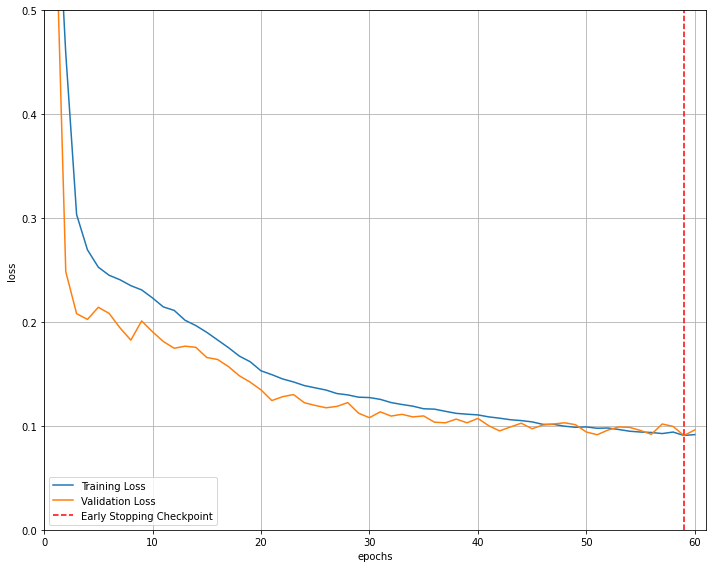

Dice2 score: 0.969970703125


In [ ]:
n_bs = [16]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "./Train/train_250"
model_chkpt_name = "ResNet-250x250_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

#### model(4layer) - 500x500 images

Batch size: 1, Learning rate: 0.001 , Epochs: 60



  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validation loss decreased (inf --> 0.143001).  Saving model ...


  2%|▏         | 1/60 [00:31<31:25, 31.95s/it]

Train Epoch: 1 @ 11:21:47.652167 - Train Loss: 0.2067 - Valid Loss: 0.1430
Validation loss decreased (0.143001 --> 0.134718).  Saving model ...


  3%|▎         | 2/60 [01:02<30:33, 31.61s/it]

Train Epoch: 2 @ 11:22:18.481014 - Train Loss: 0.1549 - Valid Loss: 0.1347
Validation loss decreased (0.134718 --> 0.133663).  Saving model ...


  5%|▌         | 3/60 [01:33<29:48, 31.38s/it]

Train Epoch: 3 @ 11:22:49.306857 - Train Loss: 0.1437 - Valid Loss: 0.1337
EarlyStopping counter: 1 out of 10


  7%|▋         | 4/60 [02:03<28:58, 31.04s/it]

Train Epoch: 4 @ 11:23:19.573183 - Train Loss: 0.1350 - Valid Loss: 0.1409
Validation loss decreased (0.133663 --> 0.108539).  Saving model ...


  8%|▊         | 5/60 [02:34<28:21, 30.95s/it]

Train Epoch: 5 @ 11:23:50.288328 - Train Loss: 0.1263 - Valid Loss: 0.1085
EarlyStopping counter: 1 out of 10


 10%|█         | 6/60 [03:05<27:42, 30.79s/it]

Train Epoch: 6 @ 11:24:20.724095 - Train Loss: 0.1180 - Valid Loss: 0.1731
Validation loss decreased (0.108539 --> 0.102440).  Saving model ...


 12%|█▏        | 7/60 [03:35<27:09, 30.74s/it]

Train Epoch: 7 @ 11:24:51.353848 - Train Loss: 0.1139 - Valid Loss: 0.1024
EarlyStopping counter: 1 out of 10


 13%|█▎        | 8/60 [04:05<26:32, 30.62s/it]

Train Epoch: 8 @ 11:25:21.688912 - Train Loss: 0.1065 - Valid Loss: 0.1097
Validation loss decreased (0.102440 --> 0.100756).  Saving model ...


 15%|█▌        | 9/60 [04:36<25:58, 30.55s/it]

Train Epoch: 9 @ 11:25:52.078400 - Train Loss: 0.0987 - Valid Loss: 0.1008
EarlyStopping counter: 1 out of 10


 17%|█▋        | 10/60 [05:06<25:27, 30.56s/it]

Train Epoch: 10 @ 11:26:22.642399 - Train Loss: 0.0927 - Valid Loss: 0.1063
EarlyStopping counter: 2 out of 10


 18%|█▊        | 11/60 [05:37<24:55, 30.52s/it]

Train Epoch: 11 @ 11:26:53.069134 - Train Loss: 0.0953 - Valid Loss: 0.1305
EarlyStopping counter: 3 out of 10


 20%|██        | 12/60 [06:07<24:25, 30.54s/it]

Train Epoch: 12 @ 11:27:23.666013 - Train Loss: 0.0875 - Valid Loss: 0.1023
EarlyStopping counter: 4 out of 10


 22%|██▏       | 13/60 [06:38<23:53, 30.51s/it]

Train Epoch: 13 @ 11:27:54.100108 - Train Loss: 0.0977 - Valid Loss: 0.1011
EarlyStopping counter: 5 out of 10


 23%|██▎       | 14/60 [07:08<23:18, 30.39s/it]

Train Epoch: 14 @ 11:28:24.218923 - Train Loss: 0.0854 - Valid Loss: 0.1058
Validation loss decreased (0.100756 --> 0.093768).  Saving model ...


 25%|██▌       | 15/60 [07:39<22:56, 30.59s/it]

Train Epoch: 15 @ 11:28:55.261035 - Train Loss: 0.0863 - Valid Loss: 0.0938
EarlyStopping counter: 1 out of 10


 27%|██▋       | 16/60 [08:09<22:22, 30.50s/it]

Train Epoch: 16 @ 11:29:25.568074 - Train Loss: 0.0784 - Valid Loss: 0.0976
EarlyStopping counter: 2 out of 10


 28%|██▊       | 17/60 [08:40<21:48, 30.44s/it]

Train Epoch: 17 @ 11:29:55.865862 - Train Loss: 0.0747 - Valid Loss: 0.0952
Validation loss decreased (0.093768 --> 0.090318).  Saving model ...


 30%|███       | 18/60 [09:11<21:25, 30.61s/it]

Train Epoch: 18 @ 11:30:26.867495 - Train Loss: 0.0737 - Valid Loss: 0.0903
EarlyStopping counter: 1 out of 10


 32%|███▏      | 19/60 [09:41<20:52, 30.54s/it]

Train Epoch: 19 @ 11:30:57.236609 - Train Loss: 0.0714 - Valid Loss: 0.0949
EarlyStopping counter: 2 out of 10


 33%|███▎      | 20/60 [10:12<20:23, 30.58s/it]

Train Epoch: 20 @ 11:31:27.924267 - Train Loss: 0.0757 - Valid Loss: 0.0949
EarlyStopping counter: 3 out of 10


 35%|███▌      | 21/60 [10:42<19:52, 30.59s/it]

Train Epoch: 21 @ 11:31:58.528421 - Train Loss: 0.0708 - Valid Loss: 0.1058
EarlyStopping counter: 4 out of 10


 37%|███▋      | 22/60 [11:13<19:22, 30.59s/it]

Train Epoch: 22 @ 11:32:29.123624 - Train Loss: 0.0684 - Valid Loss: 0.1035
EarlyStopping counter: 5 out of 10


 38%|███▊      | 23/60 [11:46<19:19, 31.33s/it]

Train Epoch: 23 @ 11:33:02.169642 - Train Loss: 0.0666 - Valid Loss: 0.0999
EarlyStopping counter: 6 out of 10


 40%|████      | 24/60 [12:16<18:36, 31.01s/it]

Train Epoch: 24 @ 11:33:32.439218 - Train Loss: 0.0745 - Valid Loss: 0.1025
EarlyStopping counter: 7 out of 10


 42%|████▏     | 25/60 [12:47<18:01, 30.90s/it]

Train Epoch: 25 @ 11:34:03.094234 - Train Loss: 0.0682 - Valid Loss: 0.0919
EarlyStopping counter: 8 out of 10


 43%|████▎     | 26/60 [13:17<17:23, 30.68s/it]

Train Epoch: 26 @ 11:34:33.256275 - Train Loss: 0.0698 - Valid Loss: 0.0967
EarlyStopping counter: 9 out of 10


 45%|████▌     | 27/60 [13:48<16:51, 30.66s/it]

Train Epoch: 27 @ 11:35:03.856023 - Train Loss: 0.0654 - Valid Loss: 0.1070
EarlyStopping counter: 10 out of 10
Early stopping


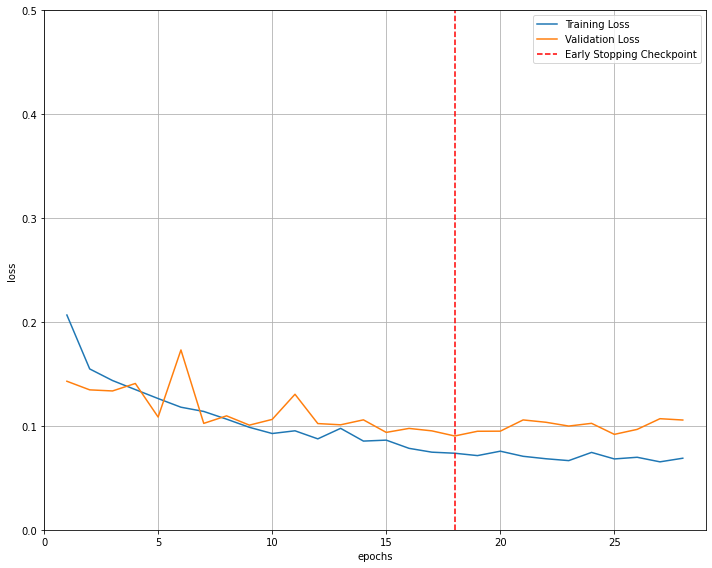

Dice2 score: 0.9242273966471354
Batch size: 1, Learning rate: 0.0001 , Epochs: 60




  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.137523).  Saving model ...



  2%|▏         | 1/60 [00:31<30:46, 31.30s/it]

Train Epoch: 1 @ 11:36:06.091010 - Train Loss: 0.2876 - Valid Loss: 0.1375
Validation loss decreased (0.137523 --> 0.120590).  Saving model ...



  3%|▎         | 2/60 [01:02<30:13, 31.26s/it]

Train Epoch: 2 @ 11:36:37.273893 - Train Loss: 0.1932 - Valid Loss: 0.1206
Validation loss decreased (0.120590 --> 0.100218).  Saving model ...



  5%|▌         | 3/60 [01:36<30:30, 32.12s/it]

Train Epoch: 3 @ 11:37:11.394068 - Train Loss: 0.1565 - Valid Loss: 0.1002
EarlyStopping counter: 1 out of 10



  7%|▋         | 4/60 [02:07<29:38, 31.76s/it]

Train Epoch: 4 @ 11:37:42.309453 - Train Loss: 0.1438 - Valid Loss: 0.1043
Validation loss decreased (0.100218 --> 0.093508).  Saving model ...



  8%|▊         | 5/60 [02:38<28:59, 31.62s/it]

Train Epoch: 5 @ 11:38:13.603236 - Train Loss: 0.1316 - Valid Loss: 0.0935
Validation loss decreased (0.093508 --> 0.084180).  Saving model ...



 10%|█         | 6/60 [03:10<28:25, 31.59s/it]

Train Epoch: 6 @ 11:38:45.134285 - Train Loss: 0.1176 - Valid Loss: 0.0842
EarlyStopping counter: 1 out of 10



 12%|█▏        | 7/60 [03:41<27:46, 31.44s/it]

Train Epoch: 7 @ 11:39:16.202721 - Train Loss: 0.1066 - Valid Loss: 0.0878
Validation loss decreased (0.084180 --> 0.076406).  Saving model ...



 13%|█▎        | 8/60 [04:12<27:11, 31.37s/it]

Train Epoch: 8 @ 11:39:47.432564 - Train Loss: 0.0977 - Valid Loss: 0.0764
Validation loss decreased (0.076406 --> 0.074707).  Saving model ...



 15%|█▌        | 9/60 [04:44<26:42, 31.43s/it]

Train Epoch: 9 @ 11:40:18.991072 - Train Loss: 0.0870 - Valid Loss: 0.0747
EarlyStopping counter: 1 out of 10



 17%|█▋        | 10/60 [05:14<25:59, 31.19s/it]

Train Epoch: 10 @ 11:40:49.610710 - Train Loss: 0.0803 - Valid Loss: 0.0755
Validation loss decreased (0.074707 --> 0.074436).  Saving model ...



 18%|█▊        | 11/60 [05:46<25:40, 31.43s/it]

Train Epoch: 11 @ 11:41:21.609485 - Train Loss: 0.0762 - Valid Loss: 0.0744
Validation loss decreased (0.074436 --> 0.074152).  Saving model ...



 20%|██        | 12/60 [06:18<25:05, 31.37s/it]

Train Epoch: 12 @ 11:41:52.830702 - Train Loss: 0.0732 - Valid Loss: 0.0742
EarlyStopping counter: 1 out of 10



 22%|██▏       | 13/60 [06:49<24:29, 31.26s/it]

Train Epoch: 13 @ 11:42:23.843515 - Train Loss: 0.0681 - Valid Loss: 0.0744
EarlyStopping counter: 2 out of 10



 23%|██▎       | 14/60 [07:19<23:49, 31.08s/it]

Train Epoch: 14 @ 11:42:54.516392 - Train Loss: 0.0647 - Valid Loss: 0.0791
EarlyStopping counter: 3 out of 10



 25%|██▌       | 15/60 [07:51<23:21, 31.15s/it]

Train Epoch: 15 @ 11:43:25.832735 - Train Loss: 0.0615 - Valid Loss: 0.0750
Validation loss decreased (0.074152 --> 0.072022).  Saving model ...



 27%|██▋       | 16/60 [08:22<23:00, 31.37s/it]

Train Epoch: 16 @ 11:43:57.692344 - Train Loss: 0.0588 - Valid Loss: 0.0720
EarlyStopping counter: 1 out of 10



 28%|██▊       | 17/60 [08:53<22:22, 31.22s/it]

Train Epoch: 17 @ 11:44:28.559073 - Train Loss: 0.0628 - Valid Loss: 0.0864
EarlyStopping counter: 2 out of 10



 30%|███       | 18/60 [09:24<21:47, 31.12s/it]

Train Epoch: 18 @ 11:44:59.470791 - Train Loss: 0.0615 - Valid Loss: 0.0754
EarlyStopping counter: 3 out of 10



 32%|███▏      | 19/60 [09:55<21:11, 31.01s/it]

Train Epoch: 19 @ 11:45:30.211670 - Train Loss: 0.0526 - Valid Loss: 0.0834
EarlyStopping counter: 4 out of 10



 33%|███▎      | 20/60 [10:26<20:39, 30.99s/it]

Train Epoch: 20 @ 11:46:01.160834 - Train Loss: 0.0489 - Valid Loss: 0.0794
EarlyStopping counter: 5 out of 10



 35%|███▌      | 21/60 [10:57<20:07, 30.96s/it]

Train Epoch: 21 @ 11:46:32.036862 - Train Loss: 0.0485 - Valid Loss: 0.0763
EarlyStopping counter: 6 out of 10



 37%|███▋      | 22/60 [11:28<19:38, 31.02s/it]

Train Epoch: 22 @ 11:47:03.220584 - Train Loss: 0.0456 - Valid Loss: 0.0793
EarlyStopping counter: 7 out of 10



 38%|███▊      | 23/60 [11:59<19:08, 31.04s/it]

Train Epoch: 23 @ 11:47:34.296757 - Train Loss: 0.0430 - Valid Loss: 0.0780
EarlyStopping counter: 8 out of 10



 40%|████      | 24/60 [12:30<18:37, 31.03s/it]

Train Epoch: 24 @ 11:48:05.309696 - Train Loss: 0.0412 - Valid Loss: 0.0826
EarlyStopping counter: 9 out of 10



 42%|████▏     | 25/60 [13:01<18:05, 31.02s/it]

Train Epoch: 25 @ 11:48:36.294227 - Train Loss: 0.0401 - Valid Loss: 0.0864
EarlyStopping counter: 10 out of 10
Early stopping


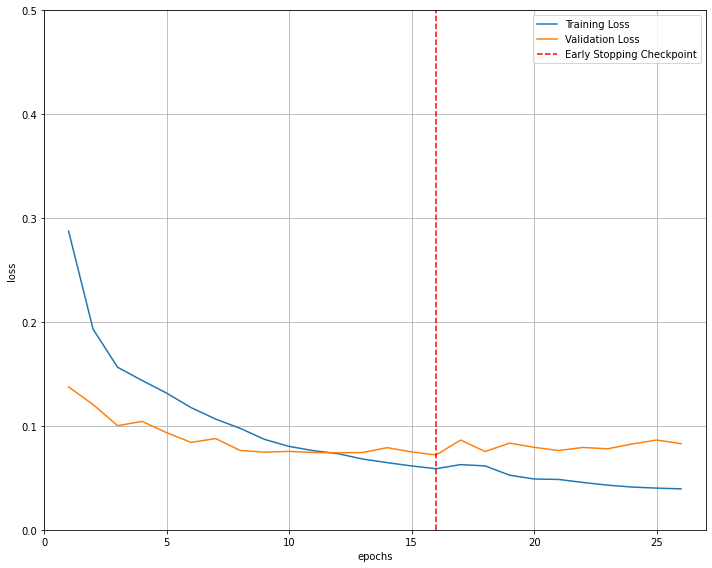

Dice2 score: 0.939419357864945
Batch size: 1, Learning rate: 1e-05 , Epochs: 60





  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.217107).  Saving model ...




  2%|▏         | 1/60 [00:31<31:14, 31.77s/it]

Train Epoch: 1 @ 11:49:39.618270 - Train Loss: 0.4085 - Valid Loss: 0.2171
Validation loss decreased (0.217107 --> 0.210802).  Saving model ...




  3%|▎         | 2/60 [01:03<30:47, 31.85s/it]

Train Epoch: 2 @ 11:50:11.671781 - Train Loss: 0.2671 - Valid Loss: 0.2108
EarlyStopping counter: 1 out of 10




  5%|▌         | 3/60 [01:34<29:56, 31.52s/it]

Train Epoch: 3 @ 11:50:42.421619 - Train Loss: 0.2514 - Valid Loss: 0.2123
Validation loss decreased (0.210802 --> 0.196858).  Saving model ...




  7%|▋         | 4/60 [02:06<29:25, 31.53s/it]

Train Epoch: 4 @ 11:51:13.978500 - Train Loss: 0.2330 - Valid Loss: 0.1969
Validation loss decreased (0.196858 --> 0.184003).  Saving model ...




  8%|▊         | 5/60 [02:48<31:58, 34.88s/it]

Train Epoch: 5 @ 11:51:56.681011 - Train Loss: 0.2114 - Valid Loss: 0.1840
Validation loss decreased (0.184003 --> 0.171279).  Saving model ...




 10%|█         | 6/60 [03:20<30:35, 34.00s/it]

Train Epoch: 6 @ 11:52:28.619729 - Train Loss: 0.1899 - Valid Loss: 0.1713
Validation loss decreased (0.171279 --> 0.161031).  Saving model ...




 12%|█▏        | 7/60 [03:52<29:26, 33.33s/it]

Train Epoch: 7 @ 11:53:00.395621 - Train Loss: 0.1728 - Valid Loss: 0.1610
Validation loss decreased (0.161031 --> 0.149017).  Saving model ...




 13%|█▎        | 8/60 [04:24<28:27, 32.84s/it]

Train Epoch: 8 @ 11:53:32.072683 - Train Loss: 0.1588 - Valid Loss: 0.1490
Validation loss decreased (0.149017 --> 0.148308).  Saving model ...




 15%|█▌        | 9/60 [04:56<27:53, 32.80s/it]

Train Epoch: 9 @ 11:54:04.802813 - Train Loss: 0.1476 - Valid Loss: 0.1483
Validation loss decreased (0.148308 --> 0.144330).  Saving model ...




 17%|█▋        | 10/60 [05:28<27:04, 32.49s/it]

Train Epoch: 10 @ 11:54:36.575720 - Train Loss: 0.1381 - Valid Loss: 0.1443
EarlyStopping counter: 1 out of 10




 18%|█▊        | 11/60 [05:59<26:12, 32.09s/it]

Train Epoch: 11 @ 11:55:07.731935 - Train Loss: 0.1307 - Valid Loss: 0.1454
Validation loss decreased (0.144330 --> 0.138733).  Saving model ...




 20%|██        | 12/60 [06:31<25:31, 31.90s/it]

Train Epoch: 12 @ 11:55:39.180108 - Train Loss: 0.1243 - Valid Loss: 0.1387
Validation loss decreased (0.138733 --> 0.138488).  Saving model ...




 22%|██▏       | 13/60 [07:05<25:26, 32.48s/it]

Train Epoch: 13 @ 11:56:13.030707 - Train Loss: 0.1187 - Valid Loss: 0.1385
EarlyStopping counter: 1 out of 10




 23%|██▎       | 14/60 [07:36<24:32, 32.01s/it]

Train Epoch: 14 @ 11:56:43.950443 - Train Loss: 0.1146 - Valid Loss: 0.1460
Validation loss decreased (0.138488 --> 0.132370).  Saving model ...




 25%|██▌       | 15/60 [08:07<23:57, 31.93s/it]

Train Epoch: 15 @ 11:57:15.698403 - Train Loss: 0.1111 - Valid Loss: 0.1324
EarlyStopping counter: 1 out of 10




 27%|██▋       | 16/60 [08:38<23:10, 31.60s/it]

Train Epoch: 16 @ 11:57:46.505614 - Train Loss: 0.1086 - Valid Loss: 0.1327
EarlyStopping counter: 2 out of 10




 28%|██▊       | 17/60 [09:11<22:59, 32.08s/it]

Train Epoch: 17 @ 11:58:19.726320 - Train Loss: 0.1073 - Valid Loss: 0.1588
EarlyStopping counter: 3 out of 10




 30%|███       | 18/60 [09:42<22:14, 31.79s/it]

Train Epoch: 18 @ 11:58:50.815518 - Train Loss: 0.1057 - Valid Loss: 0.1444
EarlyStopping counter: 4 out of 10




 32%|███▏      | 19/60 [10:14<21:35, 31.61s/it]

Train Epoch: 19 @ 11:59:22.007899 - Train Loss: 0.1024 - Valid Loss: 0.1339
EarlyStopping counter: 5 out of 10




 33%|███▎      | 20/60 [10:44<20:53, 31.34s/it]

Train Epoch: 20 @ 11:59:52.715453 - Train Loss: 0.0993 - Valid Loss: 0.1340
EarlyStopping counter: 6 out of 10




 35%|███▌      | 21/60 [11:18<20:47, 31.98s/it]

Train Epoch: 21 @ 12:00:26.191957 - Train Loss: 0.0972 - Valid Loss: 0.1506
EarlyStopping counter: 7 out of 10




 37%|███▋      | 22/60 [11:49<20:06, 31.74s/it]

Train Epoch: 22 @ 12:00:57.371254 - Train Loss: 0.0951 - Valid Loss: 0.1448
Validation loss decreased (0.132370 --> 0.128806).  Saving model ...




 38%|███▊      | 23/60 [12:20<19:29, 31.62s/it]

Train Epoch: 23 @ 12:01:28.713560 - Train Loss: 0.0931 - Valid Loss: 0.1288
EarlyStopping counter: 1 out of 10




 40%|████      | 24/60 [12:51<18:51, 31.44s/it]

Train Epoch: 24 @ 12:01:59.718391 - Train Loss: 0.0908 - Valid Loss: 0.1391
EarlyStopping counter: 2 out of 10




 42%|████▏     | 25/60 [13:24<18:37, 31.94s/it]

Train Epoch: 25 @ 12:02:32.845316 - Train Loss: 0.0890 - Valid Loss: 0.1346
EarlyStopping counter: 3 out of 10




 43%|████▎     | 26/60 [13:56<17:56, 31.67s/it]

Train Epoch: 26 @ 12:03:03.871310 - Train Loss: 0.0871 - Valid Loss: 0.1305
Validation loss decreased (0.128806 --> 0.127921).  Saving model ...




 45%|████▌     | 27/60 [14:27<17:22, 31.58s/it]

Train Epoch: 27 @ 12:03:35.261861 - Train Loss: 0.0854 - Valid Loss: 0.1279
EarlyStopping counter: 1 out of 10




 47%|████▋     | 28/60 [14:58<16:43, 31.36s/it]

Train Epoch: 28 @ 12:04:06.093379 - Train Loss: 0.0818 - Valid Loss: 0.1367
EarlyStopping counter: 2 out of 10




 48%|████▊     | 29/60 [15:29<16:10, 31.30s/it]

Train Epoch: 29 @ 12:04:37.264074 - Train Loss: 0.0794 - Valid Loss: 0.1368
EarlyStopping counter: 3 out of 10




 50%|█████     | 30/60 [16:00<15:37, 31.25s/it]

Train Epoch: 30 @ 12:05:08.392118 - Train Loss: 0.0774 - Valid Loss: 0.1447
EarlyStopping counter: 4 out of 10




 52%|█████▏    | 31/60 [16:31<15:06, 31.26s/it]

Train Epoch: 31 @ 12:05:39.660921 - Train Loss: 0.0764 - Valid Loss: 0.1281
Validation loss decreased (0.127921 --> 0.126885).  Saving model ...




 53%|█████▎    | 32/60 [17:03<14:40, 31.43s/it]

Train Epoch: 32 @ 12:06:11.501656 - Train Loss: 0.0758 - Valid Loss: 0.1269
EarlyStopping counter: 1 out of 10




 55%|█████▌    | 33/60 [17:34<14:03, 31.25s/it]

Train Epoch: 33 @ 12:06:42.329282 - Train Loss: 0.0729 - Valid Loss: 0.1310
EarlyStopping counter: 2 out of 10




 57%|█████▋    | 34/60 [18:05<13:31, 31.20s/it]

Train Epoch: 34 @ 12:07:13.423341 - Train Loss: 0.0722 - Valid Loss: 0.1428
EarlyStopping counter: 3 out of 10




 58%|█████▊    | 35/60 [18:36<12:56, 31.05s/it]

Train Epoch: 35 @ 12:07:44.113314 - Train Loss: 0.0702 - Valid Loss: 0.1292
EarlyStopping counter: 4 out of 10




 60%|██████    | 36/60 [19:07<12:28, 31.19s/it]

Train Epoch: 36 @ 12:08:15.627554 - Train Loss: 0.0674 - Valid Loss: 0.1467
EarlyStopping counter: 5 out of 10




 62%|██████▏   | 37/60 [19:38<11:54, 31.08s/it]

Train Epoch: 37 @ 12:08:46.447201 - Train Loss: 0.0660 - Valid Loss: 0.1343
EarlyStopping counter: 6 out of 10




 63%|██████▎   | 38/60 [20:09<11:25, 31.16s/it]

Train Epoch: 38 @ 12:09:17.793922 - Train Loss: 0.0649 - Valid Loss: 0.1390
EarlyStopping counter: 7 out of 10




 65%|██████▌   | 39/60 [20:40<10:52, 31.08s/it]

Train Epoch: 39 @ 12:09:48.689890 - Train Loss: 0.0641 - Valid Loss: 0.1352
EarlyStopping counter: 8 out of 10




 67%|██████▋   | 40/60 [21:12<10:23, 31.16s/it]

Train Epoch: 40 @ 12:10:20.040523 - Train Loss: 0.0632 - Valid Loss: 0.1337
EarlyStopping counter: 9 out of 10




 68%|██████▊   | 41/60 [21:43<09:50, 31.10s/it]

Train Epoch: 41 @ 12:10:50.994542 - Train Loss: 0.0622 - Valid Loss: 0.1380
EarlyStopping counter: 10 out of 10
Early stopping


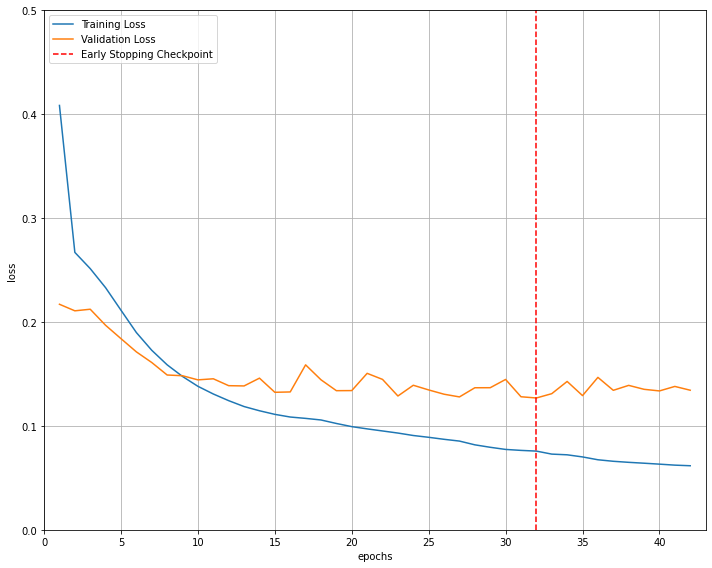

Dice2 score: 0.8932642053674769


In [ ]:
n_bs = [1]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "../Train/train_500"
model_chkpt_name = "ResNet-500x500_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

Batch size: 4, Learning rate: 0.001 , Epochs: 60






  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.198169).  Saving model ...





  2%|▏         | 1/60 [00:23<23:13, 23.62s/it]

Train Epoch: 1 @ 12:11:46.614961 - Train Loss: 0.3122 - Valid Loss: 0.1982
Validation loss decreased (0.198169 --> 0.175017).  Saving model ...





  3%|▎         | 2/60 [00:47<22:49, 23.61s/it]

Train Epoch: 2 @ 12:12:10.215473 - Train Loss: 0.1850 - Valid Loss: 0.1750
Validation loss decreased (0.175017 --> 0.150576).  Saving model ...





  5%|▌         | 3/60 [01:10<22:22, 23.56s/it]

Train Epoch: 3 @ 12:12:33.655720 - Train Loss: 0.1629 - Valid Loss: 0.1506
Validation loss decreased (0.150576 --> 0.138970).  Saving model ...





  7%|▋         | 4/60 [01:34<21:59, 23.57s/it]

Train Epoch: 4 @ 12:12:57.233240 - Train Loss: 0.1591 - Valid Loss: 0.1390
Validation loss decreased (0.138970 --> 0.135091).  Saving model ...





  8%|▊         | 5/60 [01:59<22:00, 24.01s/it]

Train Epoch: 5 @ 12:13:22.280572 - Train Loss: 0.1500 - Valid Loss: 0.1351
EarlyStopping counter: 1 out of 10





 10%|█         | 6/60 [02:22<21:18, 23.67s/it]

Train Epoch: 6 @ 12:13:45.150006 - Train Loss: 0.1450 - Valid Loss: 0.1411
EarlyStopping counter: 2 out of 10





 12%|█▏        | 7/60 [02:45<20:45, 23.50s/it]

Train Epoch: 7 @ 12:14:08.244221 - Train Loss: 0.1416 - Valid Loss: 0.1378
Validation loss decreased (0.135091 --> 0.115682).  Saving model ...





 13%|█▎        | 8/60 [03:08<20:23, 23.52s/it]

Train Epoch: 8 @ 12:14:31.831721 - Train Loss: 0.1316 - Valid Loss: 0.1157
EarlyStopping counter: 1 out of 10





 15%|█▌        | 9/60 [03:31<19:49, 23.33s/it]

Train Epoch: 9 @ 12:14:54.716164 - Train Loss: 0.1237 - Valid Loss: 0.1281
EarlyStopping counter: 2 out of 10





 17%|█▋        | 10/60 [03:54<19:23, 23.27s/it]

Train Epoch: 10 @ 12:15:17.854074 - Train Loss: 0.1309 - Valid Loss: 0.1237
Validation loss decreased (0.115682 --> 0.111540).  Saving model ...





 18%|█▊        | 11/60 [04:18<19:01, 23.29s/it]

Train Epoch: 11 @ 12:15:41.177334 - Train Loss: 0.1243 - Valid Loss: 0.1115
EarlyStopping counter: 1 out of 10





 20%|██        | 12/60 [04:40<18:30, 23.14s/it]

Train Epoch: 12 @ 12:16:03.972220 - Train Loss: 0.1150 - Valid Loss: 0.1326
EarlyStopping counter: 2 out of 10





 22%|██▏       | 13/60 [05:04<18:06, 23.12s/it]

Train Epoch: 13 @ 12:16:27.057137 - Train Loss: 0.1133 - Valid Loss: 0.1133
Validation loss decreased (0.111540 --> 0.106675).  Saving model ...





 23%|██▎       | 14/60 [05:27<17:52, 23.31s/it]

Train Epoch: 14 @ 12:16:50.785382 - Train Loss: 0.1086 - Valid Loss: 0.1067
Validation loss decreased (0.106675 --> 0.103859).  Saving model ...





 25%|██▌       | 15/60 [05:52<17:45, 23.68s/it]

Train Epoch: 15 @ 12:17:15.346430 - Train Loss: 0.1106 - Valid Loss: 0.1039
EarlyStopping counter: 1 out of 10





 27%|██▋       | 16/60 [06:15<17:12, 23.46s/it]

Train Epoch: 16 @ 12:17:38.273397 - Train Loss: 0.1044 - Valid Loss: 0.1386
Validation loss decreased (0.103859 --> 0.096817).  Saving model ...





 28%|██▊       | 17/60 [06:38<16:50, 23.50s/it]

Train Epoch: 17 @ 12:18:01.893194 - Train Loss: 0.1089 - Valid Loss: 0.0968
EarlyStopping counter: 1 out of 10





 30%|███       | 18/60 [07:01<16:19, 23.33s/it]

Train Epoch: 18 @ 12:18:24.808936 - Train Loss: 0.0996 - Valid Loss: 0.0978
Validation loss decreased (0.096817 --> 0.088126).  Saving model ...





 32%|███▏      | 19/60 [07:25<15:57, 23.36s/it]

Train Epoch: 19 @ 12:18:48.248778 - Train Loss: 0.1001 - Valid Loss: 0.0881
Validation loss decreased (0.088126 --> 0.086053).  Saving model ...





 33%|███▎      | 20/60 [07:48<15:37, 23.43s/it]

Train Epoch: 20 @ 12:19:11.846991 - Train Loss: 0.0952 - Valid Loss: 0.0861
EarlyStopping counter: 1 out of 10





 35%|███▌      | 21/60 [08:11<15:08, 23.28s/it]

Train Epoch: 21 @ 12:19:34.783372 - Train Loss: 0.0916 - Valid Loss: 0.0968
EarlyStopping counter: 2 out of 10





 37%|███▋      | 22/60 [08:34<14:41, 23.19s/it]

Train Epoch: 22 @ 12:19:57.754638 - Train Loss: 0.0920 - Valid Loss: 0.1026
EarlyStopping counter: 3 out of 10





 38%|███▊      | 23/60 [08:57<14:16, 23.14s/it]

Train Epoch: 23 @ 12:20:20.764070 - Train Loss: 0.0901 - Valid Loss: 0.0870
EarlyStopping counter: 4 out of 10





 40%|████      | 24/60 [09:20<13:50, 23.07s/it]

Train Epoch: 24 @ 12:20:43.671218 - Train Loss: 0.0918 - Valid Loss: 0.0881
EarlyStopping counter: 5 out of 10





 42%|████▏     | 25/60 [09:43<13:26, 23.03s/it]

Train Epoch: 25 @ 12:21:06.631156 - Train Loss: 0.0863 - Valid Loss: 0.0863
EarlyStopping counter: 6 out of 10





 43%|████▎     | 26/60 [10:06<13:04, 23.06s/it]

Train Epoch: 26 @ 12:21:29.756758 - Train Loss: 0.0893 - Valid Loss: 0.1029
EarlyStopping counter: 7 out of 10





 45%|████▌     | 27/60 [10:29<12:42, 23.10s/it]

Train Epoch: 27 @ 12:21:52.949454 - Train Loss: 0.0994 - Valid Loss: 0.0933
Validation loss decreased (0.086053 --> 0.084594).  Saving model ...





 47%|████▋     | 28/60 [10:53<12:22, 23.19s/it]

Train Epoch: 28 @ 12:22:16.361718 - Train Loss: 0.0913 - Valid Loss: 0.0846
EarlyStopping counter: 1 out of 10





 48%|████▊     | 29/60 [11:16<11:58, 23.16s/it]

Train Epoch: 29 @ 12:22:39.450447 - Train Loss: 0.0877 - Valid Loss: 0.0896
EarlyStopping counter: 2 out of 10





 50%|█████     | 30/60 [11:39<11:34, 23.15s/it]

Train Epoch: 30 @ 12:23:02.578708 - Train Loss: 0.0843 - Valid Loss: 0.0931
EarlyStopping counter: 3 out of 10





 52%|█████▏    | 31/60 [12:02<11:09, 23.09s/it]

Train Epoch: 31 @ 12:23:25.539124 - Train Loss: 0.0807 - Valid Loss: 0.0959
EarlyStopping counter: 4 out of 10





 53%|█████▎    | 32/60 [12:25<10:45, 23.06s/it]

Train Epoch: 32 @ 12:23:48.510435 - Train Loss: 0.0836 - Valid Loss: 0.0975
EarlyStopping counter: 5 out of 10





 55%|█████▌    | 33/60 [12:48<10:23, 23.08s/it]

Train Epoch: 33 @ 12:24:11.637328 - Train Loss: 0.0824 - Valid Loss: 0.0992
EarlyStopping counter: 6 out of 10





 57%|█████▋    | 34/60 [13:11<09:58, 23.03s/it]

Train Epoch: 34 @ 12:24:34.544695 - Train Loss: 0.0836 - Valid Loss: 0.0890
EarlyStopping counter: 7 out of 10





 58%|█████▊    | 35/60 [13:34<09:35, 23.03s/it]

Train Epoch: 35 @ 12:24:57.572732 - Train Loss: 0.0784 - Valid Loss: 0.0875
Validation loss decreased (0.084594 --> 0.079070).  Saving model ...





 60%|██████    | 36/60 [13:58<09:17, 23.21s/it]

Train Epoch: 36 @ 12:25:21.204944 - Train Loss: 0.0759 - Valid Loss: 0.0791
EarlyStopping counter: 1 out of 10





 62%|██████▏   | 37/60 [14:21<08:51, 23.11s/it]

Train Epoch: 37 @ 12:25:44.074377 - Train Loss: 0.0746 - Valid Loss: 0.0853
EarlyStopping counter: 2 out of 10





 63%|██████▎   | 38/60 [14:44<08:27, 23.09s/it]

Train Epoch: 38 @ 12:26:07.115335 - Train Loss: 0.0762 - Valid Loss: 0.0845
EarlyStopping counter: 3 out of 10





 65%|██████▌   | 39/60 [15:07<08:04, 23.07s/it]

Train Epoch: 39 @ 12:26:30.141692 - Train Loss: 0.0734 - Valid Loss: 0.0857
EarlyStopping counter: 4 out of 10





 67%|██████▋   | 40/60 [15:30<07:41, 23.06s/it]

Train Epoch: 40 @ 12:26:53.184071 - Train Loss: 0.0701 - Valid Loss: 0.0855
EarlyStopping counter: 5 out of 10





 68%|██████▊   | 41/60 [15:53<07:18, 23.08s/it]

Train Epoch: 41 @ 12:27:16.321792 - Train Loss: 0.0707 - Valid Loss: 0.0823
EarlyStopping counter: 6 out of 10





 70%|███████   | 42/60 [16:16<06:55, 23.10s/it]

Train Epoch: 42 @ 12:27:39.475355 - Train Loss: 0.0710 - Valid Loss: 0.0846
EarlyStopping counter: 7 out of 10





 72%|███████▏  | 43/60 [16:39<06:32, 23.11s/it]

Train Epoch: 43 @ 12:28:02.597999 - Train Loss: 0.0688 - Valid Loss: 0.0809
EarlyStopping counter: 8 out of 10





 73%|███████▎  | 44/60 [17:02<06:08, 23.06s/it]

Train Epoch: 44 @ 12:28:25.524980 - Train Loss: 0.0690 - Valid Loss: 0.0825
EarlyStopping counter: 9 out of 10





 75%|███████▌  | 45/60 [17:25<05:46, 23.07s/it]

Train Epoch: 45 @ 12:28:48.622453 - Train Loss: 0.0665 - Valid Loss: 0.0820
EarlyStopping counter: 10 out of 10
Early stopping


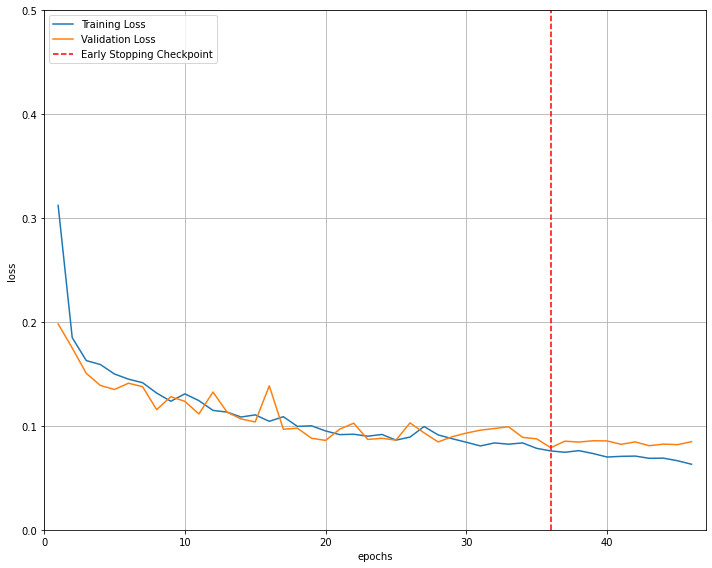

Dice2 score: 0.9607353210449219
Batch size: 4, Learning rate: 0.0001 , Epochs: 60







  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.234350).  Saving model ...






  2%|▏         | 1/60 [00:23<23:22, 23.77s/it]

Train Epoch: 1 @ 12:29:36.268474 - Train Loss: 0.3875 - Valid Loss: 0.2343
Validation loss decreased (0.234350 --> 0.194473).  Saving model ...






  3%|▎         | 2/60 [00:47<22:57, 23.75s/it]

Train Epoch: 2 @ 12:29:59.975262 - Train Loss: 0.2508 - Valid Loss: 0.1945
Validation loss decreased (0.194473 --> 0.165331).  Saving model ...






  5%|▌         | 3/60 [01:11<22:34, 23.76s/it]

Train Epoch: 3 @ 12:30:23.744282 - Train Loss: 0.2133 - Valid Loss: 0.1653
Validation loss decreased (0.165331 --> 0.157299).  Saving model ...






  7%|▋         | 4/60 [01:34<22:08, 23.72s/it]

Train Epoch: 4 @ 12:30:47.384139 - Train Loss: 0.1869 - Valid Loss: 0.1573
Validation loss decreased (0.157299 --> 0.141242).  Saving model ...






  8%|▊         | 5/60 [01:58<21:47, 23.77s/it]

Train Epoch: 5 @ 12:31:11.282262 - Train Loss: 0.1723 - Valid Loss: 0.1412
EarlyStopping counter: 1 out of 10






 10%|█         | 6/60 [02:21<21:14, 23.60s/it]

Train Epoch: 6 @ 12:31:34.482923 - Train Loss: 0.1628 - Valid Loss: 0.1435
Validation loss decreased (0.141242 --> 0.122062).  Saving model ...






 12%|█▏        | 7/60 [02:45<20:49, 23.58s/it]

Train Epoch: 7 @ 12:31:58.020742 - Train Loss: 0.1446 - Valid Loss: 0.1221
Validation loss decreased (0.122062 --> 0.116661).  Saving model ...






 13%|█▎        | 8/60 [03:10<20:51, 24.08s/it]

Train Epoch: 8 @ 12:32:23.245910 - Train Loss: 0.1338 - Valid Loss: 0.1167
Validation loss decreased (0.116661 --> 0.105580).  Saving model ...






 15%|█▌        | 9/60 [03:34<20:27, 24.07s/it]

Train Epoch: 9 @ 12:32:47.290898 - Train Loss: 0.1288 - Valid Loss: 0.1056
EarlyStopping counter: 1 out of 10






 17%|█▋        | 10/60 [03:57<19:49, 23.79s/it]

Train Epoch: 10 @ 12:33:10.450579 - Train Loss: 0.1257 - Valid Loss: 0.1102
EarlyStopping counter: 2 out of 10






 18%|█▊        | 11/60 [04:20<19:14, 23.57s/it]

Train Epoch: 11 @ 12:33:33.482305 - Train Loss: 0.1229 - Valid Loss: 0.1060
Validation loss decreased (0.105580 --> 0.105244).  Saving model ...






 20%|██        | 12/60 [04:44<18:55, 23.67s/it]

Train Epoch: 12 @ 12:33:57.379727 - Train Loss: 0.1123 - Valid Loss: 0.1052
Validation loss decreased (0.105244 --> 0.098530).  Saving model ...






 22%|██▏       | 13/60 [05:08<18:33, 23.69s/it]

Train Epoch: 13 @ 12:34:21.142890 - Train Loss: 0.1044 - Valid Loss: 0.0985
Validation loss decreased (0.098530 --> 0.096029).  Saving model ...






 23%|██▎       | 14/60 [05:32<18:08, 23.66s/it]

Train Epoch: 14 @ 12:34:44.711504 - Train Loss: 0.1007 - Valid Loss: 0.0960
EarlyStopping counter: 1 out of 10






 25%|██▌       | 15/60 [05:56<17:57, 23.94s/it]

Train Epoch: 15 @ 12:35:09.303541 - Train Loss: 0.0989 - Valid Loss: 0.0967
EarlyStopping counter: 2 out of 10






 27%|██▋       | 16/60 [06:19<17:21, 23.68s/it]

Train Epoch: 16 @ 12:35:32.372515 - Train Loss: 0.0974 - Valid Loss: 0.1025
Validation loss decreased (0.096029 --> 0.092630).  Saving model ...






 28%|██▊       | 17/60 [06:44<17:06, 23.88s/it]

Train Epoch: 17 @ 12:35:56.726619 - Train Loss: 0.0932 - Valid Loss: 0.0926
EarlyStopping counter: 1 out of 10






 30%|███       | 18/60 [07:07<16:36, 23.72s/it]

Train Epoch: 18 @ 12:36:20.074612 - Train Loss: 0.0858 - Valid Loss: 0.0941
EarlyStopping counter: 2 out of 10






 32%|███▏      | 19/60 [07:30<16:05, 23.55s/it]

Train Epoch: 19 @ 12:36:43.240617 - Train Loss: 0.0831 - Valid Loss: 0.0957
EarlyStopping counter: 3 out of 10






 33%|███▎      | 20/60 [07:54<15:39, 23.49s/it]

Train Epoch: 20 @ 12:37:06.573231 - Train Loss: 0.0827 - Valid Loss: 0.0936
Validation loss decreased (0.092630 --> 0.089676).  Saving model ...






 35%|███▌      | 21/60 [08:17<15:19, 23.59s/it]

Train Epoch: 21 @ 12:37:30.388874 - Train Loss: 0.0804 - Valid Loss: 0.0897
Validation loss decreased (0.089676 --> 0.086291).  Saving model ...






 37%|███▋      | 22/60 [08:41<14:56, 23.60s/it]

Train Epoch: 22 @ 12:37:54.016479 - Train Loss: 0.0766 - Valid Loss: 0.0863
EarlyStopping counter: 1 out of 10






 38%|███▊      | 23/60 [09:04<14:30, 23.53s/it]

Train Epoch: 23 @ 12:38:17.386668 - Train Loss: 0.0730 - Valid Loss: 0.0907
EarlyStopping counter: 2 out of 10






 40%|████      | 24/60 [09:28<14:04, 23.47s/it]

Train Epoch: 24 @ 12:38:40.715157 - Train Loss: 0.0728 - Valid Loss: 0.0897
Validation loss decreased (0.086291 --> 0.085232).  Saving model ...






 42%|████▏     | 25/60 [09:52<13:48, 23.67s/it]

Train Epoch: 25 @ 12:39:04.845993 - Train Loss: 0.0713 - Valid Loss: 0.0852
EarlyStopping counter: 1 out of 10






 43%|████▎     | 26/60 [10:15<13:19, 23.53s/it]

Train Epoch: 26 @ 12:39:28.046975 - Train Loss: 0.0696 - Valid Loss: 0.0873
EarlyStopping counter: 2 out of 10






 45%|████▌     | 27/60 [10:39<12:56, 23.54s/it]

Train Epoch: 27 @ 12:39:51.630781 - Train Loss: 0.0661 - Valid Loss: 0.0864
EarlyStopping counter: 3 out of 10






 47%|████▋     | 28/60 [11:02<12:30, 23.45s/it]

Train Epoch: 28 @ 12:40:14.876438 - Train Loss: 0.0636 - Valid Loss: 0.0882
Validation loss decreased (0.085232 --> 0.084516).  Saving model ...






 48%|████▊     | 29/60 [11:26<12:09, 23.52s/it]

Train Epoch: 29 @ 12:40:38.558046 - Train Loss: 0.0623 - Valid Loss: 0.0845
EarlyStopping counter: 1 out of 10






 50%|█████     | 30/60 [11:49<11:44, 23.47s/it]

Train Epoch: 30 @ 12:41:01.911777 - Train Loss: 0.0595 - Valid Loss: 0.0854
EarlyStopping counter: 2 out of 10






 52%|█████▏    | 31/60 [12:12<11:19, 23.44s/it]

Train Epoch: 31 @ 12:41:25.261769 - Train Loss: 0.0581 - Valid Loss: 0.0846
EarlyStopping counter: 3 out of 10






 53%|█████▎    | 32/60 [12:35<10:54, 23.36s/it]

Train Epoch: 32 @ 12:41:48.437057 - Train Loss: 0.0582 - Valid Loss: 0.0897
EarlyStopping counter: 4 out of 10






 55%|█████▌    | 33/60 [12:59<10:30, 23.34s/it]

Train Epoch: 33 @ 12:42:11.748496 - Train Loss: 0.0600 - Valid Loss: 0.0889
EarlyStopping counter: 5 out of 10






 57%|█████▋    | 34/60 [13:22<10:05, 23.30s/it]

Train Epoch: 34 @ 12:42:34.949518 - Train Loss: 0.0562 - Valid Loss: 0.0896
EarlyStopping counter: 6 out of 10






 58%|█████▊    | 35/60 [13:45<09:40, 23.23s/it]

Train Epoch: 35 @ 12:42:58.028887 - Train Loss: 0.0557 - Valid Loss: 0.0862
EarlyStopping counter: 7 out of 10






 60%|██████    | 36/60 [14:14<09:56, 24.84s/it]

Train Epoch: 36 @ 12:43:26.610647 - Train Loss: 0.0552 - Valid Loss: 0.0880
Validation loss decreased (0.084516 --> 0.084255).  Saving model ...






 62%|██████▏   | 37/60 [14:39<09:34, 25.00s/it]

Train Epoch: 37 @ 12:43:51.982997 - Train Loss: 0.0558 - Valid Loss: 0.0843
EarlyStopping counter: 1 out of 10






 63%|██████▎   | 38/60 [15:02<08:58, 24.49s/it]

Train Epoch: 38 @ 12:44:15.288268 - Train Loss: 0.0534 - Valid Loss: 0.0875
EarlyStopping counter: 2 out of 10






 65%|██████▌   | 39/60 [15:26<08:26, 24.11s/it]

Train Epoch: 39 @ 12:44:38.521884 - Train Loss: 0.0523 - Valid Loss: 0.0863
EarlyStopping counter: 3 out of 10






 67%|██████▋   | 40/60 [15:49<07:57, 23.88s/it]

Train Epoch: 40 @ 12:45:01.869655 - Train Loss: 0.0490 - Valid Loss: 0.0878
EarlyStopping counter: 4 out of 10






 68%|██████▊   | 41/60 [16:12<07:29, 23.67s/it]

Train Epoch: 41 @ 12:45:25.028529 - Train Loss: 0.0478 - Valid Loss: 0.0851
EarlyStopping counter: 5 out of 10






 70%|███████   | 42/60 [16:35<07:03, 23.55s/it]

Train Epoch: 42 @ 12:45:48.309561 - Train Loss: 0.0460 - Valid Loss: 0.0881
EarlyStopping counter: 6 out of 10






 72%|███████▏  | 43/60 [16:59<06:39, 23.51s/it]

Train Epoch: 43 @ 12:46:11.731370 - Train Loss: 0.0450 - Valid Loss: 0.0854
EarlyStopping counter: 7 out of 10






 73%|███████▎  | 44/60 [17:22<06:15, 23.45s/it]

Train Epoch: 44 @ 12:46:35.021205 - Train Loss: 0.0448 - Valid Loss: 0.0886
EarlyStopping counter: 8 out of 10






 75%|███████▌  | 45/60 [17:45<05:50, 23.39s/it]

Train Epoch: 45 @ 12:46:58.291257 - Train Loss: 0.0441 - Valid Loss: 0.0861
EarlyStopping counter: 9 out of 10






 77%|███████▋  | 46/60 [18:09<05:27, 23.38s/it]

Train Epoch: 46 @ 12:47:21.635733 - Train Loss: 0.0434 - Valid Loss: 0.0872
EarlyStopping counter: 10 out of 10
Early stopping


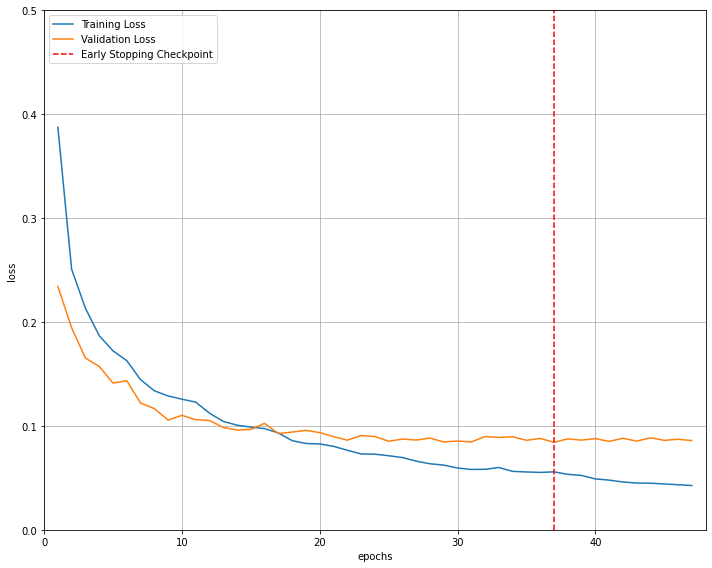

Dice2 score: 0.9671456473214286
Batch size: 4, Learning rate: 1e-05 , Epochs: 60








  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.608608).  Saving model ...







  2%|▏         | 1/60 [00:25<24:54, 25.32s/it]

Train Epoch: 1 @ 12:48:10.921463 - Train Loss: 0.6678 - Valid Loss: 0.6086
Validation loss decreased (0.608608 --> 0.265645).  Saving model ...







  3%|▎         | 2/60 [00:49<24:04, 24.90s/it]

Train Epoch: 2 @ 12:48:34.850499 - Train Loss: 0.4121 - Valid Loss: 0.2656
Validation loss decreased (0.265645 --> 0.257539).  Saving model ...







  5%|▌         | 3/60 [01:13<23:20, 24.57s/it]

Train Epoch: 3 @ 12:48:58.636925 - Train Loss: 0.2723 - Valid Loss: 0.2575
EarlyStopping counter: 1 out of 10







  7%|▋         | 4/60 [01:36<22:36, 24.23s/it]

Train Epoch: 4 @ 12:49:22.068557 - Train Loss: 0.2537 - Valid Loss: 0.2655
Validation loss decreased (0.257539 --> 0.248753).  Saving model ...







  8%|▊         | 5/60 [02:00<22:07, 24.13s/it]

Train Epoch: 5 @ 12:49:45.978453 - Train Loss: 0.2465 - Valid Loss: 0.2488
EarlyStopping counter: 1 out of 10







 10%|█         | 6/60 [02:23<21:29, 23.88s/it]

Train Epoch: 6 @ 12:50:09.277342 - Train Loss: 0.2406 - Valid Loss: 0.2517
Validation loss decreased (0.248753 --> 0.243423).  Saving model ...







 12%|█▏        | 7/60 [02:47<21:02, 23.83s/it]

Train Epoch: 7 @ 12:50:32.972211 - Train Loss: 0.2369 - Valid Loss: 0.2434
EarlyStopping counter: 1 out of 10







 13%|█▎        | 8/60 [03:10<20:31, 23.69s/it]

Train Epoch: 8 @ 12:50:56.340514 - Train Loss: 0.2319 - Valid Loss: 0.2509
Validation loss decreased (0.243423 --> 0.239326).  Saving model ...







 15%|█▌        | 9/60 [03:34<20:12, 23.77s/it]

Train Epoch: 9 @ 12:51:20.289906 - Train Loss: 0.2268 - Valid Loss: 0.2393
Validation loss decreased (0.239326 --> 0.238863).  Saving model ...







 17%|█▋        | 10/60 [03:58<19:48, 23.78s/it]

Train Epoch: 10 @ 12:51:44.091715 - Train Loss: 0.2179 - Valid Loss: 0.2389
Validation loss decreased (0.238863 --> 0.228000).  Saving model ...







 18%|█▊        | 11/60 [04:22<19:29, 23.88s/it]

Train Epoch: 11 @ 12:52:08.195155 - Train Loss: 0.2124 - Valid Loss: 0.2280
Validation loss decreased (0.228000 --> 0.224737).  Saving model ...







 20%|██        | 12/60 [04:46<19:05, 23.87s/it]

Train Epoch: 12 @ 12:52:32.051996 - Train Loss: 0.2041 - Valid Loss: 0.2247
Validation loss decreased (0.224737 --> 0.218199).  Saving model ...







 22%|██▏       | 13/60 [05:10<18:40, 23.83s/it]

Train Epoch: 13 @ 12:52:55.793542 - Train Loss: 0.1943 - Valid Loss: 0.2182
Validation loss decreased (0.218199 --> 0.214028).  Saving model ...







 23%|██▎       | 14/60 [05:34<18:19, 23.89s/it]

Train Epoch: 14 @ 12:53:19.826259 - Train Loss: 0.1868 - Valid Loss: 0.2140
Validation loss decreased (0.214028 --> 0.197612).  Saving model ...







 25%|██▌       | 15/60 [05:59<18:09, 24.20s/it]

Train Epoch: 15 @ 12:53:44.753807 - Train Loss: 0.1763 - Valid Loss: 0.1976
Validation loss decreased (0.197612 --> 0.195214).  Saving model ...







 27%|██▋       | 16/60 [06:23<17:40, 24.10s/it]

Train Epoch: 16 @ 12:54:08.620076 - Train Loss: 0.1712 - Valid Loss: 0.1952
Validation loss decreased (0.195214 --> 0.184093).  Saving model ...







 28%|██▊       | 17/60 [06:48<17:28, 24.38s/it]

Train Epoch: 17 @ 12:54:33.654021 - Train Loss: 0.1645 - Valid Loss: 0.1841
Validation loss decreased (0.184093 --> 0.179777).  Saving model ...







 30%|███       | 18/60 [07:12<17:00, 24.30s/it]

Train Epoch: 18 @ 12:54:57.748946 - Train Loss: 0.1605 - Valid Loss: 0.1798
Validation loss decreased (0.179777 --> 0.177410).  Saving model ...







 32%|███▏      | 19/60 [07:35<16:30, 24.16s/it]

Train Epoch: 19 @ 12:55:21.590464 - Train Loss: 0.1551 - Valid Loss: 0.1774
Validation loss decreased (0.177410 --> 0.173869).  Saving model ...







 33%|███▎      | 20/60 [08:00<16:05, 24.13s/it]

Train Epoch: 20 @ 12:55:45.652528 - Train Loss: 0.1514 - Valid Loss: 0.1739
Validation loss decreased (0.173869 --> 0.172334).  Saving model ...







 35%|███▌      | 21/60 [08:24<15:40, 24.10s/it]

Train Epoch: 21 @ 12:56:09.690942 - Train Loss: 0.1498 - Valid Loss: 0.1723
EarlyStopping counter: 1 out of 10







 37%|███▋      | 22/60 [08:47<15:06, 23.85s/it]

Train Epoch: 22 @ 12:56:32.961006 - Train Loss: 0.1438 - Valid Loss: 0.1724
Validation loss decreased (0.172334 --> 0.171255).  Saving model ...







 38%|███▊      | 23/60 [09:11<14:43, 23.89s/it]

Train Epoch: 23 @ 12:56:56.939734 - Train Loss: 0.1416 - Valid Loss: 0.1713
Validation loss decreased (0.171255 --> 0.162774).  Saving model ...







 40%|████      | 24/60 [09:36<14:38, 24.39s/it]

Train Epoch: 24 @ 12:57:22.505621 - Train Loss: 0.1399 - Valid Loss: 0.1628
EarlyStopping counter: 1 out of 10







 42%|████▏     | 25/60 [10:00<14:03, 24.10s/it]

Train Epoch: 25 @ 12:57:45.927742 - Train Loss: 0.1339 - Valid Loss: 0.1635
EarlyStopping counter: 2 out of 10







 43%|████▎     | 26/60 [10:23<13:32, 23.91s/it]

Train Epoch: 26 @ 12:58:09.390897 - Train Loss: 0.1319 - Valid Loss: 0.1648
Validation loss decreased (0.162774 --> 0.160770).  Saving model ...







 45%|████▌     | 27/60 [10:47<13:09, 23.91s/it]

Train Epoch: 27 @ 12:58:33.309454 - Train Loss: 0.1312 - Valid Loss: 0.1608
Validation loss decreased (0.160770 --> 0.159950).  Saving model ...







 47%|████▋     | 28/60 [11:11<12:43, 23.87s/it]

Train Epoch: 28 @ 12:58:57.095385 - Train Loss: 0.1266 - Valid Loss: 0.1599
Validation loss decreased (0.159950 --> 0.156114).  Saving model ...







 48%|████▊     | 29/60 [11:35<12:23, 23.97s/it]

Train Epoch: 29 @ 12:59:21.283448 - Train Loss: 0.1247 - Valid Loss: 0.1561
Validation loss decreased (0.156114 --> 0.155988).  Saving model ...







 50%|█████     | 30/60 [11:59<11:58, 23.96s/it]

Train Epoch: 30 @ 12:59:45.225861 - Train Loss: 0.1239 - Valid Loss: 0.1560
Validation loss decreased (0.155988 --> 0.152750).  Saving model ...







 52%|█████▏    | 31/60 [12:23<11:34, 23.94s/it]

Train Epoch: 31 @ 13:00:09.120387 - Train Loss: 0.1256 - Valid Loss: 0.1528
EarlyStopping counter: 1 out of 10







 53%|█████▎    | 32/60 [12:47<11:08, 23.86s/it]

Train Epoch: 32 @ 13:00:32.787944 - Train Loss: 0.1216 - Valid Loss: 0.1553
EarlyStopping counter: 2 out of 10







 55%|█████▌    | 33/60 [13:10<10:42, 23.80s/it]

Train Epoch: 33 @ 13:00:56.459846 - Train Loss: 0.1190 - Valid Loss: 0.1537
EarlyStopping counter: 3 out of 10







 57%|█████▋    | 34/60 [13:34<10:15, 23.69s/it]

Train Epoch: 34 @ 13:01:19.892053 - Train Loss: 0.1238 - Valid Loss: 0.1530
EarlyStopping counter: 4 out of 10







 58%|█████▊    | 35/60 [13:57<09:51, 23.65s/it]

Train Epoch: 35 @ 13:01:43.456863 - Train Loss: 0.1179 - Valid Loss: 0.1542
Validation loss decreased (0.152750 --> 0.151909).  Saving model ...







 60%|██████    | 36/60 [14:22<09:33, 23.88s/it]

Train Epoch: 36 @ 13:02:07.880492 - Train Loss: 0.1157 - Valid Loss: 0.1519
EarlyStopping counter: 1 out of 10







 62%|██████▏   | 37/60 [14:45<09:05, 23.73s/it]

Train Epoch: 37 @ 13:02:31.245221 - Train Loss: 0.1178 - Valid Loss: 0.1552
Validation loss decreased (0.151909 --> 0.151852).  Saving model ...







 63%|██████▎   | 38/60 [15:09<08:43, 23.79s/it]

Train Epoch: 38 @ 13:02:55.185925 - Train Loss: 0.1125 - Valid Loss: 0.1519
Validation loss decreased (0.151852 --> 0.146909).  Saving model ...







 65%|██████▌   | 39/60 [15:33<08:21, 23.87s/it]

Train Epoch: 39 @ 13:03:19.242825 - Train Loss: 0.1131 - Valid Loss: 0.1469
EarlyStopping counter: 1 out of 10







 67%|██████▋   | 40/60 [15:56<07:54, 23.71s/it]

Train Epoch: 40 @ 13:03:42.561185 - Train Loss: 0.1124 - Valid Loss: 0.1508
EarlyStopping counter: 2 out of 10







 68%|██████▊   | 41/60 [16:20<07:28, 23.62s/it]

Train Epoch: 41 @ 13:04:05.977838 - Train Loss: 0.1103 - Valid Loss: 0.1498
EarlyStopping counter: 3 out of 10







 70%|███████   | 42/60 [16:43<07:05, 23.61s/it]

Train Epoch: 42 @ 13:04:29.574018 - Train Loss: 0.1085 - Valid Loss: 0.1472
Validation loss decreased (0.146909 --> 0.146838).  Saving model ...







 72%|███████▏  | 43/60 [17:07<06:42, 23.69s/it]

Train Epoch: 43 @ 13:04:53.449000 - Train Loss: 0.1080 - Valid Loss: 0.1468
Validation loss decreased (0.146838 --> 0.146653).  Saving model ...







 73%|███████▎  | 44/60 [17:31<06:20, 23.79s/it]

Train Epoch: 44 @ 13:05:17.470769 - Train Loss: 0.1072 - Valid Loss: 0.1467
Validation loss decreased (0.146653 --> 0.145049).  Saving model ...







 75%|███████▌  | 45/60 [17:56<05:59, 23.95s/it]

Train Epoch: 45 @ 13:05:41.788138 - Train Loss: 0.1073 - Valid Loss: 0.1450
Validation loss decreased (0.145049 --> 0.140446).  Saving model ...







 77%|███████▋  | 46/60 [18:20<05:35, 23.97s/it]

Train Epoch: 46 @ 13:06:05.819391 - Train Loss: 0.1084 - Valid Loss: 0.1404
EarlyStopping counter: 1 out of 10







 78%|███████▊  | 47/60 [18:43<05:09, 23.79s/it]

Train Epoch: 47 @ 13:06:29.168604 - Train Loss: 0.1064 - Valid Loss: 0.1412
Validation loss decreased (0.140446 --> 0.140247).  Saving model ...







 80%|████████  | 48/60 [19:07<04:46, 23.87s/it]

Train Epoch: 48 @ 13:06:53.231710 - Train Loss: 0.1058 - Valid Loss: 0.1402
Validation loss decreased (0.140247 --> 0.137088).  Saving model ...







 82%|████████▏ | 49/60 [19:31<04:23, 23.98s/it]

Train Epoch: 49 @ 13:07:17.486057 - Train Loss: 0.1033 - Valid Loss: 0.1371
Validation loss decreased (0.137088 --> 0.136148).  Saving model ...







 83%|████████▎ | 50/60 [19:57<04:04, 24.40s/it]

Train Epoch: 50 @ 13:07:42.859736 - Train Loss: 0.1014 - Valid Loss: 0.1361
Validation loss decreased (0.136148 --> 0.134485).  Saving model ...







 85%|████████▌ | 51/60 [20:21<03:39, 24.41s/it]

Train Epoch: 51 @ 13:08:07.306304 - Train Loss: 0.1000 - Valid Loss: 0.1345
Validation loss decreased (0.134485 --> 0.131906).  Saving model ...







 87%|████████▋ | 52/60 [20:45<03:14, 24.29s/it]

Train Epoch: 52 @ 13:08:31.309853 - Train Loss: 0.0994 - Valid Loss: 0.1319
Validation loss decreased (0.131906 --> 0.130939).  Saving model ...







 88%|████████▊ | 53/60 [21:09<02:49, 24.26s/it]

Train Epoch: 53 @ 13:08:55.489319 - Train Loss: 0.1035 - Valid Loss: 0.1309
Validation loss decreased (0.130939 --> 0.130503).  Saving model ...







 90%|█████████ | 54/60 [21:34<02:25, 24.23s/it]

Train Epoch: 54 @ 13:09:19.641597 - Train Loss: 0.1002 - Valid Loss: 0.1305
EarlyStopping counter: 1 out of 10







 92%|█████████▏| 55/60 [21:57<01:59, 23.94s/it]

Train Epoch: 55 @ 13:09:42.897678 - Train Loss: 0.0965 - Valid Loss: 0.1311
Validation loss decreased (0.130503 --> 0.128390).  Saving model ...







 93%|█████████▎| 56/60 [22:21<01:36, 24.08s/it]

Train Epoch: 56 @ 13:10:07.323593 - Train Loss: 0.0951 - Valid Loss: 0.1284
Validation loss decreased (0.128390 --> 0.124396).  Saving model ...







 95%|█████████▌| 57/60 [22:47<01:13, 24.66s/it]

Train Epoch: 57 @ 13:10:33.335482 - Train Loss: 0.0944 - Valid Loss: 0.1244
EarlyStopping counter: 1 out of 10







 97%|█████████▋| 58/60 [23:11<00:48, 24.25s/it]

Train Epoch: 58 @ 13:10:56.639238 - Train Loss: 0.0941 - Valid Loss: 0.1261
Validation loss decreased (0.124396 --> 0.123522).  Saving model ...







 98%|█████████▊| 59/60 [23:35<00:24, 24.22s/it]

Train Epoch: 59 @ 13:11:20.773545 - Train Loss: 0.0925 - Valid Loss: 0.1235
EarlyStopping counter: 1 out of 10







100%|██████████| 60/60 [23:58<00:00, 23.98s/it]

Train Epoch: 60 @ 13:11:44.284749 - Train Loss: 0.0953 - Valid Loss: 0.1276


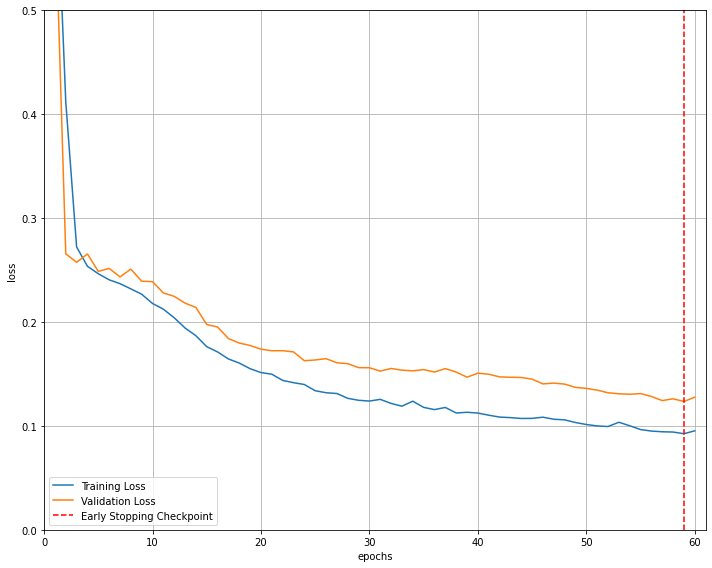

Dice2 score: 0.9370166233607701


In [ ]:
n_bs = [4]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "../Train/train_500"
model_chkpt_name = "ResNet-500x500_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)

#### model(4layer) - 1000x1000 images

Batch size: 1, Learning rate: 0.001 , Epochs: 60



  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validation loss decreased (inf --> 0.247850).  Saving model ...


  2%|▏         | 1/60 [01:10<1:08:58, 70.15s/it]

Train Epoch: 1 @ 12:50:57.001041 - Train Loss: 0.3918 - Valid Loss: 0.2478
Validation loss decreased (0.247850 --> 0.243593).  Saving model ...


  3%|▎         | 2/60 [01:30<53:24, 55.24s/it]  

Train Epoch: 2 @ 12:51:17.464002 - Train Loss: 0.1984 - Valid Loss: 0.2436
Validation loss decreased (0.243593 --> 0.241451).  Saving model ...


  5%|▌         | 3/60 [01:51<42:33, 44.79s/it]

Train Epoch: 3 @ 12:51:37.878620 - Train Loss: 0.1804 - Valid Loss: 0.2415
Validation loss decreased (0.241451 --> 0.227474).  Saving model ...


  7%|▋         | 4/60 [02:11<35:03, 37.56s/it]

Train Epoch: 4 @ 12:51:58.554421 - Train Loss: 0.1542 - Valid Loss: 0.2275
EarlyStopping counter: 1 out of 10


  8%|▊         | 5/60 [02:32<29:52, 32.60s/it]

Train Epoch: 5 @ 12:52:19.568143 - Train Loss: 0.1539 - Valid Loss: 0.2330
Validation loss decreased (0.227474 --> 0.209857).  Saving model ...


 10%|█         | 6/60 [02:53<26:06, 29.00s/it]

Train Epoch: 6 @ 12:52:40.195822 - Train Loss: 0.1578 - Valid Loss: 0.2099
EarlyStopping counter: 1 out of 10


 12%|█▏        | 7/60 [03:13<23:18, 26.39s/it]

Train Epoch: 7 @ 12:53:00.497431 - Train Loss: 0.1385 - Valid Loss: 0.2228
Validation loss decreased (0.209857 --> 0.206057).  Saving model ...


 13%|█▎        | 8/60 [03:34<21:28, 24.79s/it]

Train Epoch: 8 @ 12:53:21.534543 - Train Loss: 0.1334 - Valid Loss: 0.2061
EarlyStopping counter: 1 out of 10


 15%|█▌        | 9/60 [03:55<20:00, 23.55s/it]

Train Epoch: 9 @ 12:53:42.187373 - Train Loss: 0.1304 - Valid Loss: 0.2114
Validation loss decreased (0.206057 --> 0.189823).  Saving model ...


 17%|█▋        | 10/60 [04:16<19:00, 22.82s/it]

Train Epoch: 10 @ 12:54:03.305457 - Train Loss: 0.1275 - Valid Loss: 0.1898
EarlyStopping counter: 1 out of 10


 18%|█▊        | 11/60 [04:37<18:05, 22.16s/it]

Train Epoch: 11 @ 12:54:23.916726 - Train Loss: 0.1281 - Valid Loss: 0.1975
EarlyStopping counter: 2 out of 10


 20%|██        | 12/60 [04:57<17:21, 21.70s/it]

Train Epoch: 12 @ 12:54:44.564927 - Train Loss: 0.1301 - Valid Loss: 0.2086
Validation loss decreased (0.189823 --> 0.184375).  Saving model ...


 22%|██▏       | 13/60 [05:18<16:53, 21.56s/it]

Train Epoch: 13 @ 12:55:05.775068 - Train Loss: 0.1230 - Valid Loss: 0.1844
Validation loss decreased (0.184375 --> 0.180847).  Saving model ...


 23%|██▎       | 14/60 [05:40<16:29, 21.50s/it]

Train Epoch: 14 @ 12:55:27.152437 - Train Loss: 0.1199 - Valid Loss: 0.1808
EarlyStopping counter: 1 out of 10


 25%|██▌       | 15/60 [06:00<15:56, 21.26s/it]

Train Epoch: 15 @ 12:55:47.835901 - Train Loss: 0.1177 - Valid Loss: 0.1865
Validation loss decreased (0.180847 --> 0.174883).  Saving model ...


 27%|██▋       | 16/60 [06:22<15:36, 21.29s/it]

Train Epoch: 16 @ 12:56:09.196158 - Train Loss: 0.1158 - Valid Loss: 0.1749
Validation loss decreased (0.174883 --> 0.170331).  Saving model ...


 28%|██▊       | 17/60 [06:43<15:14, 21.27s/it]

Train Epoch: 17 @ 12:56:30.434798 - Train Loss: 0.1159 - Valid Loss: 0.1703
EarlyStopping counter: 1 out of 10


 30%|███       | 18/60 [07:04<14:45, 21.07s/it]

Train Epoch: 18 @ 12:56:51.041644 - Train Loss: 0.1127 - Valid Loss: 0.1707
Validation loss decreased (0.170331 --> 0.157943).  Saving model ...


 32%|███▏      | 19/60 [07:25<14:28, 21.18s/it]

Train Epoch: 19 @ 12:57:12.460630 - Train Loss: 0.1112 - Valid Loss: 0.1579
EarlyStopping counter: 1 out of 10


 33%|███▎      | 20/60 [07:46<14:00, 21.01s/it]

Train Epoch: 20 @ 12:57:33.096068 - Train Loss: 0.1079 - Valid Loss: 0.1843
EarlyStopping counter: 2 out of 10


 35%|███▌      | 21/60 [08:06<13:34, 20.88s/it]

Train Epoch: 21 @ 12:57:53.658416 - Train Loss: 0.1083 - Valid Loss: 0.1737
EarlyStopping counter: 3 out of 10


 37%|███▋      | 22/60 [08:27<13:14, 20.91s/it]

Train Epoch: 22 @ 12:58:14.624832 - Train Loss: 0.1036 - Valid Loss: 0.1886
EarlyStopping counter: 4 out of 10


 38%|███▊      | 23/60 [08:48<12:52, 20.89s/it]

Train Epoch: 23 @ 12:58:35.483317 - Train Loss: 0.1091 - Valid Loss: 0.2149
Validation loss decreased (0.157943 --> 0.156484).  Saving model ...


 40%|████      | 24/60 [09:09<12:36, 21.01s/it]

Train Epoch: 24 @ 12:58:56.771069 - Train Loss: 0.1036 - Valid Loss: 0.1565
EarlyStopping counter: 1 out of 10


 42%|████▏     | 25/60 [09:30<12:12, 20.92s/it]

Train Epoch: 25 @ 12:59:17.468749 - Train Loss: 0.0999 - Valid Loss: 0.1786
EarlyStopping counter: 2 out of 10


 43%|████▎     | 26/60 [09:51<11:48, 20.84s/it]

Train Epoch: 26 @ 12:59:38.118469 - Train Loss: 0.0976 - Valid Loss: 0.1973
Validation loss decreased (0.156484 --> 0.156028).  Saving model ...


 45%|████▌     | 27/60 [10:12<11:32, 21.00s/it]

Train Epoch: 27 @ 12:59:59.498391 - Train Loss: 0.0954 - Valid Loss: 0.1560
EarlyStopping counter: 1 out of 10


 47%|████▋     | 28/60 [10:33<11:08, 20.89s/it]

Train Epoch: 28 @ 13:00:20.120938 - Train Loss: 0.0982 - Valid Loss: 0.2254
EarlyStopping counter: 2 out of 10


 48%|████▊     | 29/60 [10:53<10:44, 20.80s/it]

Train Epoch: 29 @ 13:00:40.706421 - Train Loss: 0.0921 - Valid Loss: 0.2090
EarlyStopping counter: 3 out of 10


 50%|█████     | 30/60 [11:14<10:24, 20.82s/it]

Train Epoch: 30 @ 13:01:01.598324 - Train Loss: 0.0956 - Valid Loss: 0.1627
Validation loss decreased (0.156028 --> 0.152440).  Saving model ...


 52%|█████▏    | 31/60 [11:35<10:06, 20.91s/it]

Train Epoch: 31 @ 13:01:22.712937 - Train Loss: 0.0922 - Valid Loss: 0.1524
EarlyStopping counter: 1 out of 10


 53%|█████▎    | 32/60 [11:56<09:42, 20.81s/it]

Train Epoch: 32 @ 13:01:43.292114 - Train Loss: 0.1031 - Valid Loss: 0.1970
EarlyStopping counter: 2 out of 10


 55%|█████▌    | 33/60 [12:17<09:20, 20.76s/it]

Train Epoch: 33 @ 13:02:03.939073 - Train Loss: 0.0858 - Valid Loss: 0.2881
EarlyStopping counter: 3 out of 10


 57%|█████▋    | 34/60 [12:37<08:58, 20.71s/it]

Train Epoch: 34 @ 13:02:24.515981 - Train Loss: 0.0843 - Valid Loss: 0.1801
EarlyStopping counter: 4 out of 10


 58%|█████▊    | 35/60 [12:58<08:35, 20.62s/it]

Train Epoch: 35 @ 13:02:44.921333 - Train Loss: 0.0781 - Valid Loss: 0.1731
Validation loss decreased (0.152440 --> 0.152371).  Saving model ...


 60%|██████    | 36/60 [13:19<08:18, 20.77s/it]

Train Epoch: 36 @ 13:03:06.033624 - Train Loss: 0.0760 - Valid Loss: 0.1524
EarlyStopping counter: 1 out of 10


 62%|██████▏   | 37/60 [13:39<07:56, 20.71s/it]

Train Epoch: 37 @ 13:03:26.613097 - Train Loss: 0.0761 - Valid Loss: 0.1827
EarlyStopping counter: 2 out of 10


 63%|██████▎   | 38/60 [14:00<07:37, 20.79s/it]

Train Epoch: 38 @ 13:03:47.585997 - Train Loss: 0.0803 - Valid Loss: 0.2392
EarlyStopping counter: 3 out of 10


 65%|██████▌   | 39/60 [14:21<07:15, 20.72s/it]

Train Epoch: 39 @ 13:04:08.158700 - Train Loss: 0.0740 - Valid Loss: 0.2212
Validation loss decreased (0.152371 --> 0.147402).  Saving model ...


 67%|██████▋   | 40/60 [14:44<07:09, 21.46s/it]

Train Epoch: 40 @ 13:04:31.325755 - Train Loss: 0.0714 - Valid Loss: 0.1474
EarlyStopping counter: 1 out of 10


 68%|██████▊   | 41/60 [15:05<06:43, 21.26s/it]

Train Epoch: 41 @ 13:04:52.110744 - Train Loss: 0.0729 - Valid Loss: 0.2038
Validation loss decreased (0.147402 --> 0.133423).  Saving model ...


 70%|███████   | 42/60 [15:26<06:21, 21.20s/it]

Train Epoch: 42 @ 13:05:13.189419 - Train Loss: 0.0692 - Valid Loss: 0.1334
EarlyStopping counter: 1 out of 10


 72%|███████▏  | 43/60 [15:46<05:56, 20.99s/it]

Train Epoch: 43 @ 13:05:33.691959 - Train Loss: 0.0655 - Valid Loss: 0.1394
EarlyStopping counter: 2 out of 10


 73%|███████▎  | 44/60 [16:08<05:38, 21.13s/it]

Train Epoch: 44 @ 13:05:55.147001 - Train Loss: 0.0659 - Valid Loss: 0.2587
EarlyStopping counter: 3 out of 10


 75%|███████▌  | 45/60 [16:28<05:14, 20.96s/it]

Train Epoch: 45 @ 13:06:15.711777 - Train Loss: 0.0656 - Valid Loss: 0.2358
EarlyStopping counter: 4 out of 10


 77%|███████▋  | 46/60 [16:49<04:51, 20.83s/it]

Train Epoch: 46 @ 13:06:36.224781 - Train Loss: 0.0633 - Valid Loss: 0.1636
EarlyStopping counter: 5 out of 10


 78%|███████▊  | 47/60 [17:10<04:30, 20.78s/it]

Train Epoch: 47 @ 13:06:56.903516 - Train Loss: 0.0613 - Valid Loss: 0.1518
EarlyStopping counter: 6 out of 10


 80%|████████  | 48/60 [17:30<04:09, 20.80s/it]

Train Epoch: 48 @ 13:07:17.754927 - Train Loss: 0.0587 - Valid Loss: 0.1753
EarlyStopping counter: 7 out of 10


 82%|████████▏ | 49/60 [17:51<03:48, 20.75s/it]

Train Epoch: 49 @ 13:07:38.367194 - Train Loss: 0.0581 - Valid Loss: 0.2252
EarlyStopping counter: 8 out of 10


 83%|████████▎ | 50/60 [18:12<03:27, 20.79s/it]

Train Epoch: 50 @ 13:07:59.261253 - Train Loss: 0.0626 - Valid Loss: 0.1522
EarlyStopping counter: 9 out of 10


 85%|████████▌ | 51/60 [18:33<03:06, 20.77s/it]

Train Epoch: 51 @ 13:08:19.978097 - Train Loss: 0.0597 - Valid Loss: 0.1449
EarlyStopping counter: 10 out of 10
Early stopping


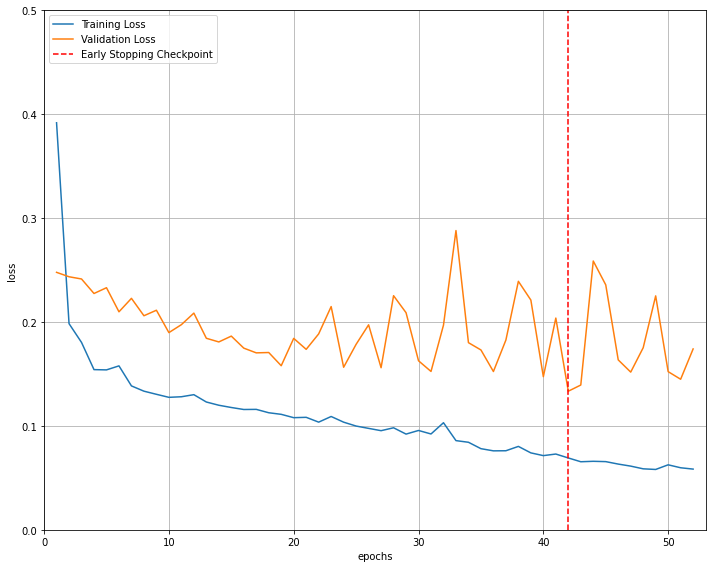

Dice2 score: 0.8904138565063476
Batch size: 1, Learning rate: 0.0001 , Epochs: 60




  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.204520).  Saving model ...



  2%|▏         | 1/60 [00:21<21:19, 21.68s/it]

Train Epoch: 1 @ 13:09:03.330579 - Train Loss: 0.4006 - Valid Loss: 0.2045
Validation loss decreased (0.204520 --> 0.138960).  Saving model ...



  3%|▎         | 2/60 [00:43<20:58, 21.69s/it]

Train Epoch: 2 @ 13:09:25.040499 - Train Loss: 0.2795 - Valid Loss: 0.1390
Validation loss decreased (0.138960 --> 0.130234).  Saving model ...



  5%|▌         | 3/60 [01:05<20:35, 21.68s/it]

Train Epoch: 3 @ 13:09:46.680198 - Train Loss: 0.2525 - Valid Loss: 0.1302
Validation loss decreased (0.130234 --> 0.122956).  Saving model ...



  7%|▋         | 4/60 [01:27<20:25, 21.89s/it]

Train Epoch: 4 @ 13:10:09.068185 - Train Loss: 0.2219 - Valid Loss: 0.1230
Validation loss decreased (0.122956 --> 0.118822).  Saving model ...



  8%|▊         | 5/60 [01:48<19:57, 21.78s/it]

Train Epoch: 5 @ 13:10:30.592926 - Train Loss: 0.1970 - Valid Loss: 0.1188
Validation loss decreased (0.118822 --> 0.108706).  Saving model ...



 10%|█         | 6/60 [02:10<19:35, 21.77s/it]

Train Epoch: 6 @ 13:10:52.337250 - Train Loss: 0.1794 - Valid Loss: 0.1087
Validation loss decreased (0.108706 --> 0.106169).  Saving model ...



 12%|█▏        | 7/60 [02:32<19:13, 21.77s/it]

Train Epoch: 7 @ 13:11:14.115913 - Train Loss: 0.1640 - Valid Loss: 0.1062
Validation loss decreased (0.106169 --> 0.102184).  Saving model ...



 13%|█▎        | 8/60 [02:55<19:18, 22.29s/it]

Train Epoch: 8 @ 13:11:37.603104 - Train Loss: 0.1612 - Valid Loss: 0.1022
Validation loss decreased (0.102184 --> 0.097172).  Saving model ...



 15%|█▌        | 9/60 [03:17<18:52, 22.21s/it]

Train Epoch: 9 @ 13:11:59.624149 - Train Loss: 0.1475 - Valid Loss: 0.0972
Validation loss decreased (0.097172 --> 0.092754).  Saving model ...



 17%|█▋        | 10/60 [03:39<18:25, 22.11s/it]

Train Epoch: 10 @ 13:12:21.511867 - Train Loss: 0.1361 - Valid Loss: 0.0928
EarlyStopping counter: 1 out of 10



 18%|█▊        | 11/60 [04:01<17:51, 21.86s/it]

Train Epoch: 11 @ 13:12:42.783529 - Train Loss: 0.1343 - Valid Loss: 0.0968
Validation loss decreased (0.092754 --> 0.087328).  Saving model ...



 20%|██        | 12/60 [04:23<17:33, 21.94s/it]

Train Epoch: 12 @ 13:13:04.880749 - Train Loss: 0.1253 - Valid Loss: 0.0873
EarlyStopping counter: 1 out of 10



 22%|██▏       | 13/60 [04:44<17:02, 21.76s/it]

Train Epoch: 13 @ 13:13:26.249203 - Train Loss: 0.1191 - Valid Loss: 0.0901
Validation loss decreased (0.087328 --> 0.081575).  Saving model ...



 23%|██▎       | 14/60 [05:06<16:41, 21.78s/it]

Train Epoch: 14 @ 13:13:48.069328 - Train Loss: 0.1151 - Valid Loss: 0.0816
EarlyStopping counter: 1 out of 10



 25%|██▌       | 15/60 [05:28<16:17, 21.71s/it]

Train Epoch: 15 @ 13:14:09.630556 - Train Loss: 0.1134 - Valid Loss: 0.0860
Validation loss decreased (0.081575 --> 0.080117).  Saving model ...



 27%|██▋       | 16/60 [05:50<16:01, 21.84s/it]

Train Epoch: 16 @ 13:14:31.773049 - Train Loss: 0.1093 - Valid Loss: 0.0801
Validation loss decreased (0.080117 --> 0.080007).  Saving model ...



 28%|██▊       | 17/60 [06:12<15:41, 21.90s/it]

Train Epoch: 17 @ 13:14:53.803022 - Train Loss: 0.1032 - Valid Loss: 0.0800
EarlyStopping counter: 1 out of 10



 30%|███       | 18/60 [06:33<15:11, 21.71s/it]

Train Epoch: 18 @ 13:15:15.074450 - Train Loss: 0.0996 - Valid Loss: 0.0816
EarlyStopping counter: 2 out of 10



 32%|███▏      | 19/60 [06:54<14:46, 21.61s/it]

Train Epoch: 19 @ 13:15:36.453683 - Train Loss: 0.0982 - Valid Loss: 0.0813
Validation loss decreased (0.080007 --> 0.077926).  Saving model ...



 33%|███▎      | 20/60 [07:16<14:31, 21.78s/it]

Train Epoch: 20 @ 13:15:58.613997 - Train Loss: 0.0955 - Valid Loss: 0.0779
EarlyStopping counter: 1 out of 10



 35%|███▌      | 21/60 [07:38<14:04, 21.65s/it]

Train Epoch: 21 @ 13:16:19.970800 - Train Loss: 0.0946 - Valid Loss: 0.0854
EarlyStopping counter: 2 out of 10



 37%|███▋      | 22/60 [07:59<13:39, 21.57s/it]

Train Epoch: 22 @ 13:16:41.338445 - Train Loss: 0.0955 - Valid Loss: 0.0786
EarlyStopping counter: 3 out of 10



 38%|███▊      | 23/60 [08:21<13:17, 21.54s/it]

Train Epoch: 23 @ 13:17:02.820594 - Train Loss: 0.0973 - Valid Loss: 0.0917
EarlyStopping counter: 4 out of 10



 40%|████      | 24/60 [08:42<12:52, 21.44s/it]

Train Epoch: 24 @ 13:17:24.041896 - Train Loss: 0.1069 - Valid Loss: 0.0796
Validation loss decreased (0.077926 --> 0.075441).  Saving model ...



 42%|████▏     | 25/60 [09:04<12:33, 21.54s/it]

Train Epoch: 25 @ 13:17:45.798332 - Train Loss: 0.0979 - Valid Loss: 0.0754
EarlyStopping counter: 1 out of 10



 43%|████▎     | 26/60 [09:26<12:23, 21.87s/it]

Train Epoch: 26 @ 13:18:08.436308 - Train Loss: 0.0910 - Valid Loss: 0.0766
Validation loss decreased (0.075441 --> 0.073821).  Saving model ...



 45%|████▌     | 27/60 [09:48<12:00, 21.83s/it]

Train Epoch: 27 @ 13:18:30.176260 - Train Loss: 0.0813 - Valid Loss: 0.0738
Validation loss decreased (0.073821 --> 0.072945).  Saving model ...



 47%|████▋     | 28/60 [10:10<11:39, 21.86s/it]

Train Epoch: 28 @ 13:18:52.096817 - Train Loss: 0.0759 - Valid Loss: 0.0729
Validation loss decreased (0.072945 --> 0.071059).  Saving model ...



 48%|████▊     | 29/60 [10:32<11:19, 21.91s/it]

Train Epoch: 29 @ 13:19:14.135339 - Train Loss: 0.0725 - Valid Loss: 0.0711
EarlyStopping counter: 1 out of 10



 50%|█████     | 30/60 [10:53<10:52, 21.74s/it]

Train Epoch: 30 @ 13:19:35.481871 - Train Loss: 0.0734 - Valid Loss: 0.0797
EarlyStopping counter: 2 out of 10



 52%|█████▏    | 31/60 [11:15<10:26, 21.60s/it]

Train Epoch: 31 @ 13:19:56.749393 - Train Loss: 0.0711 - Valid Loss: 0.0761
EarlyStopping counter: 3 out of 10



 53%|█████▎    | 32/60 [11:36<10:05, 21.62s/it]

Train Epoch: 32 @ 13:20:18.416518 - Train Loss: 0.0684 - Valid Loss: 0.0754
EarlyStopping counter: 4 out of 10



 55%|█████▌    | 33/60 [11:58<09:42, 21.56s/it]

Train Epoch: 33 @ 13:20:39.854327 - Train Loss: 0.0677 - Valid Loss: 0.0748
EarlyStopping counter: 5 out of 10



 57%|█████▋    | 34/60 [12:19<09:20, 21.54s/it]

Train Epoch: 34 @ 13:21:01.337093 - Train Loss: 0.0650 - Valid Loss: 0.0724
EarlyStopping counter: 6 out of 10



 58%|█████▊    | 35/60 [12:40<08:56, 21.46s/it]

Train Epoch: 35 @ 13:21:22.619787 - Train Loss: 0.0673 - Valid Loss: 0.0738
EarlyStopping counter: 7 out of 10



 60%|██████    | 36/60 [13:02<08:35, 21.46s/it]

Train Epoch: 36 @ 13:21:44.071230 - Train Loss: 0.0657 - Valid Loss: 0.0735
EarlyStopping counter: 8 out of 10



 62%|██████▏   | 37/60 [13:24<08:14, 21.51s/it]

Train Epoch: 37 @ 13:22:05.693374 - Train Loss: 0.0645 - Valid Loss: 0.0791
EarlyStopping counter: 9 out of 10



 63%|██████▎   | 38/60 [13:46<07:58, 21.77s/it]

Train Epoch: 38 @ 13:22:28.081597 - Train Loss: 0.0642 - Valid Loss: 0.0727
EarlyStopping counter: 10 out of 10
Early stopping


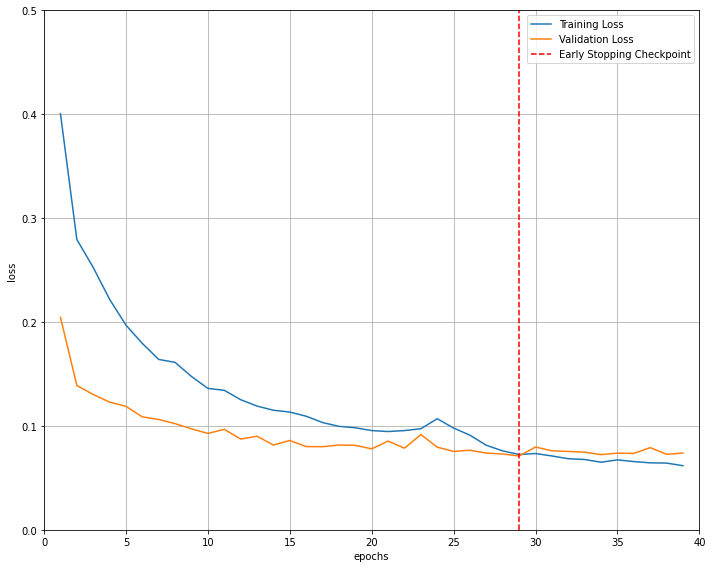

Dice2 score: 0.9395395278930664
Batch size: 1, Learning rate: 1e-05 , Epochs: 60





  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.637599).  Saving model ...




  2%|▏         | 1/60 [00:22<21:39, 22.02s/it]

Train Epoch: 1 @ 13:23:12.550746 - Train Loss: 0.6752 - Valid Loss: 0.6376
Validation loss decreased (0.637599 --> 0.375606).  Saving model ...




  3%|▎         | 2/60 [00:43<21:11, 21.93s/it]

Train Epoch: 2 @ 13:23:34.261487 - Train Loss: 0.4628 - Valid Loss: 0.3756
Validation loss decreased (0.375606 --> 0.351827).  Saving model ...




  5%|▌         | 3/60 [01:05<20:49, 21.92s/it]

Train Epoch: 3 @ 13:23:56.167403 - Train Loss: 0.2866 - Valid Loss: 0.3518
Validation loss decreased (0.351827 --> 0.348329).  Saving model ...




  7%|▋         | 4/60 [01:29<21:02, 22.55s/it]

Train Epoch: 4 @ 13:24:20.166932 - Train Loss: 0.2599 - Valid Loss: 0.3483
Validation loss decreased (0.348329 --> 0.347269).  Saving model ...




  8%|▊         | 5/60 [01:51<20:27, 22.33s/it]

Train Epoch: 5 @ 13:24:41.979281 - Train Loss: 0.2466 - Valid Loss: 0.3473
Validation loss decreased (0.347269 --> 0.345517).  Saving model ...




 10%|█         | 6/60 [02:13<20:02, 22.26s/it]

Train Epoch: 6 @ 13:25:04.090933 - Train Loss: 0.2389 - Valid Loss: 0.3455
EarlyStopping counter: 1 out of 10




 12%|█▏        | 7/60 [02:35<19:27, 22.03s/it]

Train Epoch: 7 @ 13:25:25.588206 - Train Loss: 0.2312 - Valid Loss: 0.3461
EarlyStopping counter: 2 out of 10




 13%|█▎        | 8/60 [02:56<18:58, 21.89s/it]

Train Epoch: 8 @ 13:25:47.142635 - Train Loss: 0.2259 - Valid Loss: 0.3463
Validation loss decreased (0.345517 --> 0.343621).  Saving model ...




 15%|█▌        | 9/60 [03:18<18:37, 21.91s/it]

Train Epoch: 9 @ 13:26:09.098421 - Train Loss: 0.2200 - Valid Loss: 0.3436
Validation loss decreased (0.343621 --> 0.343195).  Saving model ...




 17%|█▋        | 10/60 [03:40<18:15, 21.91s/it]

Train Epoch: 10 @ 13:26:31.005197 - Train Loss: 0.2153 - Valid Loss: 0.3432
Validation loss decreased (0.343195 --> 0.341165).  Saving model ...




 18%|█▊        | 11/60 [04:02<17:56, 21.96s/it]

Train Epoch: 11 @ 13:26:53.085486 - Train Loss: 0.2115 - Valid Loss: 0.3412
Validation loss decreased (0.341165 --> 0.339880).  Saving model ...




 20%|██        | 12/60 [04:26<17:55, 22.41s/it]

Train Epoch: 12 @ 13:27:16.562598 - Train Loss: 0.2073 - Valid Loss: 0.3399
Validation loss decreased (0.339880 --> 0.337882).  Saving model ...




 22%|██▏       | 13/60 [04:47<17:25, 22.24s/it]

Train Epoch: 13 @ 13:27:38.395296 - Train Loss: 0.2035 - Valid Loss: 0.3379
Validation loss decreased (0.337882 --> 0.337019).  Saving model ...




 23%|██▎       | 14/60 [05:09<17:00, 22.19s/it]

Train Epoch: 14 @ 13:28:00.469304 - Train Loss: 0.2000 - Valid Loss: 0.3370
Validation loss decreased (0.337019 --> 0.333537).  Saving model ...




 25%|██▌       | 15/60 [05:31<16:34, 22.09s/it]

Train Epoch: 15 @ 13:28:22.329824 - Train Loss: 0.1956 - Valid Loss: 0.3335
Validation loss decreased (0.333537 --> 0.330072).  Saving model ...




 27%|██▋       | 16/60 [05:57<16:57, 23.12s/it]

Train Epoch: 16 @ 13:28:47.856400 - Train Loss: 0.1905 - Valid Loss: 0.3301
Validation loss decreased (0.330072 --> 0.326843).  Saving model ...




 28%|██▊       | 17/60 [06:19<16:21, 22.82s/it]

Train Epoch: 17 @ 13:29:09.980830 - Train Loss: 0.1865 - Valid Loss: 0.3268
Validation loss decreased (0.326843 --> 0.324398).  Saving model ...




 30%|███       | 18/60 [06:41<15:46, 22.54s/it]

Train Epoch: 18 @ 13:29:31.870093 - Train Loss: 0.1816 - Valid Loss: 0.3244
Validation loss decreased (0.324398 --> 0.321168).  Saving model ...




 32%|███▏      | 19/60 [07:03<15:15, 22.34s/it]

Train Epoch: 19 @ 13:29:53.723685 - Train Loss: 0.1769 - Valid Loss: 0.3212
Validation loss decreased (0.321168 --> 0.317659).  Saving model ...




 33%|███▎      | 20/60 [07:25<14:49, 22.24s/it]

Train Epoch: 20 @ 13:30:15.743932 - Train Loss: 0.1730 - Valid Loss: 0.3177
Validation loss decreased (0.317659 --> 0.313151).  Saving model ...




 35%|███▌      | 21/60 [07:46<14:22, 22.10s/it]

Train Epoch: 21 @ 13:30:37.526366 - Train Loss: 0.1692 - Valid Loss: 0.3132
Validation loss decreased (0.313151 --> 0.308817).  Saving model ...




 37%|███▋      | 22/60 [08:08<13:55, 21.98s/it]

Train Epoch: 22 @ 13:30:59.231863 - Train Loss: 0.1654 - Valid Loss: 0.3088
Validation loss decreased (0.308817 --> 0.304091).  Saving model ...




 38%|███▊      | 23/60 [08:30<13:33, 21.97s/it]

Train Epoch: 23 @ 13:31:21.185437 - Train Loss: 0.1614 - Valid Loss: 0.3041
Validation loss decreased (0.304091 --> 0.301570).  Saving model ...




 40%|████      | 24/60 [08:52<13:11, 21.98s/it]

Train Epoch: 24 @ 13:31:43.166040 - Train Loss: 0.1572 - Valid Loss: 0.3016
Validation loss decreased (0.301570 --> 0.300036).  Saving model ...




 42%|████▏     | 25/60 [09:14<12:47, 21.93s/it]

Train Epoch: 25 @ 13:32:04.997890 - Train Loss: 0.1537 - Valid Loss: 0.3000
Validation loss decreased (0.300036 --> 0.292066).  Saving model ...




 43%|████▎     | 26/60 [09:36<12:23, 21.86s/it]

Train Epoch: 26 @ 13:32:26.682134 - Train Loss: 0.1500 - Valid Loss: 0.2921
EarlyStopping counter: 1 out of 10




 45%|████▌     | 27/60 [09:58<12:05, 21.97s/it]

Train Epoch: 27 @ 13:32:48.911358 - Train Loss: 0.1467 - Valid Loss: 0.2924
Validation loss decreased (0.292066 --> 0.288165).  Saving model ...




 47%|████▋     | 28/60 [10:20<11:42, 21.94s/it]

Train Epoch: 28 @ 13:33:10.793667 - Train Loss: 0.1433 - Valid Loss: 0.2882
Validation loss decreased (0.288165 --> 0.284975).  Saving model ...




 48%|████▊     | 29/60 [10:41<11:17, 21.86s/it]

Train Epoch: 29 @ 13:33:32.455667 - Train Loss: 0.1418 - Valid Loss: 0.2850
Validation loss decreased (0.284975 --> 0.268583).  Saving model ...




 50%|█████     | 30/60 [11:03<10:56, 21.87s/it]

Train Epoch: 30 @ 13:33:54.353389 - Train Loss: 0.1407 - Valid Loss: 0.2686
EarlyStopping counter: 1 out of 10




 52%|█████▏    | 31/60 [11:25<10:29, 21.71s/it]

Train Epoch: 31 @ 13:34:15.676894 - Train Loss: 0.1397 - Valid Loss: 0.2700
Validation loss decreased (0.268583 --> 0.263704).  Saving model ...




 53%|█████▎    | 32/60 [11:46<10:08, 21.73s/it]

Train Epoch: 32 @ 13:34:37.468128 - Train Loss: 0.1368 - Valid Loss: 0.2637
EarlyStopping counter: 1 out of 10




 55%|█████▌    | 33/60 [12:08<09:44, 21.63s/it]

Train Epoch: 33 @ 13:34:58.863909 - Train Loss: 0.1329 - Valid Loss: 0.2640
Validation loss decreased (0.263704 --> 0.257497).  Saving model ...




 57%|█████▋    | 34/60 [12:30<09:24, 21.71s/it]

Train Epoch: 34 @ 13:35:20.767836 - Train Loss: 0.1299 - Valid Loss: 0.2575
EarlyStopping counter: 1 out of 10




 58%|█████▊    | 35/60 [12:51<09:01, 21.68s/it]

Train Epoch: 35 @ 13:35:42.360072 - Train Loss: 0.1274 - Valid Loss: 0.2581
Validation loss decreased (0.257497 --> 0.256180).  Saving model ...




 60%|██████    | 36/60 [13:13<08:42, 21.76s/it]

Train Epoch: 36 @ 13:36:04.310176 - Train Loss: 0.1251 - Valid Loss: 0.2562
EarlyStopping counter: 1 out of 10




 62%|██████▏   | 37/60 [13:35<08:18, 21.65s/it]

Train Epoch: 37 @ 13:36:25.720705 - Train Loss: 0.1227 - Valid Loss: 0.2604
Validation loss decreased (0.256180 --> 0.249578).  Saving model ...




 63%|██████▎   | 38/60 [13:57<07:59, 21.81s/it]

Train Epoch: 38 @ 13:36:47.888845 - Train Loss: 0.1196 - Valid Loss: 0.2496
EarlyStopping counter: 1 out of 10




 65%|██████▌   | 39/60 [14:18<07:35, 21.68s/it]

Train Epoch: 39 @ 13:37:09.263765 - Train Loss: 0.1169 - Valid Loss: 0.2659
EarlyStopping counter: 2 out of 10




 67%|██████▋   | 40/60 [14:40<07:11, 21.56s/it]

Train Epoch: 40 @ 13:37:30.559427 - Train Loss: 0.1147 - Valid Loss: 0.2564
EarlyStopping counter: 3 out of 10




 68%|██████▊   | 41/60 [15:01<06:49, 21.57s/it]

Train Epoch: 41 @ 13:37:52.138432 - Train Loss: 0.1117 - Valid Loss: 0.2698
Validation loss decreased (0.249578 --> 0.246643).  Saving model ...




 70%|███████   | 42/60 [15:23<06:29, 21.66s/it]

Train Epoch: 42 @ 13:38:14.015974 - Train Loss: 0.1094 - Valid Loss: 0.2466
EarlyStopping counter: 1 out of 10




 72%|███████▏  | 43/60 [15:44<06:06, 21.55s/it]

Train Epoch: 43 @ 13:38:35.305398 - Train Loss: 0.1083 - Valid Loss: 0.2558
EarlyStopping counter: 2 out of 10




 73%|███████▎  | 44/60 [16:06<05:45, 21.56s/it]

Train Epoch: 44 @ 13:38:56.904734 - Train Loss: 0.1059 - Valid Loss: 0.2546
EarlyStopping counter: 3 out of 10




 75%|███████▌  | 45/60 [16:27<05:22, 21.51s/it]

Train Epoch: 45 @ 13:39:18.304616 - Train Loss: 0.1030 - Valid Loss: 0.2747
EarlyStopping counter: 4 out of 10




 77%|███████▋  | 46/60 [16:49<05:00, 21.44s/it]

Train Epoch: 46 @ 13:39:39.571106 - Train Loss: 0.1016 - Valid Loss: 0.2603
EarlyStopping counter: 5 out of 10




 78%|███████▊  | 47/60 [17:10<04:38, 21.44s/it]

Train Epoch: 47 @ 13:40:01.014964 - Train Loss: 0.0994 - Valid Loss: 0.2751
EarlyStopping counter: 6 out of 10




 80%|████████  | 48/60 [17:31<04:17, 21.42s/it]

Train Epoch: 48 @ 13:40:22.381010 - Train Loss: 0.0980 - Valid Loss: 0.2503
EarlyStopping counter: 7 out of 10




 82%|████████▏ | 49/60 [17:53<03:55, 21.38s/it]

Train Epoch: 49 @ 13:40:43.658034 - Train Loss: 0.0969 - Valid Loss: 0.2802
EarlyStopping counter: 8 out of 10




 83%|████████▎ | 50/60 [18:14<03:34, 21.42s/it]

Train Epoch: 50 @ 13:41:05.172759 - Train Loss: 0.0960 - Valid Loss: 0.2554
EarlyStopping counter: 9 out of 10




 85%|████████▌ | 51/60 [18:36<03:12, 21.43s/it]

Train Epoch: 51 @ 13:41:26.635744 - Train Loss: 0.0954 - Valid Loss: 0.2671
EarlyStopping counter: 10 out of 10
Early stopping


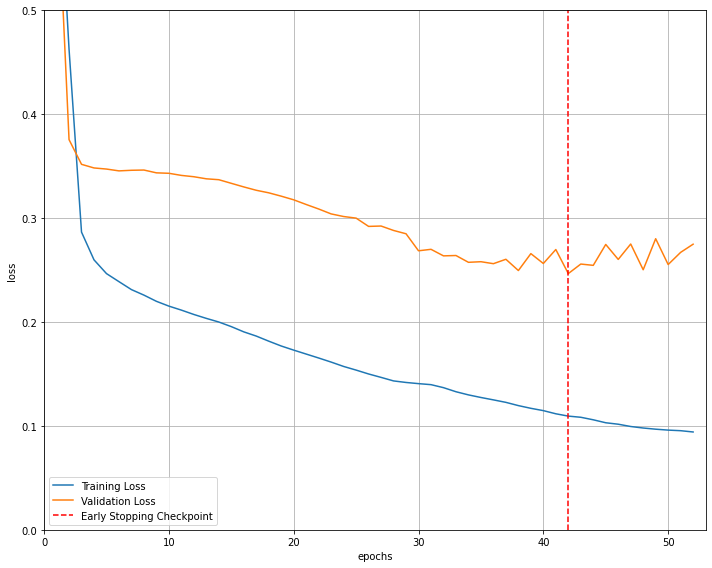

Dice2 score: 0.7982578277587891


In [ ]:
n_bs = [1]
n_lr = [0.001, 0.0001, 0.00001]
epochs = 60
patience = 10

train_dir = "../Train"
model_chkpt_name = "ResNet-1000x1000_4layer"

for bs in n_bs:
    for lr in n_lr:
        hyperparam_tuning(train_dir, bs, lr, epochs, patience, model_chkpt_name)